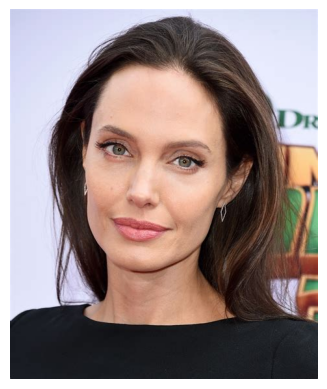

In [1]:
import os
import cv2

# Directory containing the dataset
dataset_dir = r"C:\Users\DT user\Desktop\Images\Celebrity"

# Function to load images from a directory
def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    return images

# Load images from all folders in the dataset directory
all_images = []
for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)
    if os.path.isdir(folder_path):
        images = load_images_from_dir(folder_path)
        all_images.extend(images)

# Display an example image
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(all_images[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [2]:
#Import required dependencies

from __future__ import print_function,division

from keras.layers import BatchNormalization,Activation,Dense,Input,Reshape, Flatten, Dropout, multiply,GaussianNoise,Embedding,ZeroPadding2D,MaxPooling2D
from keras.layers import LeakyReLU
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import losses
from keras.utils import to_categorical
import keras.backend as k

import matplotlib.pyplot as plt
import numpy as np

In [4]:
import numpy as np
import os
import cv2
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

class ContextEncoder():
    def __init__(self):
        self.img_rows = 128  # Increased image size
        self.img_cols = 128  # Increased image size
        self.mask_height = 32
        self.mask_width = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes masked images as input and generates the missing part
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)

        # For the combined model, we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines if it's generated or real
        valid = self.discriminator(gen_missing)

        # The combined model (stacked generator and discriminator)
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('sigmoid'))

        # model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        # model.summary()

        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_center(self, imgs):
        center_y = self.img_rows // 2
        center_x = self.img_cols // 2
        half_height = self.mask_height // 2
        half_width = self.mask_width // 2

        y1 = np.full(imgs.shape[0], center_y - half_height)
        y2 = np.full(imgs.shape[0], center_y + half_height)
        x1 = np.full(imgs.shape[0], center_x - half_width)
        x2 = np.full(imgs.shape[0], center_x + half_width)

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            missing_parts[i] = masked_img[y1[i]:y2[i], x1[i]:x2[i], :].copy()
            masked_img[y1[i]:y2[i], x1[i]:x2[i], :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def load_images(self, dataset_dir):
        X = []
        for folder_name in os.listdir(dataset_dir):
            folder_path = os.path.join(dataset_dir, folder_name)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    if filename.endswith('.jpg') or filename.endswith('.png'):
                        img_path = os.path.join(folder_path, filename)
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                            img = cv2.resize(img, (self.img_rows, self.img_cols))
                            X.append(img)
        return np.array(X)
    
    def augment_data(self, X):
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
        
        augmented_data = []
        for img in X:
            img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels) for flow() method
            for batch in datagen.flow(img, batch_size=1):
                augmented_data.append(batch[0])
                break  # Stop the loop after one iteration to avoid infinite loop
        
        return np.array(augmented_data)
    
    def split_data(self, X, test_size=0.2):
        return train_test_split(X, test_size=test_size, random_state=42)
    
    def train(self, X_train, epochs, batch_size=64, sample_interval=50):

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            #  Train Discriminator

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            masked_imgs, missing_parts, _ = self.mask_center(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)

            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])

            # Evaluate Discriminator Accuracy
            _, acc_real = self.discriminator.evaluate(missing_parts, valid)
            _, acc_fake = self.discriminator.evaluate(gen_missing, fake)

            # Plot the progress
            print ("%d [D loss: %s, acc_real: %.2f%%, acc_fake: %.2f%%] [G loss: %s]" %
               (epoch, str(d_loss), acc_real * 100, acc_fake * 100, str(g_loss)))

            if epoch % sample_interval == 0:
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
            if epoch==10000:
                self.save_model()

    def sample_images(self, epoch, imgs):
        r, c = 3, 6

        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_center(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :,:])
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :,:])
            axs[1,i].axis('off')
            filled_in = imgs[i].copy()
            filled_in[y1[i]:y2[i], x1[i]:x2[i], :] = gen_missing[i]
            axs[2,i].imshow(filled_in)
            axs[2,i].axis('off')
        fig.savefig("images/%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

# Usage example:
context_encoder = ContextEncoder()
dataset_dir = r"C:\Users\DT user\Desktop\Images\Celebrity"
X = context_encoder.load_images(dataset_dir)
X_augmented = context_encoder.augment_data(X)
X_train, X_test = context_encoder.split_data(X_augmented)
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
context_encoder.train(X_train,epochs=10001, batch_size=64, sample_interval=200)



Train data shape: (1440, 128, 128, 3)
Test data shape: (360, 128, 128, 3)
2/2 [==============================] - 0s 57ms/step


2/2 [==============================] - 0s 21ms/step - loss: 0.7018 - accuracy: 0.0000e+00
0 [D loss: [0.85984784 0.3984375 ], acc_real: 96.88%, acc_fake: 0.00%] [G loss: [0.6422253847122192, 0.6421864628791809, 0.6810963749885559]]
2/2 [==============================] - 0s 0s/step - loss: 0.7220 - accuracy: 0.0000e+00
1 [D loss: [0.22854244 0.921875  ], acc_real: 92.19%, acc_fake: 0.00%] [G loss: [0.6368034482002258, 0.6367799639701843, 0.6602492928504944]]
2/2 [==============================] - 0s 9ms/step - loss: 0.7287 - accuracy: 0.0000e+00
2 [D loss: [0.15047189 0.9453125 ], acc_real: 93.75%, acc_fake: 0.00%] [G loss: [0.6121445298194885, 0.6121030449867249, 0.6535594463348389]]
2/2 [==============================] - 0s 20ms/step - loss: 0.7274 - accuracy: 0.0000e+00
3 [D loss: [0.06186672 1.        ], acc_real: 90.62%, acc_fake: 0.00%] [G loss: [0.5725

41 [D loss: [0.00136421 1.        ], acc_real: 12.50%, acc_fake: 100.00%] [G loss: [0.37214794754981995, 0.3717520534992218, 0.7676538228988647]]
2/2 [==============================] - 0s 8ms/step - loss: 0.6056 - accuracy: 1.0000
42 [D loss: [0.00145695 1.        ], acc_real: 12.50%, acc_fake: 100.00%] [G loss: [0.37461286783218384, 0.3742215037345886, 0.765582799911499]]
2/2 [==============================] - 0s 7ms/step - loss: 0.6054 - accuracy: 1.0000
43 [D loss: [0.00177071 1.        ], acc_real: 14.06%, acc_fake: 100.00%] [G loss: [0.371700257062912, 0.3713032603263855, 0.7683008313179016]]
2/2 [==============================] - 0s 7ms/step - loss: 0.6022 - accuracy: 1.0000
44 [D loss: [0.00233899 1.        ], acc_real: 6.25%, acc_fake: 100.00%] [G loss: [0.347330242395401, 0.3469008803367615, 0.7762689590454102]]
2/2 [==============================] - 0s 7ms/step - loss: 0.6020 - accuracy: 1.0000
45 [D loss: [0.00134116 1.        ], acc_real: 14.06%, acc_fake: 100.00%] [G loss:

2/2 [==============================] - 0s 16ms/step - loss: 0.6215 - accuracy: 1.0000
64 [D loss: [6.03191307e-04 1.00000000e+00], acc_real: 25.00%, acc_fake: 100.00%] [G loss: [0.36834168434143066, 0.3679620623588562, 0.7475822567939758]]
2/2 [==============================] - 0s 16ms/step - loss: 0.6236 - accuracy: 1.0000
65 [D loss: [7.8713501e-04 1.0000000e+00], acc_real: 29.69%, acc_fake: 100.00%] [G loss: [0.3806030750274658, 0.3802372217178345, 0.7460751533508301]]
2/2 [==============================] - 0s 0s/step - loss: 0.6255 - accuracy: 1.0000
66 [D loss: [5.88147399e-04 1.00000000e+00], acc_real: 32.81%, acc_fake: 100.00%] [G loss: [0.35885778069496155, 0.35846975445747375, 0.7464874982833862]]
2/2 [==============================] - 0s 0s/step - loss: 0.6259 - accuracy: 1.0000
67 [D loss: [8.08469355e-04 1.00000000e+00], acc_real: 39.06%, acc_fake: 100.00%] [G loss: [0.34982988238334656, 0.34942999482154846, 0.7493324279785156]]
2/2 [==============================] - 0s 0s/

2/2 [==============================] - 0s 9ms/step - loss: 0.7938 - accuracy: 0.0000e+00
86 [D loss: [3.52359246e-04 1.00000000e+00], acc_real: 81.25%, acc_fake: 0.00%] [G loss: [0.35719525814056396, 0.3569495975971222, 0.6026025414466858]]
2/2 [==============================] - 0s 7ms/step - loss: 0.7963 - accuracy: 0.0000e+00
87 [D loss: [6.19787388e-04 1.00000000e+00], acc_real: 85.94%, acc_fake: 0.00%] [G loss: [0.3312378525733948, 0.3309788405895233, 0.5899829864501953]]
2/2 [==============================] - 0s 7ms/step - loss: 0.8026 - accuracy: 0.0000e+00
88 [D loss: [4.82480948e-04 1.00000000e+00], acc_real: 81.25%, acc_fake: 0.00%] [G loss: [0.318382203578949, 0.3180844783782959, 0.6158185005187988]]
2/2 [==============================] - 0s 7ms/step - loss: 0.8074 - accuracy: 0.0000e+00
89 [D loss: [4.96202036e-04 1.00000000e+00], acc_real: 81.25%, acc_fake: 0.00%] [G loss: [0.3540477752685547, 0.35378730297088623, 0.6142613887786865]]
2/2 [==============================] - 

2/2 [==============================] - 0s 8ms/step - loss: 0.9997 - accuracy: 0.0000e+00
108 [D loss: [3.17884398e-04 1.00000000e+00], acc_real: 98.44%, acc_fake: 0.00%] [G loss: [0.3009994626045227, 0.30084866285324097, 0.4516633152961731]]
2/2 [==============================] - 0s 16ms/step - loss: 1.0044 - accuracy: 0.0000e+00
109 [D loss: [6.51563169e-04 1.00000000e+00], acc_real: 98.44%, acc_fake: 0.00%] [G loss: [0.3028104901313782, 0.3026500940322876, 0.4630376100540161]]
2/2 [==============================] - 0s 7ms/step - loss: 1.0277 - accuracy: 0.0000e+00
110 [D loss: [1.96930814e-04 1.00000000e+00], acc_real: 98.44%, acc_fake: 0.00%] [G loss: [0.3842933475971222, 0.3842337727546692, 0.4438183009624481]]
2/2 [==============================] - 0s 7ms/step - loss: 1.0263 - accuracy: 0.0000e+00
111 [D loss: [4.54231602e-04 1.00000000e+00], acc_real: 96.88%, acc_fake: 0.00%] [G loss: [0.31039682030677795, 0.31026068329811096, 0.4463828206062317]]
2/2 [===========================

2/2 [==============================] - 0s 7ms/step - loss: 1.7459 - accuracy: 0.0000e+00
151 [D loss: [1.60750464e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.3310573995113373, 0.33119797706604004, 0.1906217634677887]]
2/2 [==============================] - 0s 0s/step - loss: 1.7524 - accuracy: 0.0000e+00
152 [D loss: [1.56953261e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.333112895488739, 0.33326008915901184, 0.18606795370578766]]
2/2 [==============================] - 0s 6ms/step - loss: 1.7827 - accuracy: 0.0000e+00
153 [D loss: [2.68502281e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2906185984611511, 0.2907310426235199, 0.17827686667442322]]
2/2 [==============================] - 0s 159us/step - loss: 1.8031 - accuracy: 0.0000e+00
154 [D loss: [3.84629073e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.29843366146087646, 0.2985532283782959, 0.17898954451084137]]
2/2 [=====================

2/2 [==============================] - 0s 7ms/step - loss: 3.1827 - accuracy: 0.0000e+00
194 [D loss: [2.68767355e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2963317334651947, 0.2965780794620514, 0.050218284130096436]]
2/2 [==============================] - 0s 0s/step - loss: 3.2061 - accuracy: 0.0000e+00
195 [D loss: [1.92493855e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.3155689239501953, 0.315830796957016, 0.05393214523792267]]
2/2 [==============================] - 0s 8ms/step - loss: 3.2137 - accuracy: 0.0000e+00
196 [D loss: [4.36646471e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2833217680454254, 0.28355827927589417, 0.047067634761333466]]
2/2 [==============================] - 0s 7ms/step - loss: 3.2206 - accuracy: 0.0000e+00
197 [D loss: [4.56761627e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.35833513736724854, 0.3586498498916626, 0.04393932223320007]]
2/2 [=====================

2/2 [==============================] - 0s 16ms/step - loss: 4.0780 - accuracy: 0.0000e+00
215 [D loss: [2.87210372e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2812785506248474, 0.2815312445163727, 0.028808798640966415]]
2/2 [==============================] - 0s 7ms/step - loss: 4.0908 - accuracy: 0.0000e+00
216 [D loss: [2.55198604e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.3163389265537262, 0.3166341185569763, 0.021434057503938675]]
2/2 [==============================] - 0s 0s/step - loss: 4.0119 - accuracy: 0.0000e+00
217 [D loss: [1.86329366e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.32017046213150024, 0.32045650482177734, 0.03442435339093208]]
2/2 [==============================] - 0s 0s/step - loss: 4.0333 - accuracy: 0.0000e+00
218 [D loss: [1.91202009e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2769462764263153, 0.27719563245773315, 0.0278225839138031]]
2/2 [====================

2/2 [==============================] - 0s 8ms/step - loss: 4.9433 - accuracy: 0.0000e+00
237 [D loss: [9.60654943e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.30964913964271545, 0.30994564294815063, 0.013436708599328995]]
2/2 [==============================] - 0s 0s/step - loss: 5.0034 - accuracy: 0.0000e+00
238 [D loss: [1.96014509e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.29949694871902466, 0.29978591203689575, 0.010824516415596008]]
2/2 [==============================] - 0s 8ms/step - loss: 5.0450 - accuracy: 0.0000e+00
239 [D loss: [1.06901614e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.29843220114707947, 0.2987205386161804, 0.010374501347541809]]
2/2 [==============================] - 0s 8ms/step - loss: 5.1520 - accuracy: 0.0000e+00
240 [D loss: [1.42685691e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2851583659648895, 0.2854312062263489, 0.012578144669532776]]
2/2 [===============

2/2 [==============================] - 0s 9ms/step - loss: 6.4865 - accuracy: 0.0000e+00
280 [D loss: [1.67332713e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.32708993554115295, 0.32741421461105347, 0.003132046665996313]]
2/2 [==============================] - 0s 7ms/step - loss: 6.4779 - accuracy: 0.0000e+00
281 [D loss: [1.80882809e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.30570653080940247, 0.3060082793235779, 0.004260016605257988]]
2/2 [==============================] - 0s 7ms/step - loss: 6.4715 - accuracy: 0.0000e+00
282 [D loss: [1.07409927e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.29441037774086, 0.29470205307006836, 0.003003569319844246]]
2/2 [==============================] - 0s 7ms/step - loss: 6.5785 - accuracy: 0.0000e+00
283 [D loss: [1.09237899e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.27493125200271606, 0.27520430088043213, 0.0021399520337581635]]
2/2 [==============

2/2 [==============================] - 0s 8ms/step - loss: 6.5532 - accuracy: 0.0000e+00
301 [D loss: [8.05153068e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2859485149383545, 0.286233127117157, 0.0016147801652550697]]
2/2 [==============================] - 0s 7ms/step - loss: 6.6717 - accuracy: 0.0000e+00
302 [D loss: [5.80615142e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2996837794780731, 0.29998156428337097, 0.002199985319748521]]
2/2 [==============================] - 0s 8ms/step - loss: 6.6274 - accuracy: 0.0000e+00
303 [D loss: [9.83709906e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2810778319835663, 0.2813575267791748, 0.0016558370552957058]]
2/2 [==============================] - 0s 8ms/step - loss: 6.6744 - accuracy: 0.0000e+00
304 [D loss: [1.0538678e-04 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26992282271385193, 0.27019116282463074, 0.001855029840953648]]
2/2 [=================

2/2 [==============================] - 0s 16ms/step - loss: 6.8545 - accuracy: 0.0000e+00
323 [D loss: [2.14484615e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22660569846630096, 0.22683140635490417, 0.0011118173133581877]]
2/2 [==============================] - 0s 16ms/step - loss: 6.8326 - accuracy: 0.0000e+00
324 [D loss: [1.10373503e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25402116775512695, 0.25427448749542236, 0.0009506742935627699]]
2/2 [==============================] - 0s 16ms/step - loss: 6.8160 - accuracy: 0.0000e+00
325 [D loss: [6.16899597e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2818797826766968, 0.28216052055358887, 0.00142862054053694]]
2/2 [==============================] - 0s 17ms/step - loss: 6.8957 - accuracy: 0.0000e+00
326 [D loss: [1.37111232e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2396487593650818, 0.2398875206708908, 0.001117107574827969]]
2/2 [=========

2/2 [==============================] - 0s 17ms/step - loss: 7.4311 - accuracy: 0.0000e+00
366 [D loss: [1.22667014e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24140316247940063, 0.241644024848938, 0.0007680545095354319]]
2/2 [==============================] - 0s 7ms/step - loss: 7.5990 - accuracy: 0.0000e+00
367 [D loss: [1.43311823e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2634882926940918, 0.26375144720077515, 0.0005922818090766668]]
2/2 [==============================] - 0s 8ms/step - loss: 7.5990 - accuracy: 0.0000e+00
368 [D loss: [2.37465618e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24697361886501312, 0.2472202479839325, 0.0005840949597768486]]
2/2 [==============================] - 0s 7ms/step - loss: 7.6545 - accuracy: 0.0000e+00
369 [D loss: [2.67034549e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.27214470505714417, 0.2724165916442871, 0.0005317129543982446]]
2/2 [===========

2/2 [==============================] - 0s 16ms/step - loss: 8.1036 - accuracy: 0.0000e+00
408 [D loss: [5.12733714e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.266899049282074, 0.2671656608581543, 0.0005489637842401862]]
2/2 [==============================] - 0s 16ms/step - loss: 8.0432 - accuracy: 0.0000e+00
409 [D loss: [5.99191826e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26508572697639465, 0.2653505504131317, 0.0005379650392569602]]
2/2 [==============================] - 0s 0s/step - loss: 8.0131 - accuracy: 0.0000e+00
410 [D loss: [7.74855216e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2640960216522217, 0.2643599808216095, 0.00039087687036953866]]
2/2 [==============================] - 0s 0s/step - loss: 8.1736 - accuracy: 0.0000e+00
411 [D loss: [1.26420724e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.3120354413986206, 0.312347412109375, 0.00039574760012328625]]
2/2 [==============

2/2 [==============================] - 0s 0s/step - loss: 8.2648 - accuracy: 0.0000e+00
450 [D loss: [5.99251034e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2775953710079193, 0.27787286043167114, 0.00038542787660844624]]
2/2 [==============================] - 0s 7ms/step - loss: 8.2870 - accuracy: 0.0000e+00
451 [D loss: [5.65663468e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2772171199321747, 0.27749431133270264, 0.0003047419886570424]]
2/2 [==============================] - 0s 8ms/step - loss: 8.2576 - accuracy: 0.0000e+00
452 [D loss: [1.2742095e-04 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2352510392665863, 0.23548611998558044, 0.00040814472595229745]]
2/2 [==============================] - 0s 8ms/step - loss: 8.1355 - accuracy: 0.0000e+00
453 [D loss: [7.6318338e-05 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2640749514102936, 0.26433879137039185, 0.0005021083634346724]]
2/2 [==============

2/2 [==============================] - 0s 8ms/step - loss: 8.1290 - accuracy: 0.0000e+00
472 [D loss: [1.11549016e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2278529405593872, 0.2280806601047516, 0.00035695877159014344]]
2/2 [==============================] - 0s 7ms/step - loss: 8.0366 - accuracy: 0.0000e+00
473 [D loss: [7.28907726e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2447652518749237, 0.24500934779644012, 0.0009104281780309975]]
2/2 [==============================] - 0s 20ms/step - loss: 7.9919 - accuracy: 0.0000e+00
474 [D loss: [5.4987755e-05 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2885120213031769, 0.28880029916763306, 0.0005095583037473261]]
2/2 [==============================] - 0s 7ms/step - loss: 8.0497 - accuracy: 0.0000e+00
475 [D loss: [1.27405834e-04 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24818214774131775, 0.24843016266822815, 0.0004178776580374688]]
2/2 [===========

2/2 [==============================] - 0s 16ms/step - loss: 8.1147 - accuracy: 0.0000e+00
514 [D loss: [3.84180075e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2783464193344116, 0.27862462401390076, 0.00042808332364074886]]
2/2 [==============================] - 0s 0s/step - loss: 7.9739 - accuracy: 0.0000e+00
515 [D loss: [8.84322253e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2327156811952591, 0.23294812440872192, 0.0005096210516057909]]
2/2 [==============================] - 0s 16ms/step - loss: 7.9168 - accuracy: 0.0000e+00
516 [D loss: [9.74838149e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25063446164131165, 0.2508848309516907, 0.0005075090448372066]]
2/2 [==============================] - 0s 0s/step - loss: 7.9442 - accuracy: 0.0000e+00
517 [D loss: [9.96822273e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22896866500377655, 0.22919730842113495, 0.0005446767900139093]]
2/2 [=========

2/2 [==============================] - 0s 7ms/step - loss: 8.4021 - accuracy: 0.0000e+00
556 [D loss: [4.20138986e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24749954044818878, 0.24774698913097382, 0.0003012059605680406]]
2/2 [==============================] - 0s 7ms/step - loss: 8.3229 - accuracy: 0.0000e+00
557 [D loss: [2.7540767e-05 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2735659182071686, 0.27383941411972046, 0.0003303812409285456]]
2/2 [==============================] - 0s 17ms/step - loss: 8.1272 - accuracy: 0.0000e+00
558 [D loss: [3.36147841e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2615925073623657, 0.261853963136673, 0.00038474402390420437]]
2/2 [==============================] - 0s 9ms/step - loss: 8.2007 - accuracy: 0.0000e+00
559 [D loss: [1.68467548e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2770336866378784, 0.2773105502128601, 0.000433018576586619]]
2/2 [==============

2/2 [==============================] - 0s 8ms/step - loss: 8.2733 - accuracy: 0.0000e+00
578 [D loss: [2.64365008e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26560282707214355, 0.2658684253692627, 0.0002731332497205585]]
2/2 [==============================] - 0s 8ms/step - loss: 8.2212 - accuracy: 0.0000e+00
579 [D loss: [3.00938191e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2472771853208542, 0.24752432107925415, 0.0003900565789081156]]
2/2 [==============================] - 0s 7ms/step - loss: 8.1857 - accuracy: 0.0000e+00
580 [D loss: [2.43550603e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26878514885902405, 0.2690538763999939, 0.0003204562817700207]]
2/2 [==============================] - 0s 17ms/step - loss: 7.9895 - accuracy: 0.0000e+00
581 [D loss: [3.22469441e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2521776854991913, 0.252429723739624, 0.0003910994273610413]]
2/2 [============

2/2 [==============================] - 0s 0s/step - loss: 8.3419 - accuracy: 0.0000e+00
620 [D loss: [4.64245386e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2364211082458496, 0.23665741086006165, 0.0003578904434107244]]
2/2 [==============================] - 0s 17ms/step - loss: 8.4774 - accuracy: 0.0000e+00
621 [D loss: [2.73781056e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.27022144198417664, 0.2704916000366211, 0.0003326699370518327]]
2/2 [==============================] - 0s 20ms/step - loss: 8.3655 - accuracy: 0.0000e+00
622 [D loss: [3.34321776e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2725135385990143, 0.2727859616279602, 0.00035583943827077746]]
2/2 [==============================] - 0s 17ms/step - loss: 8.2730 - accuracy: 0.0000e+00
623 [D loss: [4.36825849e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25771766901016235, 0.2579752504825592, 0.0003962044429499656]]
2/2 [=========

2/2 [==============================] - 0s 8ms/step - loss: 8.4686 - accuracy: 0.0000e+00
662 [D loss: [2.46492009e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25446027517318726, 0.2547147274017334, 0.0002661938779056072]]
2/2 [==============================] - 0s 7ms/step - loss: 8.0620 - accuracy: 0.0000e+00
663 [D loss: [1.61216949e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.28978070616722107, 0.29007041454315186, 0.0003513613482937217]]
2/2 [==============================] - 0s 7ms/step - loss: 8.0413 - accuracy: 0.0000e+00
664 [D loss: [1.93380156e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24916143715381622, 0.24941040575504303, 0.0004256109241396189]]
2/2 [==============================] - 0s 0s/step - loss: 7.9111 - accuracy: 0.0000e+00
665 [D loss: [5.32532977e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22942796349525452, 0.22965717315673828, 0.00044828589307144284]]
2/2 [========

2/2 [==============================] - 0s 7ms/step - loss: 8.3645 - accuracy: 0.0000e+00
704 [D loss: [1.75920404e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2580159604549408, 0.2582738697528839, 0.00037052627885714173]]
2/2 [==============================] - 0s 6ms/step - loss: 8.3738 - accuracy: 0.0000e+00
705 [D loss: [2.64834525e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2520144581794739, 0.25226643681526184, 0.00029796705348417163]]
2/2 [==============================] - 0s 804us/step - loss: 8.2765 - accuracy: 0.0000e+00
706 [D loss: [1.71039551e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.257786363363266, 0.2580440938472748, 0.00030840630643069744]]
2/2 [==============================] - 0s 7ms/step - loss: 8.5909 - accuracy: 0.0000e+00
707 [D loss: [2.75067468e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23346218466758728, 0.2336956262588501, 0.0002549615455791354]]
2/2 [=========

2/2 [==============================] - 0s 6ms/step - loss: 8.3825 - accuracy: 0.0000e+00
746 [D loss: [2.53737398e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2372118979692459, 0.23744899034500122, 0.00035424967063590884]]
2/2 [==============================] - 0s 8ms/step - loss: 8.1340 - accuracy: 0.0000e+00
747 [D loss: [7.23527428e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2298745959997177, 0.2301042079925537, 0.0004857403691858053]]
2/2 [==============================] - 0s 7ms/step - loss: 8.4278 - accuracy: 0.0000e+00
748 [D loss: [1.53679071e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.27526959776878357, 0.27554476261138916, 0.0003799841506406665]]
2/2 [==============================] - 0s 7ms/step - loss: 8.6537 - accuracy: 0.0000e+00
749 [D loss: [2.49034292e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26329123973846436, 0.26355454325675964, 0.00023952055198606104]]
2/2 [========

2/2 [==============================] - 0s 18ms/step - loss: 8.5449 - accuracy: 0.0000e+00
788 [D loss: [1.00548586e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2672079801559448, 0.2674751877784729, 0.0002698348253034055]]
2/2 [==============================] - 0s 8ms/step - loss: 8.5058 - accuracy: 0.0000e+00
789 [D loss: [2.52903046e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23590943217277527, 0.2361452281475067, 0.0003485588531475514]]
2/2 [==============================] - 0s 7ms/step - loss: 8.6081 - accuracy: 0.0000e+00
790 [D loss: [2.8619228e-05 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23329974710941315, 0.23353305459022522, 0.00022584042744711041]]
2/2 [==============================] - 0s 0s/step - loss: 8.6502 - accuracy: 0.0000e+00
791 [D loss: [2.19269446e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2639751434326172, 0.2642390727996826, 0.0003088864323217422]]
2/2 [=============

2/2 [==============================] - 0s 0s/step - loss: 8.5310 - accuracy: 0.0000e+00
830 [D loss: [1.15831731e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25265035033226013, 0.25290295481681824, 0.0003040264709852636]]
2/2 [==============================] - 0s 0s/step - loss: 8.3569 - accuracy: 0.0000e+00
831 [D loss: [1.35810146e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2623954713344574, 0.2626577615737915, 0.00034883228363469243]]
2/2 [==============================] - 0s 0s/step - loss: 8.5605 - accuracy: 0.0000e+00
832 [D loss: [2.68594936e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23184248805046082, 0.2320743203163147, 0.00023222703021019697]]
2/2 [==============================] - 0s 16ms/step - loss: 8.3858 - accuracy: 0.0000e+00
833 [D loss: [3.51193048e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2454860806465149, 0.24573135375976562, 0.0004605758294928819]]
2/2 [===========

2/2 [==============================] - 0s 0s/step - loss: 8.6688 - accuracy: 0.0000e+00
872 [D loss: [1.02800841e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2668372690677643, 0.26710405945777893, 0.0002890793257392943]]
2/2 [==============================] - 0s 8ms/step - loss: 8.4805 - accuracy: 0.0000e+00
873 [D loss: [1.23986215e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25741398334503174, 0.2576713562011719, 0.0002965755993500352]]
2/2 [==============================] - 0s 8ms/step - loss: 8.7293 - accuracy: 0.0000e+00
874 [D loss: [9.06633568e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23280762135982513, 0.23304039239883423, 0.0002648996305651963]]
2/2 [==============================] - 0s 7ms/step - loss: 8.5112 - accuracy: 0.0000e+00
875 [D loss: [1.79154949e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24607370793819427, 0.2463197112083435, 0.00031059436150826514]]
2/2 [==========

2/2 [==============================] - 0s 7ms/step - loss: 8.4242 - accuracy: 0.0000e+00
914 [D loss: [1.22352503e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25096049904823303, 0.2512113153934479, 0.0003767308662645519]]
2/2 [==============================] - 0s 7ms/step - loss: 8.7240 - accuracy: 0.0000e+00
915 [D loss: [4.734973e-06 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2763722240924835, 0.276648610830307, 0.0002606904017738998]]
2/2 [==============================] - 0s 7ms/step - loss: 8.7774 - accuracy: 0.0000e+00
916 [D loss: [2.49648292e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23968443274497986, 0.2399241179227829, 0.00023796898312866688]]
2/2 [==============================] - 0s 9ms/step - loss: 8.7098 - accuracy: 0.0000e+00
917 [D loss: [1.73489025e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24366821348667145, 0.24391187727451324, 0.0002451743930578232]]
2/2 [===============

2/2 [==============================] - 0s 9ms/step - loss: 8.5187 - accuracy: 0.0000e+00
956 [D loss: [1.24531853e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25132128596305847, 0.25157254934310913, 0.00030859169783070683]]
2/2 [==============================] - 0s 8ms/step - loss: 8.6637 - accuracy: 0.0000e+00
957 [D loss: [1.71407901e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2271098494529724, 0.2273368239402771, 0.00035440357169136405]]
2/2 [==============================] - 0s 8ms/step - loss: 8.5968 - accuracy: 0.0000e+00
958 [D loss: [1.13796668e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24639903008937836, 0.2466452568769455, 0.0004106193082407117]]
2/2 [==============================] - 0s 8ms/step - loss: 8.8396 - accuracy: 0.0000e+00
959 [D loss: [9.63923594e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25809913873672485, 0.25835728645324707, 0.00020810536807402968]]
2/2 [=======

2/2 [==============================] - 0s 7ms/step - loss: 8.7313 - accuracy: 0.0000e+00
998 [D loss: [1.09463185e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2566784620285034, 0.2569350600242615, 0.00031622606911696494]]
2/2 [==============================] - 0s 7ms/step - loss: 8.5262 - accuracy: 0.0000e+00
999 [D loss: [1.62972469e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2220878154039383, 0.2223098874092102, 0.0002345870598219335]]
2/2 [==============================] - 0s 7ms/step - loss: 8.5074 - accuracy: 0.0000e+00
1000 [D loss: [7.39161806e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2405785173177719, 0.24081900715827942, 0.00032397941686213017]]
2/2 [==============================] - 0s 7ms/step - loss: 8.5032 - accuracy: 0.0000e+00
1001 [D loss: [1.07064575e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23338432610034943, 0.23361767828464508, 0.00026282266480848193]]
2/2 [=======

2/2 [==============================] - 0s 7ms/step - loss: 8.2107 - accuracy: 0.0000e+00
1040 [D loss: [1.56068281e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2596358358860016, 0.2598952651023865, 0.0004888618132099509]]
2/2 [==============================] - 0s 17ms/step - loss: 8.2374 - accuracy: 0.0000e+00
1041 [D loss: [1.63048262e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2522544860839844, 0.25250664353370667, 0.00035782280610874295]]
2/2 [==============================] - 0s 0s/step - loss: 8.4381 - accuracy: 0.0000e+00
1042 [D loss: [1.22899623e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2700468897819519, 0.27031686902046204, 0.000323831191053614]]
2/2 [==============================] - 0s 7ms/step - loss: 8.8626 - accuracy: 0.0000e+00
1043 [D loss: [8.13273255e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25791242718696594, 0.2581702470779419, 0.00034795666579157114]]
2/2 [=======

2/2 [==============================] - 0s 7ms/step - loss: 8.7060 - accuracy: 0.0000e+00
1082 [D loss: [1.18883954e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22522319853305817, 0.225448340177536, 0.00030175509164109826]]
2/2 [==============================] - 0s 7ms/step - loss: 8.6207 - accuracy: 0.0000e+00
1083 [D loss: [6.46406579e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2464851438999176, 0.24673157930374146, 0.0003053712425753474]]
2/2 [==============================] - 0s 7ms/step - loss: 8.5516 - accuracy: 0.0000e+00
1084 [D loss: [8.51100981e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2923012375831604, 0.2925935387611389, 0.0002989442436955869]]
2/2 [==============================] - 0s 7ms/step - loss: 8.7404 - accuracy: 0.0000e+00
1085 [D loss: [1.40367881e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21797417104244232, 0.21819210052490234, 0.0002494239597581327]]
2/2 [=======

2/2 [==============================] - 0s 8ms/step - loss: 8.5986 - accuracy: 0.0000e+00
1124 [D loss: [1.46356788e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22617119550704956, 0.22639727592468262, 0.00030609447276219726]]
2/2 [==============================] - 0s 7ms/step - loss: 8.6821 - accuracy: 0.0000e+00
1125 [D loss: [8.75908654e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2513710856437683, 0.25162234902381897, 0.0003713746555149555]]
2/2 [==============================] - 0s 8ms/step - loss: 8.8601 - accuracy: 0.0000e+00
1126 [D loss: [5.27814359e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2354997843503952, 0.23573526740074158, 0.00024920058785937726]]
2/2 [==============================] - 0s 8ms/step - loss: 8.6704 - accuracy: 0.0000e+00
1127 [D loss: [8.11957716e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24465718865394592, 0.2449016273021698, 0.0004591590550262481]]
2/2 [====

2/2 [==============================] - 0s 7ms/step - loss: 8.6094 - accuracy: 0.0000e+00
1166 [D loss: [4.61751824e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25598666071891785, 0.25624263286590576, 0.00025403941981494427]]
2/2 [==============================] - 0s 7ms/step - loss: 8.7034 - accuracy: 0.0000e+00
1167 [D loss: [3.55610712e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25443485379219055, 0.25468921661376953, 0.00031715561635792255]]
2/2 [==============================] - 0s 8ms/step - loss: 8.7721 - accuracy: 0.0000e+00
1168 [D loss: [2.78060429e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26803162693977356, 0.2682996988296509, 0.00022421102039515972]]
2/2 [==============================] - 0s 8ms/step - loss: 8.6793 - accuracy: 0.0000e+00
1169 [D loss: [5.37387587e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24114708602428436, 0.241388201713562, 0.0002639064332470298]]
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 8.6704 - accuracy: 0.0000e+00
1208 [D loss: [8.13045631e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26035359501838684, 0.26061394810676575, 0.00025554525200277567]]
2/2 [==============================] - 0s 0s/step - loss: 8.6065 - accuracy: 0.0000e+00
1209 [D loss: [2.67677456e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2539061903953552, 0.2541600167751312, 0.0003177404869347811]]
2/2 [==============================] - 0s 21ms/step - loss: 8.7942 - accuracy: 0.0000e+00
1210 [D loss: [2.30961689e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26103949546813965, 0.26130056381225586, 0.00024177272280212492]]
2/2 [==============================] - 0s 0s/step - loss: 8.5945 - accuracy: 0.0000e+00
1211 [D loss: [2.69577947e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2256210893392563, 0.22584658861160278, 0.0003495705022942275]]
2/2 [======

2/2 [==============================] - 0s 7ms/step - loss: 8.6777 - accuracy: 0.0000e+00
1250 [D loss: [3.4790819e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22322681546211243, 0.2234499603509903, 0.0002972619258798659]]
2/2 [==============================] - 0s 16ms/step - loss: 8.5575 - accuracy: 0.0000e+00
1251 [D loss: [9.30706665e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2041948288679123, 0.20439887046813965, 0.000360679579898715]]
2/2 [==============================] - 0s 15ms/step - loss: 8.8475 - accuracy: 0.0000e+00
1252 [D loss: [5.44590421e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2428012490272522, 0.24304398894309998, 0.0002970061614178121]]
2/2 [==============================] - 0s 17ms/step - loss: 8.7780 - accuracy: 0.0000e+00
1253 [D loss: [3.60202239e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25475484132766724, 0.25500965118408203, 0.000221898197196424]]
2/2 [=======

2/2 [==============================] - 0s 7ms/step - loss: 8.7187 - accuracy: 0.0000e+00
1292 [D loss: [4.34502908e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2402077466249466, 0.2404479682445526, 0.00022116470790933818]]
2/2 [==============================] - 0s 7ms/step - loss: 8.5722 - accuracy: 0.0000e+00
1293 [D loss: [5.85362022e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.226705864071846, 0.22693219780921936, 0.000588730676099658]]
2/2 [==============================] - 0s 7ms/step - loss: 8.6980 - accuracy: 0.0000e+00
1294 [D loss: [4.50885955e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23265288770198822, 0.23288553953170776, 0.00023073400370776653]]
2/2 [==============================] - 0s 8ms/step - loss: 8.6778 - accuracy: 0.0000e+00
1295 [D loss: [6.67625568e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21363131701946259, 0.213844895362854, 0.00026385983801446855]]
2/2 [=======

2/2 [==============================] - 0s 7ms/step - loss: 8.6962 - accuracy: 0.0000e+00
1334 [D loss: [7.19460672e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2127128690481186, 0.21292544901371002, 0.000337482983013615]]
2/2 [==============================] - 0s 7ms/step - loss: 8.6588 - accuracy: 0.0000e+00
1335 [D loss: [1.56021538e-05 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20031389594078064, 0.20051410794258118, 0.00030071003129705787]]
2/2 [==============================] - 0s 8ms/step - loss: 8.6403 - accuracy: 0.0000e+00
1336 [D loss: [4.83586814e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2401711642742157, 0.24041122198104858, 0.00036138706491328776]]
2/2 [==============================] - 0s 7ms/step - loss: 8.6754 - accuracy: 0.0000e+00
1337 [D loss: [3.71275837e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2178412228822708, 0.2180590182542801, 0.00027188786771148443]]
2/2 [=====

2/2 [==============================] - 0s 6ms/step - loss: 9.2694 - accuracy: 0.0000e+00
1376 [D loss: [5.43462625e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.27069613337516785, 0.27096694707870483, 0.00015748146688565612]]
2/2 [==============================] - 0s 7ms/step - loss: 9.2361 - accuracy: 0.0000e+00
1377 [D loss: [4.88722128e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23579518496990204, 0.23603104054927826, 0.00017918820958584547]]
2/2 [==============================] - 0s 8ms/step - loss: 8.8416 - accuracy: 0.0000e+00
1378 [D loss: [3.55411493e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24437929689884186, 0.24462370574474335, 0.00020163465524092317]]
2/2 [==============================] - 0s 8ms/step - loss: 9.0442 - accuracy: 0.0000e+00
1379 [D loss: [3.87831119e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23842260241508484, 0.23866106569766998, 0.00019998090283479542]]
2/2 

2/2 [==============================] - 0s 16ms/step - loss: 9.0441 - accuracy: 0.0000e+00
1418 [D loss: [3.2529083e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22181789577007294, 0.22203969955444336, 0.00023474579211324453]]
2/2 [==============================] - 0s 0s/step - loss: 9.0783 - accuracy: 0.0000e+00
1419 [D loss: [2.51435694e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2527855634689331, 0.2530383765697479, 0.00020360201597213745]]
2/2 [==============================] - 0s 0s/step - loss: 9.0289 - accuracy: 0.0000e+00
1420 [D loss: [6.22902257e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22669492661952972, 0.22692164778709412, 0.00019403151236474514]]
2/2 [==============================] - 0s 16ms/step - loss: 9.3569 - accuracy: 0.0000e+00
1421 [D loss: [7.6288236e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21840861439704895, 0.21862709522247314, 0.00015556090511381626]]
2/2 [=====

2/2 [==============================] - 0s 17ms/step - loss: 8.8022 - accuracy: 0.0000e+00
1460 [D loss: [6.54590394e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23508797585964203, 0.23532304167747498, 0.0002470613981131464]]
2/2 [==============================] - 0s 9ms/step - loss: 9.0204 - accuracy: 0.0000e+00
1461 [D loss: [5.21895845e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2555452883243561, 0.255800724029541, 0.0003576821181923151]]
2/2 [==============================] - 0s 22ms/step - loss: 9.2393 - accuracy: 0.0000e+00
1462 [D loss: [5.39643668e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21215438842773438, 0.21236653625965118, 0.00020624545868486166]]
2/2 [==============================] - 0s 481us/step - loss: 9.2234 - accuracy: 0.0000e+00
1463 [D loss: [9.99260692e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22505958378314972, 0.2252846658229828, 0.00019368711218703538]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 9.1337 - accuracy: 0.0000e+00
1502 [D loss: [5.0656331e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19885003566741943, 0.19904890656471252, 0.00017608347116038203]]
2/2 [==============================] - 0s 16ms/step - loss: 9.2572 - accuracy: 0.0000e+00
1503 [D loss: [3.84378819e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22233068943023682, 0.2225530743598938, 0.00016910774866119027]]
2/2 [==============================] - 0s 8ms/step - loss: 9.1808 - accuracy: 0.0000e+00
1504 [D loss: [1.59435604e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24633949995040894, 0.2465858906507492, 0.00018910542712546885]]
2/2 [==============================] - 0s 0s/step - loss: 9.3305 - accuracy: 0.0000e+00
1505 [D loss: [4.90610933e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2214961051940918, 0.22171765565872192, 0.00016812272951938212]]
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 9.5126 - accuracy: 0.0000e+00
1544 [D loss: [3.66935001e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21253962814807892, 0.21275222301483154, 0.0001433217548765242]]
2/2 [==============================] - 0s 16ms/step - loss: 9.1216 - accuracy: 0.0000e+00
1545 [D loss: [1.20082694e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2427845448255539, 0.2430274337530136, 0.00013225592556409538]]
2/2 [==============================] - 0s 0s/step - loss: 8.9489 - accuracy: 0.0000e+00
1546 [D loss: [2.85135542e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23206554353237152, 0.23229765892028809, 0.00018312968313694]]
2/2 [==============================] - 0s 16ms/step - loss: 9.1537 - accuracy: 0.0000e+00
1547 [D loss: [3.88966691e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2395588457584381, 0.2397983819246292, 0.00024821795523166656]]
2/2 [=======

2/2 [==============================] - 0s 7ms/step - loss: 9.1590 - accuracy: 0.0000e+00
1586 [D loss: [4.90796037e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21253320574760437, 0.21274566650390625, 0.0002787690027616918]]
2/2 [==============================] - 0s 8ms/step - loss: 9.1612 - accuracy: 0.0000e+00
1587 [D loss: [3.90641412e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22621755301952362, 0.2264437973499298, 0.00020017576753161848]]
2/2 [==============================] - 0s 7ms/step - loss: 9.2237 - accuracy: 0.0000e+00
1588 [D loss: [5.65539199e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23464909195899963, 0.23488381505012512, 0.0001572150649735704]]
2/2 [==============================] - 0s 7ms/step - loss: 9.0903 - accuracy: 0.0000e+00
1589 [D loss: [3.99985447e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2357754409313202, 0.23601125180721283, 0.00018810637993738055]]
2/2 [===

2/2 [==============================] - 0s 8ms/step - loss: 9.4322 - accuracy: 0.0000e+00
1607 [D loss: [3.44852344e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23623527586460114, 0.23647157847881317, 0.00015880315913818777]]
2/2 [==============================] - 0s 8ms/step - loss: 9.1689 - accuracy: 0.0000e+00
1608 [D loss: [3.10820906e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21705220639705658, 0.21726925671100616, 0.00022210931638255715]]
2/2 [==============================] - 0s 8ms/step - loss: 9.3205 - accuracy: 0.0000e+00
1609 [D loss: [2.57982953e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21446913480758667, 0.2146836221218109, 0.00019155532936565578]]
2/2 [==============================] - 0s 7ms/step - loss: 9.3313 - accuracy: 0.0000e+00
1610 [D loss: [3.88138915e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19557581841945648, 0.19577142596244812, 0.00016675065853632987]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 9.1261 - accuracy: 0.0000e+00
1649 [D loss: [3.58261804e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21764837205410004, 0.21786600351333618, 0.00023165924358181655]]
2/2 [==============================] - 0s 16ms/step - loss: 9.2968 - accuracy: 0.0000e+00
1650 [D loss: [3.69875193e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24697941541671753, 0.24722647666931152, 0.00016229695756919682]]
2/2 [==============================] - 0s 0s/step - loss: 9.3496 - accuracy: 0.0000e+00
1651 [D loss: [2.31103763e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22570711374282837, 0.22593289613723755, 0.00015608963440172374]]
2/2 [==============================] - 0s 8ms/step - loss: 9.1666 - accuracy: 0.0000e+00
1652 [D loss: [1.86885683e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22264400124549866, 0.2228666990995407, 0.00015963523765094578]]
2/2 [=

2/2 [==============================] - 0s 0s/step - loss: 9.6783 - accuracy: 0.0000e+00
1691 [D loss: [2.9653271e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2198643535375595, 0.2200843244791031, 0.00010750307410489768]]
2/2 [==============================] - 0s 0s/step - loss: 9.6058 - accuracy: 0.0000e+00
1692 [D loss: [3.11551685e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22979211807250977, 0.23002201318740845, 0.00011204008478671312]]
2/2 [==============================] - 0s 0s/step - loss: 9.5885 - accuracy: 0.0000e+00
1693 [D loss: [4.10564303e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22448070347309113, 0.224705308675766, 0.00010904290684266016]]
2/2 [==============================] - 0s 0s/step - loss: 9.5677 - accuracy: 0.0000e+00
1694 [D loss: [5.44190573e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21342232823371887, 0.21363581717014313, 0.00014914324856363237]]
2/2 [=========

2/2 [==============================] - 0s 7ms/step - loss: 9.1208 - accuracy: 0.0000e+00
1733 [D loss: [3.4071727e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24647094309329987, 0.24671748280525208, 0.00018342859402764589]]
2/2 [==============================] - 0s 0s/step - loss: 9.4272 - accuracy: 0.0000e+00
1734 [D loss: [1.79957783e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2612308859825134, 0.2614922523498535, 0.00013089916319586337]]
2/2 [==============================] - 0s 16ms/step - loss: 9.3244 - accuracy: 0.0000e+00
1735 [D loss: [3.50894265e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21482215821743011, 0.21503706276416779, 0.00013802254397887737]]
2/2 [==============================] - 0s 15ms/step - loss: 9.1932 - accuracy: 0.0000e+00
1736 [D loss: [9.05437076e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.26825621724128723, 0.26852452754974365, 0.00020022281387355179]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 9.5341 - accuracy: 0.0000e+00
1775 [D loss: [1.38030549e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23573541641235352, 0.23597122728824615, 0.00016027808305807412]]
2/2 [==============================] - 0s 0s/step - loss: 9.3446 - accuracy: 0.0000e+00
1776 [D loss: [1.26742981e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24434137344360352, 0.2445858269929886, 0.00013803306501358747]]
2/2 [==============================] - 0s 0s/step - loss: 9.6291 - accuracy: 0.0000e+00
1777 [D loss: [2.7381119e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20553869009017944, 0.20574429631233215, 0.00013049441622570157]]
2/2 [==============================] - 0s 16ms/step - loss: 9.6181 - accuracy: 0.0000e+00
1778 [D loss: [2.53312714e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22732457518577576, 0.22755202651023865, 0.00011172454833285883]]
2/2 [==

2/2 [==============================] - 0s 7ms/step - loss: 9.2264 - accuracy: 0.0000e+00
1817 [D loss: [1.40267963e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24544373154640198, 0.2456892728805542, 0.00015137222362682223]]
2/2 [==============================] - 0s 7ms/step - loss: 9.1992 - accuracy: 0.0000e+00
1818 [D loss: [2.50701893e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20935530960559845, 0.2095647156238556, 0.0001481673971284181]]
2/2 [==============================] - 0s 7ms/step - loss: 9.1695 - accuracy: 0.0000e+00
1819 [D loss: [2.84247562e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23086072504520416, 0.2310916632413864, 0.00015629958943463862]]
2/2 [==============================] - 0s 7ms/step - loss: 9.2523 - accuracy: 0.0000e+00
1820 [D loss: [1.2077187e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23011355102062225, 0.23034368455410004, 0.00020592068904079497]]
2/2 [=====

2/2 [==============================] - 0s 7ms/step - loss: 9.4556 - accuracy: 0.0000e+00
1859 [D loss: [7.9993319e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23717913031578064, 0.23741640150547028, 0.0001541839010315016]]
2/2 [==============================] - 0s 7ms/step - loss: 9.3360 - accuracy: 0.0000e+00
1860 [D loss: [1.39453205e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2121407687664032, 0.21235299110412598, 0.00013242242857813835]]
2/2 [==============================] - 0s 2ms/step - loss: 9.3283 - accuracy: 0.0000e+00
1861 [D loss: [2.20589328e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20706845819950104, 0.20727556943893433, 0.0001655408850638196]]
2/2 [==============================] - 0s 17ms/step - loss: 9.2142 - accuracy: 0.0000e+00
1862 [D loss: [2.76876051e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2163390815258026, 0.21655547618865967, 0.00016500239144079387]]
2/2 [====

2/2 [==============================] - 0s 7ms/step - loss: 9.3281 - accuracy: 0.0000e+00
1901 [D loss: [2.56849614e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20357221364974976, 0.2037757933139801, 0.00019294352387078106]]
2/2 [==============================] - 0s 7ms/step - loss: 9.4004 - accuracy: 0.0000e+00
1902 [D loss: [1.68462537e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23249144852161407, 0.23272401094436646, 0.00016732100630179048]]
2/2 [==============================] - 0s 7ms/step - loss: 9.1785 - accuracy: 0.0000e+00
1903 [D loss: [1.75920133e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22257457673549652, 0.22279708087444305, 0.0002823648974299431]]
2/2 [==============================] - 0s 20ms/step - loss: 9.3194 - accuracy: 0.0000e+00
1904 [D loss: [1.78431537e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21831023693084717, 0.2185286283493042, 0.00013253257202450186]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 9.6568 - accuracy: 0.0000e+00
1943 [D loss: [1.66872093e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22701723873615265, 0.22724434733390808, 0.0001302546152146533]]
2/2 [==============================] - 0s 7ms/step - loss: 9.3742 - accuracy: 0.0000e+00
1944 [D loss: [1.54292115e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21651847660541534, 0.2167350947856903, 0.00012497478746809065]]
2/2 [==============================] - 0s 7ms/step - loss: 9.6190 - accuracy: 0.0000e+00
1945 [D loss: [1.4230377e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23429147899150848, 0.2345259189605713, 8.541835995856673e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 9.8162 - accuracy: 0.0000e+00
1946 [D loss: [2.11195413e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1997300684452057, 0.19992989301681519, 0.00010689644841477275]]
2/2 [======

2/2 [==============================] - 0s 7ms/step - loss: 9.5109 - accuracy: 0.0000e+00
1985 [D loss: [4.65516337e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25001177191734314, 0.25026190280914307, 0.00012501532910391688]]
2/2 [==============================] - 0s 7ms/step - loss: 9.6183 - accuracy: 0.0000e+00
1986 [D loss: [1.70633621e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21571525931358337, 0.21593107283115387, 0.00011621611338341609]]
2/2 [==============================] - 0s 8ms/step - loss: 9.4871 - accuracy: 0.0000e+00
1987 [D loss: [9.05792092e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23851031064987183, 0.2387489378452301, 0.00012488481297623366]]
2/2 [==============================] - 0s 0s/step - loss: 9.3768 - accuracy: 0.0000e+00
1988 [D loss: [1.40655288e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22237540781497955, 0.2225978672504425, 0.00013681173732038587]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 9.3445 - accuracy: 0.0000e+00
2006 [D loss: [2.33911874e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20717710256576538, 0.20738434791564941, 0.00013058778131380677]]
2/2 [==============================] - 0s 16ms/step - loss: 9.2158 - accuracy: 0.0000e+00
2007 [D loss: [2.41204509e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2088460624217987, 0.2090548425912857, 0.0002684809733182192]]
2/2 [==============================] - 0s 16ms/step - loss: 9.4566 - accuracy: 0.0000e+00
2008 [D loss: [1.89906314e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21373915672302246, 0.21395298838615417, 0.00011763585644075647]]
2/2 [==============================] - 0s 16ms/step - loss: 9.6397 - accuracy: 0.0000e+00
2009 [D loss: [1.59057282e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22021964192390442, 0.22043994069099426, 0.00013319356366991997]]
2/2

2/2 [==============================] - 0s 0s/step - loss: 9.4422 - accuracy: 0.0000e+00
2048 [D loss: [1.66454726e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21474593877792358, 0.21496076881885529, 0.00013654913345817477]]
2/2 [==============================] - 0s 16ms/step - loss: 9.5849 - accuracy: 0.0000e+00
2049 [D loss: [1.39705642e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20218409597873688, 0.20238637924194336, 0.00011009378067683429]]
2/2 [==============================] - 0s 16ms/step - loss: 9.6417 - accuracy: 0.0000e+00
2050 [D loss: [2.39385221e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22555451095104218, 0.2257801592350006, 0.00012870747013948858]]
2/2 [==============================] - 0s 16ms/step - loss: 9.8217 - accuracy: 0.0000e+00
2051 [D loss: [1.36412046e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24329158663749695, 0.24353501200675964, 9.73685528151691e-05]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 9.7750 - accuracy: 0.0000e+00
2090 [D loss: [1.70634614e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2210943102836609, 0.22131553292274475, 8.576109394198284e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.6204 - accuracy: 0.0000e+00
2091 [D loss: [2.08165247e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21500977873802185, 0.21522486209869385, 0.0001286898914258927]]
2/2 [==============================] - 0s 0s/step - loss: 9.8598 - accuracy: 0.0000e+00
2092 [D loss: [1.57739439e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22002428770065308, 0.22024443745613098, 9.641922952141613e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.8569 - accuracy: 0.0000e+00
2093 [D loss: [1.11592539e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2123934030532837, 0.21260592341423035, 9.132817649515346e-05]]
2/2 [=========

2/2 [==============================] - 0s 0s/step - loss: 9.7111 - accuracy: 0.0000e+00
2132 [D loss: [3.06386013e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20958887040615082, 0.20979854464530945, 0.00011965175508521497]]
2/2 [==============================] - 0s 9ms/step - loss: 9.4396 - accuracy: 0.0000e+00
2133 [D loss: [1.43502132e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24195437133312225, 0.24219641089439392, 0.00014819872740190476]]
2/2 [==============================] - 0s 0s/step - loss: 9.4190 - accuracy: 0.0000e+00
2134 [D loss: [1.81899298e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20675018429756165, 0.20695696771144867, 0.00016626199067104608]]
2/2 [==============================] - 0s 0s/step - loss: 9.5593 - accuracy: 0.0000e+00
2135 [D loss: [1.10511303e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22668808698654175, 0.22691485285758972, 0.00014756439486518502]]
2/2 [==

2/2 [==============================] - 0s 8ms/step - loss: 9.3845 - accuracy: 0.0000e+00
2174 [D loss: [1.40146386e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21878334879875183, 0.21900221705436707, 0.00013511787983588874]]
2/2 [==============================] - 0s 22ms/step - loss: 9.8896 - accuracy: 0.0000e+00
2175 [D loss: [4.86843547e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25910794734954834, 0.2593672275543213, 9.000092541100457e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 9.8125 - accuracy: 0.0000e+00
2176 [D loss: [1.74850004e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23717014491558075, 0.23740744590759277, 0.00010063905938295648]]
2/2 [==============================] - 0s 7ms/step - loss: 9.5046 - accuracy: 0.0000e+00
2177 [D loss: [1.13364374e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20049536228179932, 0.20069590210914612, 0.0001487798144808039]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 9.6703 - accuracy: 0.0000e+00
2216 [D loss: [3.22409164e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17799262702465057, 0.17817071080207825, 8.940332918427885e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.7006 - accuracy: 0.0000e+00
2217 [D loss: [1.0800656e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.228546604514122, 0.228775292634964, 8.680247992742807e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.6415 - accuracy: 0.0000e+00
2218 [D loss: [1.95107884e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21057957410812378, 0.21079027652740479, 9.674036846263334e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.4308 - accuracy: 0.0000e+00
2219 [D loss: [1.40934796e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20618145167827606, 0.2063876986503601, 0.00013013917487114668]]
2/2 [=========

2/2 [==============================] - 0s 0s/step - loss: 9.8532 - accuracy: 0.0000e+00
2258 [D loss: [8.62822247e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20743130147457123, 0.20763885974884033, 6.968897650949657e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.8991 - accuracy: 0.0000e+00
2259 [D loss: [6.38589583e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2044602632522583, 0.20466485619544983, 6.920257874298841e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.7137 - accuracy: 0.0000e+00
2260 [D loss: [5.5364373e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23508723080158234, 0.23532244563102722, 9.994806896429509e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.7643 - accuracy: 0.0000e+00
2261 [D loss: [1.86123029e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20636944472789764, 0.2065759301185608, 8.54311729199253e-05]]
2/2 [==========

2/2 [==============================] - 0s 0s/step - loss: 9.6687 - accuracy: 0.0000e+00
2300 [D loss: [1.93383606e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20193423330783844, 0.20213627815246582, 9.116633736994117e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.5383 - accuracy: 0.0000e+00
2301 [D loss: [2.06282073e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20127026736736298, 0.20147159695625305, 0.00014089782780501992]]
2/2 [==============================] - 0s 5ms/step - loss: 9.7800 - accuracy: 0.0000e+00
2302 [D loss: [8.24930112e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2189716249704361, 0.21919070184230804, 0.00010351630044169724]]
2/2 [==============================] - 0s 16ms/step - loss: 9.5300 - accuracy: 0.0000e+00
2303 [D loss: [2.02596543e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18899595737457275, 0.1891850084066391, 0.00013114477042108774]]
2/2 [===

2/2 [==============================] - 0s 4ms/step - loss: 9.5360 - accuracy: 0.0000e+00
2342 [D loss: [3.99191627e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23346008360385895, 0.2336936742067337, 0.00010975031909765676]]
2/2 [==============================] - 0s 7ms/step - loss: 9.8351 - accuracy: 0.0000e+00
2343 [D loss: [9.5306757e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2140708863735199, 0.21428509056568146, 7.440366607625037e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.6912 - accuracy: 0.0000e+00
2344 [D loss: [3.47813028e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23918014764785767, 0.23941946029663086, 0.00010871248377952725]]
2/2 [==============================] - 0s 17ms/step - loss: 9.5821 - accuracy: 0.0000e+00
2345 [D loss: [4.57027568e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24877230823040009, 0.24902120232582092, 0.00011381093645468354]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 9.6990 - accuracy: 0.0000e+00
2384 [D loss: [1.4491925e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20346413552761078, 0.20366770029067993, 0.0001054897002177313]]
2/2 [==============================] - 0s 16ms/step - loss: 9.8164 - accuracy: 0.0000e+00
2385 [D loss: [1.9160526e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1805916428565979, 0.1807723194360733, 9.190826676785946e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.8477 - accuracy: 0.0000e+00
2386 [D loss: [1.4443188e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20801344513893127, 0.20822155475616455, 0.00010381524043623358]]
2/2 [==============================] - 0s 16ms/step - loss: 9.9624 - accuracy: 0.0000e+00
2387 [D loss: [2.1502259e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19829332828521729, 0.19849172234535217, 8.49101270432584e-05]]
2/2 [===========

2/2 [==============================] - 0s 16ms/step - loss: 9.9464 - accuracy: 0.0000e+00
2405 [D loss: [6.77828339e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20270714163780212, 0.20290996134281158, 8.788525155978277e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.7449 - accuracy: 0.0000e+00
2406 [D loss: [2.56391255e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1881072074174881, 0.188295379281044, 0.00012164001236669719]]
2/2 [==============================] - 0s 7ms/step - loss: 9.6064 - accuracy: 0.0000e+00
2407 [D loss: [1.49187743e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1953628659248352, 0.19555829465389252, 0.00013886683154851198]]
2/2 [==============================] - 0s 16ms/step - loss: 9.9149 - accuracy: 0.0000e+00
2408 [D loss: [6.86453774e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2222648710012436, 0.22248727083206177, 9.151056292466819e-05]]
2/2 [===

2/2 [==============================] - 0s 16ms/step - loss: 9.6091 - accuracy: 0.0000e+00
2447 [D loss: [8.74695274e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21548986434936523, 0.21570545434951782, 0.00011239358718739823]]
2/2 [==============================] - 0s 0s/step - loss: 9.6768 - accuracy: 0.0000e+00
2448 [D loss: [2.06020317e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24005717039108276, 0.2402973473072052, 0.00011351864668540657]]
2/2 [==============================] - 0s 16ms/step - loss: 9.7957 - accuracy: 0.0000e+00
2449 [D loss: [9.91509921e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22928079962730408, 0.22951018810272217, 0.0001149841264123097]]
2/2 [==============================] - 0s 0s/step - loss: 9.9286 - accuracy: 0.0000e+00
2450 [D loss: [6.67185624e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20357997715473175, 0.20378369092941284, 7.447932875948027e-05]]
2/2 [==

2/2 [==============================] - 0s 4ms/step - loss: 10.0861 - accuracy: 0.0000e+00
2489 [D loss: [8.40392545e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22304396331310272, 0.22326713800430298, 8.621630695415661e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.7337 - accuracy: 0.0000e+00
2490 [D loss: [1.67350557e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19969339668750763, 0.19989317655563354, 0.00010469014523550868]]
2/2 [==============================] - 0s 0s/step - loss: 9.9435 - accuracy: 0.0000e+00
2491 [D loss: [9.0953813e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22918365895748138, 0.2294129729270935, 9.192553989123553e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.9459 - accuracy: 0.0000e+00
2492 [D loss: [4.85629457e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22508952021598816, 0.22531475126743317, 7.948739221319556e-05]]
2/2 [=====

2/2 [==============================] - 0s 0s/step - loss: 10.2687 - accuracy: 0.0000e+00
2531 [D loss: [2.38723686e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.227174311876297, 0.22740164399147034, 5.687228258466348e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.7981 - accuracy: 0.0000e+00
2532 [D loss: [2.46018035e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1763748824596405, 0.17655132710933685, 9.737822983879596e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.7865 - accuracy: 0.0000e+00
2533 [D loss: [1.40901396e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18318979442119598, 0.1833730936050415, 7.58210735511966e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.7612 - accuracy: 0.0000e+00
2534 [D loss: [6.32312009e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18733654916286469, 0.1875239908695221, 6.946058419998735e-05]]
2/2 [==========

2/2 [==============================] - 0s 0s/step - loss: 10.0016 - accuracy: 0.0000e+00
2573 [D loss: [8.64311936e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20870810747146606, 0.20891693234443665, 8.994006930151954e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.8460 - accuracy: 0.0000e+00
2574 [D loss: [6.44464507e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2195906639099121, 0.2198103666305542, 0.00010049793490907177]]
2/2 [==============================] - 0s 0s/step - loss: 9.9307 - accuracy: 0.0000e+00
2575 [D loss: [1.43003335e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17402637004852295, 0.17420047521591187, 8.928250463213772e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.6692 - accuracy: 0.0000e+00
2576 [D loss: [2.40830957e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18704286217689514, 0.18722999095916748, 0.00010083659435622394]]
2/2 [====

2/2 [==============================] - 0s 16ms/step - loss: 10.1248 - accuracy: 0.0000e+00
2615 [D loss: [3.70463681e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23065944015979767, 0.23089027404785156, 6.234458123799413e-05]]
2/2 [==============================] - 0s 9ms/step - loss: 10.1621 - accuracy: 0.0000e+00
2616 [D loss: [1.31284727e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19009287655353546, 0.19028308987617493, 7.227531750686467e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.0145 - accuracy: 0.0000e+00
2617 [D loss: [9.34912066e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2073548585176468, 0.20756234228610992, 7.118259964045137e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.9991 - accuracy: 0.0000e+00
2618 [D loss: [1.09926049e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22074022889137268, 0.2209610939025879, 8.96314813871868e-05]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 10.0374 - accuracy: 0.0000e+00
2657 [D loss: [1.47691313e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19118107855319977, 0.1913723647594452, 8.397263445658609e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.1680 - accuracy: 0.0000e+00
2658 [D loss: [5.6864873e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22912980616092682, 0.22935909032821655, 6.840185960754752e-05]]
2/2 [==============================] - 0s 20ms/step - loss: 10.2264 - accuracy: 0.0000e+00
2659 [D loss: [1.02574614e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21386735141277313, 0.21408134698867798, 8.633115794509649e-05]]
2/2 [==============================] - 0s 0s/step - loss: 9.9172 - accuracy: 0.0000e+00
2660 [D loss: [6.64930823e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19409939646720886, 0.19429358839988708, 0.00011086482845712453]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 10.1060 - accuracy: 0.0000e+00
2699 [D loss: [4.40696724e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2196366935968399, 0.21985647082328796, 7.73317224229686e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.9132 - accuracy: 0.0000e+00
2700 [D loss: [1.26243401e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18690627813339233, 0.18709328770637512, 7.524852844653651e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 10.0833 - accuracy: 0.0000e+00
2701 [D loss: [3.8975918e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24161994457244873, 0.2418617308139801, 7.873852155171335e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.0971 - accuracy: 0.0000e+00
2702 [D loss: [9.73750943e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20945775508880615, 0.2096673548221588, 6.662427767878398e-05]]
2/2 [======

2/2 [==============================] - 0s 17ms/step - loss: 9.9521 - accuracy: 0.0000e+00
2741 [D loss: [9.70425219e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21301163733005524, 0.21322478353977203, 6.784294964745641e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 9.8864 - accuracy: 0.0000e+00
2742 [D loss: [1.45103988e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19555120170116425, 0.19574686884880066, 7.118967187125236e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 9.9730 - accuracy: 0.0000e+00
2743 [D loss: [9.53406754e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18036067485809326, 0.18054112792015076, 8.896991494111717e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.1236 - accuracy: 0.0000e+00
2744 [D loss: [5.86792709e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22510239481925964, 0.22532764077186584, 7.375634595518932e-05]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 10.1365 - accuracy: 0.0000e+00
2783 [D loss: [4.58557679e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22562545537948608, 0.22585123777389526, 6.01511201239191e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.1407 - accuracy: 0.0000e+00
2784 [D loss: [5.09444654e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19921118021011353, 0.19941052794456482, 6.45763793727383e-05]]
2/2 [==============================] - 0s 22ms/step - loss: 10.0807 - accuracy: 0.0000e+00
2785 [D loss: [5.45954016e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18219032883644104, 0.18237262964248657, 6.746442522853613e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.2584 - accuracy: 0.0000e+00
2786 [D loss: [8.54156312e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1988799273967743, 0.19907894730567932, 5.644662815029733e-05]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 10.0393 - accuracy: 0.0000e+00
2804 [D loss: [5.50381728e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22712098062038422, 0.22734825313091278, 6.875835970276967e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.5072 - accuracy: 0.0000e+00
2805 [D loss: [6.39855614e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24019573628902435, 0.2404361218214035, 4.3239484512014315e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.3837 - accuracy: 0.0000e+00
2806 [D loss: [7.80277361e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24492806196212769, 0.2451731562614441, 7.422841736115515e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.3902 - accuracy: 0.0000e+00
2807 [D loss: [1.03063286e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1885421723127365, 0.18873083591461182, 5.606203922070563e-05]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 10.4984 - accuracy: 0.0000e+00
2825 [D loss: [1.18873654e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18836167454719543, 0.1885501593351364, 6.45571926725097e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.3636 - accuracy: 0.0000e+00
2826 [D loss: [5.31153951e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19875898957252502, 0.1989578902721405, 5.701641202904284e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.2589 - accuracy: 0.0000e+00
2827 [D loss: [5.49508904e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20537295937538147, 0.20557847619056702, 5.647615034831688e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.1168 - accuracy: 0.0000e+00
2828 [D loss: [1.85533267e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.248931422829628, 0.24918052554130554, 6.883779860800132e-05]]
2/2 [====

2/2 [==============================] - 0s 7ms/step - loss: 10.2184 - accuracy: 0.0000e+00
2846 [D loss: [4.11570895e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20409265160560608, 0.20429688692092896, 5.349384809960611e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.2151 - accuracy: 0.0000e+00
2847 [D loss: [7.20991892e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18312716484069824, 0.18331041932106018, 6.45497057121247e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.0127 - accuracy: 0.0000e+00
2848 [D loss: [5.88242983e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20340080559253693, 0.2036043405532837, 6.545439828187227e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.0713 - accuracy: 0.0000e+00
2849 [D loss: [6.67668758e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21761712431907654, 0.21783488988876343, 6.58127391943708e-05]]
2/2 [==

2/2 [==============================] - 0s 9ms/step - loss: 10.3480 - accuracy: 0.0000e+00
2888 [D loss: [9.36376097e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20052742958068848, 0.20072808861732483, 6.382949504768476e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.4398 - accuracy: 0.0000e+00
2889 [D loss: [4.76139249e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2694123089313507, 0.2696819305419922, 4.963630635756999e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.4477 - accuracy: 0.0000e+00
2890 [D loss: [2.15311893e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2237795889377594, 0.22400352358818054, 5.6921111536212265e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.3513 - accuracy: 0.0000e+00
2891 [D loss: [1.01084009e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19087542593479156, 0.1910664439201355, 4.7061210352694616e-05]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 10.3646 - accuracy: 0.0000e+00
2909 [D loss: [1.97782353e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18776175379753113, 0.18794965744018555, 5.0010185077553615e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.6792 - accuracy: 0.0000e+00
2910 [D loss: [3.35897013e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23784495890140533, 0.23808299005031586, 4.614042700268328e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.5163 - accuracy: 0.0000e+00
2911 [D loss: [6.46771952e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23057088255882263, 0.23080164194107056, 5.1313312724232674e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.6261 - accuracy: 0.0000e+00
2912 [D loss: [3.52162871e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20433831214904785, 0.20454281568527222, 3.55751981260255e-05]]
2/2

2/2 [==============================] - 0s 8ms/step - loss: 10.6636 - accuracy: 0.0000e+00
2930 [D loss: [4.44582781e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21718819439411163, 0.2174055576324463, 4.2798652430064976e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.8151 - accuracy: 0.0000e+00
2931 [D loss: [3.76658463e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2618717849254608, 0.2621338963508606, 3.2161078706849366e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.5244 - accuracy: 0.0000e+00
2932 [D loss: [8.49570235e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18190564215183258, 0.18208768963813782, 4.8268517275573686e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.5028 - accuracy: 0.0000e+00
2933 [D loss: [6.07089632e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1898539513349533, 0.19004392623901367, 5.404229523264803e-05]]
2/2 [

2/2 [==============================] - 0s 7ms/step - loss: 10.4386 - accuracy: 0.0000e+00
2951 [D loss: [1.04011379e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17566266655921936, 0.175838440656662, 5.217389843892306e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.5310 - accuracy: 0.0000e+00
2952 [D loss: [3.98513819e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22897638380527496, 0.22920554876327515, 4.424805229064077e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.5336 - accuracy: 0.0000e+00
2953 [D loss: [5.96749601e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2174288034439087, 0.21764639019966125, 6.56590418657288e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.4006 - accuracy: 0.0000e+00
2954 [D loss: [6.47351129e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21152862906455994, 0.21174031496047974, 4.659411933971569e-05]]
2/2 [===

2/2 [==============================] - 0s 8ms/step - loss: 10.4766 - accuracy: 0.0000e+00
2972 [D loss: [3.97005209e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19982212781906128, 0.20002208650112152, 5.634209810523316e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.4470 - accuracy: 0.0000e+00
2973 [D loss: [5.20211813e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21321260929107666, 0.21342599391937256, 4.791216633748263e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.4912 - accuracy: 0.0000e+00
2974 [D loss: [1.28725029e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1861841380596161, 0.18637044727802277, 5.27686788700521e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.4730 - accuracy: 0.0000e+00
2975 [D loss: [4.80947449e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19521595537662506, 0.1954113245010376, 5.059123577666469e-05]]
2/2 [==

2/2 [==============================] - 0s 7ms/step - loss: 10.6437 - accuracy: 0.0000e+00
3014 [D loss: [1.3902025e-06 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2006377875804901, 0.20083856582641602, 5.633459659293294e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.7745 - accuracy: 0.0000e+00
3015 [D loss: [6.60298554e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19905942678451538, 0.19925864040851593, 3.990958066424355e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.5156 - accuracy: 0.0000e+00
3016 [D loss: [5.84833572e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1769876629114151, 0.17716476321220398, 5.647328362101689e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.3144 - accuracy: 0.0000e+00
3017 [D loss: [2.70425929e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21526166796684265, 0.2154770791530609, 5.326334940036759e-05]]
2/2 [====

2/2 [==============================] - 0s 0s/step - loss: 10.2104 - accuracy: 0.0000e+00
3056 [D loss: [8.50786847e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18893752992153168, 0.1891266107559204, 4.931984221911989e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.1768 - accuracy: 0.0000e+00
3057 [D loss: [7.25031171e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20942839980125427, 0.20963796973228455, 5.266745574772358e-05]]
2/2 [==============================] - 0s 12ms/step - loss: 10.2180 - accuracy: 0.0000e+00
3058 [D loss: [3.56140134e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22223341464996338, 0.22245579957962036, 7.003422069828957e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.4185 - accuracy: 0.0000e+00
3059 [D loss: [2.79264583e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.223567396402359, 0.22379112243652344, 6.180522905196995e-05]]
2/2 [===

2/2 [==============================] - 0s 7ms/step - loss: 10.6882 - accuracy: 0.0000e+00
3098 [D loss: [1.29945402e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24716053903102875, 0.2474079132080078, 3.5266530176158994e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.8951 - accuracy: 0.0000e+00
3099 [D loss: [9.38443947e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19246968626976013, 0.192662313580513, 3.231733717257157e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.7867 - accuracy: 0.0000e+00
3100 [D loss: [2.21798544e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24666257202625275, 0.24690943956375122, 4.9453210522187874e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.8348 - accuracy: 0.0000e+00
3101 [D loss: [2.0399678e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21910196542739868, 0.21932125091552734, 2.9853359592380002e-05]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 10.4480 - accuracy: 0.0000e+00
3119 [D loss: [1.56061265e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19211475551128387, 0.19230696558952332, 8.248464291682467e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.6254 - accuracy: 0.0000e+00
3120 [D loss: [1.01478682e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21071404218673706, 0.2109249234199524, 4.354524935479276e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.8571 - accuracy: 0.0000e+00
3121 [D loss: [7.978729e-07 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1971225142478943, 0.19731980562210083, 3.0885123123880476e-05]]
2/2 [==============================] - 0s 9ms/step - loss: 10.6555 - accuracy: 0.0000e+00
3122 [D loss: [3.16508121e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1972200572490692, 0.19741740822792053, 5.966707249172032e-05]]
2/2 [=====

2/2 [==============================] - 0s 8ms/step - loss: 10.4818 - accuracy: 0.0000e+00
3161 [D loss: [4.99883065e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20358343422412872, 0.20378714799880981, 7.042121433187276e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.4448 - accuracy: 0.0000e+00
3162 [D loss: [3.78992159e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2072729915380478, 0.20748040080070496, 6.933919212315232e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.3848 - accuracy: 0.0000e+00
3163 [D loss: [5.4495618e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1980770081281662, 0.19827520847320557, 7.623161218361929e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.5980 - accuracy: 0.0000e+00
3164 [D loss: [8.02637658e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2031812071800232, 0.20338454842567444, 4.3615829781629145e-05]]
2/2 [===

2/2 [==============================] - 0s 7ms/step - loss: 10.3864 - accuracy: 0.0000e+00
3182 [D loss: [3.73580939e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18303988873958588, 0.18322306871414185, 4.609009192790836e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.3843 - accuracy: 0.0000e+00
3183 [D loss: [3.8870418e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18976956605911255, 0.18995946645736694, 6.463843601522967e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.6767 - accuracy: 0.0000e+00
3184 [D loss: [4.39388486e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20147442817687988, 0.20167604088783264, 5.284506914904341e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.1609 - accuracy: 0.0000e+00
3185 [D loss: [4.56539325e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20693358778953552, 0.20714065432548523, 6.952737749088556e-05]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 10.1212 - accuracy: 0.0000e+00
3203 [D loss: [3.43193051e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18573807179927826, 0.18592393398284912, 6.617826875299215e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 9.9944 - accuracy: 0.0000e+00
3204 [D loss: [2.76004265e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22125500440597534, 0.22147642076015472, 6.496396963484585e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.3759 - accuracy: 0.0000e+00
3205 [D loss: [2.31145521e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21175320446491241, 0.21196511387825012, 6.470670632552356e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 10.3401 - accuracy: 0.0000e+00
3206 [D loss: [2.56238209e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21561728417873383, 0.21583306789398193, 5.0362476031295955e-05]]
2/2 

2/2 [==============================] - 0s 8ms/step - loss: 10.3214 - accuracy: 0.0000e+00
3224 [D loss: [7.26462169e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18784290552139282, 0.18803086876869202, 5.494242941495031e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.5724 - accuracy: 0.0000e+00
3225 [D loss: [1.27590106e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2148439735174179, 0.21505898237228394, 4.888137482339516e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.5237 - accuracy: 0.0000e+00
3226 [D loss: [1.92396747e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24006298184394836, 0.24030323326587677, 3.846041363431141e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.5900 - accuracy: 0.0000e+00
3227 [D loss: [2.4617092e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20490415394306183, 0.20510920882225037, 4.335898483986966e-05]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 10.7967 - accuracy: 0.0000e+00
3266 [D loss: [1.38833876e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2460334748029709, 0.24627971649169922, 3.653058593044989e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 10.9529 - accuracy: 0.0000e+00
3267 [D loss: [3.46784756e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18852627277374268, 0.18871495127677917, 2.791797487589065e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.8008 - accuracy: 0.0000e+00
3268 [D loss: [2.15780666e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19754227995872498, 0.19773998856544495, 2.6205441827187315e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.6495 - accuracy: 0.0000e+00
3269 [D loss: [1.9537579e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22033947706222534, 0.2205599844455719, 5.056423833593726e-05]]
2/2 [==

2/2 [==============================] - 0s 2ms/step - loss: 11.0645 - accuracy: 0.0000e+00
3308 [D loss: [2.45346307e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21204368770122528, 0.21225591003894806, 2.253559068776667e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.7339 - accuracy: 0.0000e+00
3309 [D loss: [6.27329172e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18433481454849243, 0.18451929092407227, 3.853644011542201e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.6612 - accuracy: 0.0000e+00
3310 [D loss: [2.18914465e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1998969465494156, 0.200096994638443, 4.436236486071721e-05]]
2/2 [==============================] - 0s 15ms/step - loss: 10.9615 - accuracy: 0.0000e+00
3311 [D loss: [3.54539139e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19517584145069122, 0.19537118077278137, 2.5599143555155024e-05]]
2/2 [==

2/2 [==============================] - 0s 11ms/step - loss: 10.9521 - accuracy: 0.0000e+00
3350 [D loss: [1.16932036e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2417161613702774, 0.24195808172225952, 2.7817226509796456e-05]]
2/2 [==============================] - 0s 10ms/step - loss: 10.7320 - accuracy: 0.0000e+00
3351 [D loss: [3.95095284e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1938670426607132, 0.1940610706806183, 3.080049646086991e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.0118 - accuracy: 0.0000e+00
3352 [D loss: [3.51613366e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.238149031996727, 0.23838739097118378, 3.5892619052901864e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 11.0949 - accuracy: 0.0000e+00
3353 [D loss: [3.47848527e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20632195472717285, 0.2065284550189972, 2.8310387278907e-05]]
2/2 [===

2/2 [==============================] - 0s 19ms/step - loss: 11.1682 - accuracy: 0.0000e+00
3392 [D loss: [3.70543177e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2044888585805893, 0.2046935260295868, 2.446518737997394e-05]]
2/2 [==============================] - 0s 18ms/step - loss: 11.0652 - accuracy: 0.0000e+00
3393 [D loss: [1.28142744e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2158232182264328, 0.21603922545909882, 3.192056465195492e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.1343 - accuracy: 0.0000e+00
3394 [D loss: [2.20275354e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20379674434661865, 0.20400071144104004, 3.1543124350719154e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.9016 - accuracy: 0.0000e+00
3395 [D loss: [1.58244042e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22364504635334015, 0.22386887669563293, 3.274183836765587e-05]]
2/2

2/2 [==============================] - 0s 17ms/step - loss: 10.9962 - accuracy: 0.0000e+00
3413 [D loss: [2.245337e-07 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22698040306568146, 0.22720757126808167, 2.9368540708674118e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.0630 - accuracy: 0.0000e+00
3414 [D loss: [2.79592027e-06 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23126810789108276, 0.2314995676279068, 3.0103532481007278e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 10.8873 - accuracy: 0.0000e+00
3415 [D loss: [1.9269671e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2187441736459732, 0.21896310150623322, 2.8251542971702293e-05]]
2/2 [==============================] - 0s 17ms/step - loss: 10.9399 - accuracy: 0.0000e+00
3416 [D loss: [3.66870751e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1994899958372116, 0.19968965649604797, 2.9852059014956467e-05]]
2/2 [=

2/2 [==============================] - 0s 8ms/step - loss: 10.9817 - accuracy: 0.0000e+00
3455 [D loss: [4.2049227e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19030189514160156, 0.19049236178398132, 3.6753765016328543e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.9249 - accuracy: 0.0000e+00
3456 [D loss: [1.28922764e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21549470722675323, 0.2157103717327118, 3.878252755384892e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.4366 - accuracy: 0.0000e+00
3457 [D loss: [2.84720755e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2086900770664215, 0.20889891684055328, 6.246758857741952e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.9569 - accuracy: 0.0000e+00
3458 [D loss: [3.64437511e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20286314189434052, 0.2030661702156067, 2.7892614525626414e-05]]
2/2 [=====

2/2 [==============================] - 0s 7ms/step - loss: 10.7917 - accuracy: 0.0000e+00
3497 [D loss: [7.70885748e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20079654455184937, 0.2009975165128708, 3.365803786437027e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.7771 - accuracy: 0.0000e+00
3498 [D loss: [6.07187459e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21201971173286438, 0.21223188936710358, 3.8342044717865065e-05]]
2/2 [==============================] - 0s 24ms/step - loss: 10.6243 - accuracy: 0.0000e+00
3499 [D loss: [1.50373062e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21471211314201355, 0.21492698788642883, 4.556241037789732e-05]]
2/2 [==============================] - 0s 20ms/step - loss: 10.9508 - accuracy: 0.0000e+00
3500 [D loss: [3.29765136e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19557175040245056, 0.19576749205589294, 3.456923150224611e-05]]
2/2

2/2 [==============================] - 0s 0s/step - loss: 11.0611 - accuracy: 0.0000e+00
3539 [D loss: [2.37244706e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22587867081165314, 0.226104736328125, 2.8414408006938174e-05]]
2/2 [==============================] - 0s 84us/step - loss: 11.0718 - accuracy: 0.0000e+00
3540 [D loss: [3.21839764e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2258448302745819, 0.22607086598873138, 3.097942681051791e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.0164 - accuracy: 0.0000e+00
3541 [D loss: [1.23414907e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22171446681022644, 0.22193637490272522, 2.939588921435643e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 10.8646 - accuracy: 0.0000e+00
3542 [D loss: [1.47568503e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22870852053165436, 0.22893743216991425, 3.5410008422331885e-05]]
2/2

2/2 [==============================] - 0s 7ms/step - loss: 10.9011 - accuracy: 0.0000e+00
3581 [D loss: [4.86574535e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19610071182250977, 0.19629696011543274, 4.3317890231264755e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.9257 - accuracy: 0.0000e+00
3582 [D loss: [1.46171725e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21857774257659912, 0.2187964916229248, 3.8764035707572475e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.8432 - accuracy: 0.0000e+00
3583 [D loss: [3.47610822e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19428114593029022, 0.19447559118270874, 3.56757955159992e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.7843 - accuracy: 0.0000e+00
3584 [D loss: [1.38040576e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24299752712249756, 0.24324072897434235, 3.218693018425256e-05]]
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 10.8697 - accuracy: 0.0000e+00
3602 [D loss: [3.78252142e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17852677404880524, 0.17870545387268066, 3.6656903830589727e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 10.9528 - accuracy: 0.0000e+00
3603 [D loss: [2.26472853e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1866428405046463, 0.18682964146137238, 3.157511673634872e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 10.9215 - accuracy: 0.0000e+00
3604 [D loss: [4.30448566e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19662389159202576, 0.1968206763267517, 3.429565185797401e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.2693 - accuracy: 0.0000e+00
3605 [D loss: [3.3507321e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18725182116031647, 0.1874392330646515, 2.2555259420187213e-05]]
2/2 [

2/2 [==============================] - 0s 11ms/step - loss: 11.1819 - accuracy: 0.0000e+00
3644 [D loss: [1.47201995e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22910010814666748, 0.2293294072151184, 2.561903966125101e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 10.9756 - accuracy: 0.0000e+00
3645 [D loss: [1.66538962e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19994711875915527, 0.20014722645282745, 2.965022940770723e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.8901 - accuracy: 0.0000e+00
3646 [D loss: [3.26725393e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1813754141330719, 0.18155694007873535, 3.103314520558342e-05]]
2/2 [==============================] - 0s 0s/step - loss: 10.9851 - accuracy: 0.0000e+00
3647 [D loss: [2.25306175e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1896214783191681, 0.18981125950813293, 2.7451711503090337e-05]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 11.3554 - accuracy: 0.0000e+00
3686 [D loss: [5.98533205e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24766643345355988, 0.24791431427001953, 2.322320142411627e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.2606 - accuracy: 0.0000e+00
3687 [D loss: [2.42684564e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22080449759960175, 0.2210254967212677, 2.4259461497422308e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.5750 - accuracy: 0.0000e+00
3688 [D loss: [2.20667612e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19842064380645752, 0.19861924648284912, 1.6296740795951337e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.4919 - accuracy: 0.0000e+00
3689 [D loss: [3.10437741e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19550573825836182, 0.19570142030715942, 2.1301031665643677e-05]]
2/2 [

2/2 [==============================] - 0s 17ms/step - loss: 11.4941 - accuracy: 0.0000e+00
3728 [D loss: [1.53411044e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20106281340122223, 0.20126405358314514, 2.171807864215225e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.3162 - accuracy: 0.0000e+00
3729 [D loss: [3.5360469e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18360139429569244, 0.18378514051437378, 3.42302409990225e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.5933 - accuracy: 0.0000e+00
3730 [D loss: [2.32368251e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24175159633159637, 0.24199357628822327, 1.9084949599346146e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6321 - accuracy: 0.0000e+00
3731 [D loss: [1.63012597e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2206825464963913, 0.2209034264087677, 1.97379631572403e-05]]
2/2 [=====

2/2 [==============================] - 0s 0s/step - loss: 11.4362 - accuracy: 0.0000e+00
3770 [D loss: [1.43615708e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20506128668785095, 0.20526650547981262, 4.595690916175954e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.2146 - accuracy: 0.0000e+00
3771 [D loss: [4.44105197e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1872462034225464, 0.1874336153268814, 2.0218893041601405e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.1154 - accuracy: 0.0000e+00
3772 [D loss: [1.1963543e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23422400653362274, 0.23445843160152435, 2.566505645518191e-05]]
2/2 [==============================] - 0s 15ms/step - loss: 11.3751 - accuracy: 0.0000e+00
3773 [D loss: [1.32622212e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22337868809700012, 0.2236022651195526, 2.708314059418626e-05]]
2/2 [=

2/2 [==============================] - 0s 2ms/step - loss: 11.2920 - accuracy: 0.0000e+00
3812 [D loss: [4.19558434e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1785537600517273, 0.17873245477676392, 2.5813558750087395e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.0994 - accuracy: 0.0000e+00
3813 [D loss: [8.91679921e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21561531722545624, 0.21583113074302673, 2.1139756427146494e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.2049 - accuracy: 0.0000e+00
3814 [D loss: [1.99370341e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1943989098072052, 0.19459348917007446, 2.1692836526199244e-05]]
2/2 [==============================] - 0s 3ms/step - loss: 11.2898 - accuracy: 0.0000e+00
3815 [D loss: [3.25592968e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18651986122131348, 0.18670654296875, 2.3535103537142277e-05]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 11.5188 - accuracy: 0.0000e+00
3854 [D loss: [1.49171505e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24225744605064392, 0.2424999177455902, 2.74778030870948e-05]]
2/2 [==============================] - 0s 5ms/step - loss: 11.5387 - accuracy: 0.0000e+00
3855 [D loss: [5.43138185e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20195718109607697, 0.20215928554534912, 5.246446744422428e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.5115 - accuracy: 0.0000e+00
3856 [D loss: [8.71316843e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17811138927936554, 0.17828966677188873, 1.9292147044325247e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.3637 - accuracy: 0.0000e+00
3857 [D loss: [4.77313527e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1763792335987091, 0.17655575275421143, 2.7734897230402566e-05]]
2/2 [==

2/2 [==============================] - 0s 5ms/step - loss: 10.9615 - accuracy: 0.0000e+00
3896 [D loss: [2.59636023e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19403526186943054, 0.19422945380210876, 3.091562393819913e-05]]
2/2 [==============================] - 0s 17ms/step - loss: 11.3646 - accuracy: 0.0000e+00
3897 [D loss: [2.42379503e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19127221405506134, 0.1914636641740799, 2.195732668042183e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.2357 - accuracy: 0.0000e+00
3898 [D loss: [2.03132707e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18555770814418793, 0.18574343621730804, 2.206542922067456e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.0563 - accuracy: 0.0000e+00
3899 [D loss: [1.31015156e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2301388680934906, 0.2303692102432251, 2.5544180971337482e-05]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 11.1208 - accuracy: 0.0000e+00
3938 [D loss: [7.05598051e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2356024980545044, 0.23583830893039703, 2.3297670850297436e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.3627 - accuracy: 0.0000e+00
3939 [D loss: [1.09538988e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19912080466747284, 0.19932010769844055, 1.9753610104089603e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.3070 - accuracy: 0.0000e+00
3940 [D loss: [9.98267442e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2125793844461441, 0.21279215812683105, 2.207279612775892e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.3415 - accuracy: 0.0000e+00
3941 [D loss: [1.58873377e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19666096568107605, 0.19685779511928558, 2.628779475344345e-05]]
2/2 [

2/2 [==============================] - 0s 8ms/step - loss: 11.3410 - accuracy: 0.0000e+00
3980 [D loss: [2.039232e-07 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21709005534648895, 0.21730732917785645, 2.284963193233125e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.3448 - accuracy: 0.0000e+00
3981 [D loss: [1.18434624e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19230833649635315, 0.19250081479549408, 2.162877717637457e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.2407 - accuracy: 0.0000e+00
3982 [D loss: [1.22949793e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22136998176574707, 0.2215915471315384, 2.4075152396108024e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.2206 - accuracy: 0.0000e+00
3983 [D loss: [2.72343556e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18711449205875397, 0.18730175495147705, 2.977964686579071e-05]]
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 11.5217 - accuracy: 0.0000e+00
4022 [D loss: [1.28445947e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2105214148759842, 0.2107321321964264, 1.6056774256867357e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.3763 - accuracy: 0.0000e+00
4023 [D loss: [2.23518626e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2101517617702484, 0.21036210656166077, 1.9083523511653766e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.4160 - accuracy: 0.0000e+00
4024 [D loss: [1.26108921e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18818038702011108, 0.18836873769760132, 2.0351773855509236e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.4318 - accuracy: 0.0000e+00
4025 [D loss: [6.71773766e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19408760964870453, 0.19428187608718872, 1.8808423192240298e-05]]
2/2 

2/2 [==============================] - 0s 7ms/step - loss: 11.4321 - accuracy: 0.0000e+00
4064 [D loss: [1.10241359e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18966324627399445, 0.18985308706760406, 1.640939444769174e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.2761 - accuracy: 0.0000e+00
4065 [D loss: [2.10222799e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18995587527751923, 0.19014599919319153, 2.0765708541148342e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.3600 - accuracy: 0.0000e+00
4066 [D loss: [9.59916697e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1977696418762207, 0.19796758890151978, 1.964098191820085e-05]]
2/2 [==============================] - 0s 18ms/step - loss: 11.2900 - accuracy: 0.0000e+00
4067 [D loss: [1.7853943e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1827104240655899, 0.182893306016922, 2.1742285753134638e-05]]
2/2 [====

2/2 [==============================] - 0s 18ms/step - loss: 11.3422 - accuracy: 0.0000e+00
4085 [D loss: [2.67263479e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18064084649085999, 0.18082164227962494, 2.242723712697625e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.1534 - accuracy: 0.0000e+00
4086 [D loss: [3.79215884e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1784554272890091, 0.17863403260707855, 2.635264172567986e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.4432 - accuracy: 0.0000e+00
4087 [D loss: [6.40638458e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21317388117313385, 0.21338723599910736, 2.3813157895347103e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.5418 - accuracy: 0.0000e+00
4088 [D loss: [1.8888068e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20161092281341553, 0.2018127143383026, 1.815722498577088e-05]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 11.5433 - accuracy: 0.0000e+00
4106 [D loss: [1.06130685e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20795951783657074, 0.2081676721572876, 1.6898155081435107e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.5371 - accuracy: 0.0000e+00
4107 [D loss: [7.72051187e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22646962106227875, 0.22669629752635956, 1.3204951756051742e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.2468 - accuracy: 0.0000e+00
4108 [D loss: [2.66114704e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19885458052158356, 0.19905361533164978, 2.067440982500557e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.5491 - accuracy: 0.0000e+00
4109 [D loss: [1.87528098e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19704246520996094, 0.1972396820783615, 1.9985422113677487e-05]]
2

2/2 [==============================] - 0s 0s/step - loss: 11.4550 - accuracy: 0.0000e+00
4148 [D loss: [3.18610162e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18229816854000092, 0.18248063325881958, 1.6215339201153256e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.6313 - accuracy: 0.0000e+00
4149 [D loss: [9.79918866e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1959187388420105, 0.19611483812332153, 1.5645569874322973e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.5528 - accuracy: 0.0000e+00
4150 [D loss: [1.55415842e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19223801791667938, 0.19243043661117554, 1.522116599517176e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.4609 - accuracy: 0.0000e+00
4151 [D loss: [8.96409089e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21190431714057922, 0.21211642026901245, 1.7006470443448052e-05]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 11.5418 - accuracy: 0.0000e+00
4190 [D loss: [2.76646468e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19343385100364685, 0.1936274617910385, 1.8647671822691336e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6336 - accuracy: 0.0000e+00
4191 [D loss: [8.65956125e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2177104353904724, 0.21792834997177124, 1.8086706404574215e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.5357 - accuracy: 0.0000e+00
4192 [D loss: [1.01918424e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20703044533729553, 0.20723766088485718, 1.747374699334614e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.5338 - accuracy: 0.0000e+00
4193 [D loss: [1.10594709e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23069047927856445, 0.23092138767242432, 1.9736118701985106e-05]]
2/2 [

2/2 [==============================] - 0s 16ms/step - loss: 11.3328 - accuracy: 0.0000e+00
4211 [D loss: [2.78390267e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17195966839790344, 0.17213177680969238, 2.1090285372338258e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.5396 - accuracy: 0.0000e+00
4212 [D loss: [1.29963269e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21519562602043152, 0.2154110074043274, 2.4271876100101508e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.7358 - accuracy: 0.0000e+00
4213 [D loss: [1.75540819e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18779025971889496, 0.18797822296619415, 1.747624992276542e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.3065 - accuracy: 0.0000e+00
4214 [D loss: [1.79828149e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19655899703502655, 0.19675573706626892, 1.876398891909048e-05]]
2/

2/2 [==============================] - 0s 7ms/step - loss: 11.4700 - accuracy: 0.0000e+00
4253 [D loss: [6.89074175e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2112686187028885, 0.21148008108139038, 1.81168106792029e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.6222 - accuracy: 0.0000e+00
4254 [D loss: [9.79769155e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18477758765220642, 0.18496252596378326, 1.503708517702762e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.3075 - accuracy: 0.0000e+00
4255 [D loss: [1.41614102e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17894619703292847, 0.17912530899047852, 1.9393013644730672e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.5423 - accuracy: 0.0000e+00
4256 [D loss: [1.10025073e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19506299495697021, 0.195258229970932, 1.5752651961520314e-05]]
2/2 [=

2/2 [==============================] - 0s 2ms/step - loss: 11.1472 - accuracy: 0.0000e+00
4295 [D loss: [1.60105689e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19436515867710114, 0.19455969333648682, 2.6220030122203752e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.5760 - accuracy: 0.0000e+00
4296 [D loss: [6.78689656e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20686937868595123, 0.20707643032073975, 1.590758256497793e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6376 - accuracy: 0.0000e+00
4297 [D loss: [8.23858954e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19826456904411316, 0.19846300780773163, 1.4862045645713806e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.5129 - accuracy: 0.0000e+00
4298 [D loss: [1.0174915e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19517721235752106, 0.1953725665807724, 1.9903192878700793e-05]]
2/2 [

2/2 [==============================] - 0s 9ms/step - loss: 11.0476 - accuracy: 0.0000e+00
4337 [D loss: [8.96511558e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21568673849105835, 0.21590261161327362, 2.8115051463828422e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.2297 - accuracy: 0.0000e+00
4338 [D loss: [9.14210556e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20284733176231384, 0.20305034518241882, 2.322103682672605e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.2476 - accuracy: 0.0000e+00
4339 [D loss: [9.72657723e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1821846216917038, 0.18236695230007172, 2.464872522978112e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.1567 - accuracy: 0.0000e+00
4340 [D loss: [1.070973e-07 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19368840754032135, 0.19388225674629211, 2.3049584342516027e-05]]
2/2 [==

2/2 [==============================] - 0s 17ms/step - loss: 11.5875 - accuracy: 0.0000e+00
4379 [D loss: [7.70186388e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15763291716575623, 0.1577906757593155, 2.2607011487707496e-05]]
2/2 [==============================] - 0s 3ms/step - loss: 11.2466 - accuracy: 0.0000e+00
4380 [D loss: [1.09917252e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2249634563922882, 0.22518861293792725, 3.25350665661972e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.4218 - accuracy: 0.0000e+00
4381 [D loss: [1.00481543e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19171497225761414, 0.19190683960914612, 2.260205292259343e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6415 - accuracy: 0.0000e+00
4382 [D loss: [4.13236183e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22188735008239746, 0.22210943698883057, 1.6340745787601918e-05]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 11.7284 - accuracy: 0.0000e+00
4421 [D loss: [6.92973057e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21446436643600464, 0.2146790325641632, 1.4921088222763501e-05]]
2/2 [==============================] - 0s 11ms/step - loss: 11.6097 - accuracy: 0.0000e+00
4422 [D loss: [9.90118387e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20488032698631287, 0.2050853967666626, 2.074075018754229e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.8279 - accuracy: 0.0000e+00
4423 [D loss: [1.33100443e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21643002331256866, 0.21664665639400482, 1.6354550098185427e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6872 - accuracy: 0.0000e+00
4424 [D loss: [4.50134152e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2236625850200653, 0.22388646006584167, 1.7057858713087626e-05]]
2/

2/2 [==============================] - 0s 0s/step - loss: 11.8683 - accuracy: 0.0000e+00
4463 [D loss: [1.4789417e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20673543214797974, 0.2069423496723175, 1.4126484529697336e-05]]
2/2 [==============================] - 0s 2ms/step - loss: 11.9558 - accuracy: 0.0000e+00
4464 [D loss: [2.20557467e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1739131361246109, 0.17408721148967743, 1.1219329280720558e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.8094 - accuracy: 0.0000e+00
4465 [D loss: [4.58297951e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22328904271125793, 0.22351253032684326, 1.4154980817693286e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.7468 - accuracy: 0.0000e+00
4466 [D loss: [6.34627142e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2013571411371231, 0.2015586793422699, 1.1666639693430625e-05]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 11.8981 - accuracy: 0.0000e+00
4505 [D loss: [4.60979832e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22359830141067505, 0.22382210195064545, 1.3248618415673263e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 11.8246 - accuracy: 0.0000e+00
4506 [D loss: [7.16138331e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21086576581001282, 0.21107682585716248, 1.2136932127759792e-05]]
2/2 [==============================] - 0s 18ms/step - loss: 11.8309 - accuracy: 0.0000e+00
4507 [D loss: [6.41834852e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2041148990392685, 0.20431919395923615, 1.760248233040329e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6087 - accuracy: 0.0000e+00
4508 [D loss: [7.87008965e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20996922254562378, 0.2101793885231018, 1.4958994142943993e-05]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 11.9499 - accuracy: 0.0000e+00
4526 [D loss: [5.87855773e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21409136056900024, 0.21430565416812897, 1.0532561645959504e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.8248 - accuracy: 0.0000e+00
4527 [D loss: [7.70675346e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21085761487483978, 0.21106866002082825, 1.2088021321687847e-05]]
2/2 [==============================] - 0s 15ms/step - loss: 11.6970 - accuracy: 0.0000e+00
4528 [D loss: [4.75153783e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19451390206813812, 0.19470860064029694, 1.1561074643395841e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6356 - accuracy: 0.0000e+00
4529 [D loss: [8.68505072e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20145167410373688, 0.20165331661701202, 2.0433861209312454e-05]]


2/2 [==============================] - 0s 0s/step - loss: 11.7947 - accuracy: 0.0000e+00
4547 [D loss: [2.49962602e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2367541640996933, 0.23699113726615906, 1.1916486073459964e-05]]
2/2 [==============================] - 0s 3ms/step - loss: 11.7683 - accuracy: 0.0000e+00
4548 [D loss: [5.52684227e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20979157090187073, 0.21000155806541443, 1.4240947166399565e-05]]
2/2 [==============================] - 0s 9ms/step - loss: 12.1708 - accuracy: 0.0000e+00
4549 [D loss: [4.97847115e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20804157853126526, 0.20824980735778809, 1.3058546755928546e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.8463 - accuracy: 0.0000e+00
4550 [D loss: [1.73517058e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18265880644321442, 0.18284162878990173, 1.3496367500920314e-05]]
2

2/2 [==============================] - 0s 7ms/step - loss: 11.5588 - accuracy: 0.0000e+00
4568 [D loss: [3.50143043e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21582119166851044, 0.21603721380233765, 1.486459223087877e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.9679 - accuracy: 0.0000e+00
4569 [D loss: [1.16905365e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19400139153003693, 0.19419556856155396, 1.2793530913768336e-05]]
2/2 [==============================] - 0s 11ms/step - loss: 11.7652 - accuracy: 0.0000e+00
4570 [D loss: [2.10996065e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1743256002664566, 0.17450007796287537, 1.2288726793485694e-05]]
2/2 [==============================] - 0s 12ms/step - loss: 11.6579 - accuracy: 0.0000e+00
4571 [D loss: [5.98354521e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20314200222492218, 0.20334532856941223, 1.7661113815847784e-05]]
2

2/2 [==============================] - 0s 16ms/step - loss: 12.0794 - accuracy: 0.0000e+00
4610 [D loss: [3.23282885e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17831479012966156, 0.17849326133728027, 9.661089279688895e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 11.9864 - accuracy: 0.0000e+00
4611 [D loss: [9.21698575e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18793395161628723, 0.18812204897403717, 1.1758791515603662e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6419 - accuracy: 0.0000e+00
4612 [D loss: [6.54825083e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20557816326618195, 0.2057839334011078, 1.6982108718366362e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.7557 - accuracy: 0.0000e+00
4613 [D loss: [9.98071412e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18622519075870514, 0.18641158938407898, 1.2965203495696187e-05]]


2/2 [==============================] - 0s 0s/step - loss: 11.5959 - accuracy: 0.0000e+00
4631 [D loss: [3.22347962e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2055618017911911, 0.20576755702495575, 1.9380928279133514e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.5695 - accuracy: 0.0000e+00
4632 [D loss: [9.88145814e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1898791491985321, 0.19006919860839844, 1.685395181993954e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.5486 - accuracy: 0.0000e+00
4633 [D loss: [1.46210255e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17414826154708862, 0.17432256042957306, 1.762083593348507e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.5817 - accuracy: 0.0000e+00
4634 [D loss: [5.26128009e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2195468544960022, 0.21976658701896667, 2.9140586775611155e-05]]
2/2 [==

2/2 [==============================] - 0s 8ms/step - loss: 11.8259 - accuracy: 0.0000e+00
4652 [D loss: [8.91630165e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2048485279083252, 0.20505356788635254, 1.4931775695004035e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.6386 - accuracy: 0.0000e+00
4653 [D loss: [9.07195314e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16804873943328857, 0.16821694374084473, 1.5592871932312846e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.7306 - accuracy: 0.0000e+00
4654 [D loss: [1.18535958e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1914629489183426, 0.19165459275245667, 2.109288288920652e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.7493 - accuracy: 0.0000e+00
4655 [D loss: [2.25763257e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.250851571559906, 0.25110262632369995, 1.7072139598894864e-05]]
2/2 [=

2/2 [==============================] - 0s 1ms/step - loss: 12.0564 - accuracy: 0.0000e+00
4694 [D loss: [1.01279859e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.194041907787323, 0.1942361295223236, 1.1804367204604205e-05]]
2/2 [==============================] - 0s 4ms/step - loss: 11.8692 - accuracy: 0.0000e+00
4695 [D loss: [1.11147763e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19173143804073334, 0.1919233500957489, 1.1596016520343255e-05]]
2/2 [==============================] - 0s 0s/step - loss: 12.1217 - accuracy: 0.0000e+00
4696 [D loss: [7.24249105e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20976558327674866, 0.20997554063796997, 9.384899385622703e-06]]
2/2 [==============================] - 0s 3ms/step - loss: 11.9327 - accuracy: 0.0000e+00
4697 [D loss: [5.08339451e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19347842037677765, 0.1936720758676529, 1.1998048648820259e-05]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 11.8528 - accuracy: 0.0000e+00
4736 [D loss: [1.1793648e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18764008581638336, 0.18782790005207062, 1.6347376003977843e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.7861 - accuracy: 0.0000e+00
4737 [D loss: [3.19721982e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20286184549331665, 0.20306488871574402, 1.2713870091829449e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.9263 - accuracy: 0.0000e+00
4738 [D loss: [3.92590387e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24235431849956512, 0.24259689450263977, 1.283421261177864e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.7286 - accuracy: 0.0000e+00
4739 [D loss: [5.21053583e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23155798017978668, 0.2317897528409958, 1.60032395797316e-05]]
2/2 [=

2/2 [==============================] - 0s 0s/step - loss: 11.6753 - accuracy: 0.0000e+00
4778 [D loss: [4.00198026e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1995549201965332, 0.19975465536117554, 1.4413259123102762e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.6846 - accuracy: 0.0000e+00
4779 [D loss: [7.05469532e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20027349889278412, 0.20047393441200256, 2.282784589624498e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.8669 - accuracy: 0.0000e+00
4780 [D loss: [9.5362525e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1791495829820633, 0.17932888865470886, 1.3677212336915545e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.9453 - accuracy: 0.0000e+00
4781 [D loss: [2.89627664e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21325379610061646, 0.21346724033355713, 1.0757699783425778e-05]]
2/2 [

2/2 [==============================] - 0s 8ms/step - loss: 12.0197 - accuracy: 0.0000e+00
4820 [D loss: [4.67006487e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2212844043970108, 0.22150589525699615, 1.3148372090654448e-05]]
2/2 [==============================] - 0s 1ms/step - loss: 11.7634 - accuracy: 0.0000e+00
4821 [D loss: [1.35257546e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16983452439308167, 0.17000451683998108, 1.2434165910235606e-05]]
2/2 [==============================] - 0s 6ms/step - loss: 12.0733 - accuracy: 0.0000e+00
4822 [D loss: [5.38992726e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20096400380134583, 0.20116515457630157, 1.1814867320936173e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.9617 - accuracy: 0.0000e+00
4823 [D loss: [5.73522367e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20710371434688568, 0.2073110044002533, 1.3215540093369782e-05]]
2

2/2 [==============================] - 0s 0s/step - loss: 12.0466 - accuracy: 0.0000e+00
4862 [D loss: [4.8563253e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2050580233335495, 0.20526327192783356, 1.1998370609944686e-05]]
2/2 [==============================] - 0s 0s/step - loss: 12.0690 - accuracy: 0.0000e+00
4863 [D loss: [4.84687668e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20369990170001984, 0.20390379428863525, 1.2477283235057257e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 12.2111 - accuracy: 0.0000e+00
4864 [D loss: [2.88323108e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2072531133890152, 0.20746055245399475, 9.054174370248802e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.1933 - accuracy: 0.0000e+00
4865 [D loss: [9.3180871e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17260298132896423, 0.1727757453918457, 9.458597560296766e-06]]
2/2 [====

2/2 [==============================] - 0s 16ms/step - loss: 11.9923 - accuracy: 0.0000e+00
4904 [D loss: [5.93067688e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18689388036727905, 0.18708094954490662, 1.1108022590633482e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.9613 - accuracy: 0.0000e+00
4905 [D loss: [7.28643439e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19572722911834717, 0.19592313468456268, 1.280246942769736e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 12.0791 - accuracy: 0.0000e+00
4906 [D loss: [2.53657557e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21471978724002838, 0.21493470668792725, 1.4933017155271955e-05]]
2/2 [==============================] - 0s 3ms/step - loss: 12.2494 - accuracy: 0.0000e+00
4907 [D loss: [5.6187222e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2160547524690628, 0.21627101302146912, 8.948843969847076e-06]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 12.2763 - accuracy: 0.0000e+00
4946 [D loss: [6.40976161e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19578149914741516, 0.19597746431827545, 8.841645467327908e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.3506 - accuracy: 0.0000e+00
4947 [D loss: [4.81288751e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2165541648864746, 0.2167709320783615, 6.515321729239076e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.4958 - accuracy: 0.0000e+00
4948 [D loss: [2.16362679e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2339480221271515, 0.2341821938753128, 6.133485840109643e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.1668 - accuracy: 0.0000e+00
4949 [D loss: [1.36059005e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1555115133523941, 0.15566717088222504, 1.523536593595054e-05]]
2/2 [=====

2/2 [==============================] - 0s 10ms/step - loss: 12.1904 - accuracy: 0.0000e+00
4988 [D loss: [3.06468513e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.142275869846344, 0.1424182653427124, 8.770529348112177e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 11.9354 - accuracy: 0.0000e+00
4989 [D loss: [5.43077689e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20135416090488434, 0.20155569911003113, 1.0304876013833564e-05]]
2/2 [==============================] - 0s 0s/step - loss: 12.0375 - accuracy: 0.0000e+00
4990 [D loss: [2.39556115e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16958986222743988, 0.169759601354599, 1.053210780810332e-05]]
2/2 [==============================] - 0s 0s/step - loss: 12.0562 - accuracy: 0.0000e+00
4991 [D loss: [5.41543308e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2326231747865677, 0.23285602033138275, 1.1191905286977999e-05]]
2/2 [===

2/2 [==============================] - 0s 16ms/step - loss: 12.2457 - accuracy: 0.0000e+00
5009 [D loss: [1.89815772e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2292870283126831, 0.22951652109622955, 7.527185516664758e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.2940 - accuracy: 0.0000e+00
5010 [D loss: [5.63628078e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19609837234020233, 0.1962946653366089, 7.34639843358309e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.0754 - accuracy: 0.0000e+00
5011 [D loss: [4.21040012e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1756097674369812, 0.17578554153442383, 7.96649601397803e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.1105 - accuracy: 0.0000e+00
5012 [D loss: [2.74467817e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22694621980190277, 0.22717337310314178, 9.701470844447613e-06]]
2/2 [====

2/2 [==============================] - 0s 0s/step - loss: 12.1830 - accuracy: 0.0000e+00
5051 [D loss: [1.56081432e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23732449114322662, 0.23756203055381775, 1.0417523299111053e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 11.9813 - accuracy: 0.0000e+00
5052 [D loss: [6.89241872e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19418565928936005, 0.1943800151348114, 1.2364287613308989e-05]]
2/2 [==============================] - 0s 0s/step - loss: 12.0294 - accuracy: 0.0000e+00
5053 [D loss: [2.29530537e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21526281535625458, 0.21547827124595642, 1.5854171579121612e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 11.9833 - accuracy: 0.0000e+00
5054 [D loss: [5.53492248e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1894831508398056, 0.1896728128194809, 1.2311094906181097e-05]]
2/2 

2/2 [==============================] - 0s 16ms/step - loss: 12.1773 - accuracy: 0.0000e+00
5093 [D loss: [3.148853e-08 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.227570042014122, 0.22779782116413116, 1.0706773537094705e-05]]
2/2 [==============================] - 0s 8ms/step - loss: 12.4361 - accuracy: 0.0000e+00
5094 [D loss: [2.54048185e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19217458367347717, 0.19236692786216736, 8.04501360107679e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.0808 - accuracy: 0.0000e+00
5095 [D loss: [1.05164047e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1853364259004593, 0.1855219304561615, 1.2243435776326805e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 12.2288 - accuracy: 0.0000e+00
5096 [D loss: [2.7853627e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23093341290950775, 0.23116455972194672, 8.49343450681772e-06]]
2/2 [======

2/2 [==============================] - 0s 6ms/step - loss: 12.4637 - accuracy: 0.0000e+00
5135 [D loss: [1.73667676e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20395848155021667, 0.2041626274585724, 7.923067641968373e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.3681 - accuracy: 0.0000e+00
5136 [D loss: [2.48955625e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20583145320415497, 0.2060374915599823, 7.370244020421524e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.4133 - accuracy: 0.0000e+00
5137 [D loss: [1.41646237e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20539754629135132, 0.20560313761234283, 9.774435966392048e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.5245 - accuracy: 0.0000e+00
5138 [D loss: [2.45491503e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24453625082969666, 0.244781032204628, 6.33310446573887e-06]]
2/2 [=====

2/2 [==============================] - 0s 16ms/step - loss: 12.3138 - accuracy: 0.0000e+00
5177 [D loss: [3.41688757e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2027880996465683, 0.2029910683631897, 9.637532457418274e-06]]
2/2 [==============================] - 0s 11ms/step - loss: 12.3504 - accuracy: 0.0000e+00
5178 [D loss: [1.08285093e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19290582835674286, 0.19309890270233154, 9.099177077587228e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.1298 - accuracy: 0.0000e+00
5179 [D loss: [5.25427311e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18127010762691498, 0.18145154416561127, 1.0706987268349621e-05]]
2/2 [==============================] - 0s 0s/step - loss: 12.2050 - accuracy: 0.0000e+00
5180 [D loss: [5.58218463e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19755378365516663, 0.19775152206420898, 9.068829967873171e-06]]
2/2 [

2/2 [==============================] - 0s 16ms/step - loss: 11.9936 - accuracy: 0.0000e+00
5219 [D loss: [5.0603699e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20207956433296204, 0.20228183269500732, 1.1191195881110616e-05]]
2/2 [==============================] - 0s 9ms/step - loss: 12.0554 - accuracy: 0.0000e+00
5220 [D loss: [7.72910802e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18609198927879333, 0.18627825379371643, 1.0590643796604127e-05]]
2/2 [==============================] - 0s 0s/step - loss: 11.9951 - accuracy: 0.0000e+00
5221 [D loss: [7.07897296e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18622909486293793, 0.18641549348831177, 1.2871002581960056e-05]]
2/2 [==============================] - 0s 18ms/step - loss: 12.1575 - accuracy: 0.0000e+00
5222 [D loss: [3.78578093e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.206889346241951, 0.2070964276790619, 9.729799785418436e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 12.0908 - accuracy: 0.0000e+00
5261 [D loss: [9.56467616e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21703627705574036, 0.21725350618362427, 1.1119889677502215e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 12.3450 - accuracy: 0.0000e+00
5262 [D loss: [3.52940139e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19439372420310974, 0.1945882886648178, 8.174367394531146e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.4487 - accuracy: 0.0000e+00
5263 [D loss: [1.24386286e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23064634203910828, 0.23087722063064575, 6.157715233712224e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.0598 - accuracy: 0.0000e+00
5264 [D loss: [1.79100859e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2251046746969223, 0.22532998025417328, 9.236605365003925e-06]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 12.7489 - accuracy: 0.0000e+00
5303 [D loss: [3.28454703e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21195462346076965, 0.21216678619384766, 5.255229552858509e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.4078 - accuracy: 0.0000e+00
5304 [D loss: [3.76816534e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21372249722480774, 0.2139364331960678, 6.761919394193683e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.5747 - accuracy: 0.0000e+00
5305 [D loss: [2.95737745e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17435473203659058, 0.17452925443649292, 5.973783572699176e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.5034 - accuracy: 0.0000e+00
5306 [D loss: [6.20421856e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17234158515930176, 0.17251408100128174, 1.07310870589572e-05]]
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 12.6406 - accuracy: 0.0000e+00
5345 [D loss: [3.44948878e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1937297135591507, 0.19392363727092743, 6.953003321541473e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.4424 - accuracy: 0.0000e+00
5346 [D loss: [1.84645383e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21868996322155, 0.2189088612794876, 8.931015145208221e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.5996 - accuracy: 0.0000e+00
5347 [D loss: [5.08578517e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18334905803203583, 0.18353259563446045, 5.74798787056352e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.5322 - accuracy: 0.0000e+00
5348 [D loss: [7.49148903e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19268451631069183, 0.1928773820400238, 8.736035852052737e-06]]
2/2 [======

2/2 [==============================] - 0s 0s/step - loss: 12.8347 - accuracy: 0.0000e+00
5387 [D loss: [3.07869341e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1760498583316803, 0.17622607946395874, 4.133926722715842e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.8501 - accuracy: 0.0000e+00
5388 [D loss: [1.54051962e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21552616357803345, 0.21574190258979797, 4.479415110836271e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.5832 - accuracy: 0.0000e+00
5389 [D loss: [1.2221204e-07 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1746404767036438, 0.17481529712677002, 6.174866030050907e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.8257 - accuracy: 0.0000e+00
5390 [D loss: [3.28553922e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2183941751718521, 0.21861279010772705, 4.806121523870388e-06]]
2/2 [=====

2/2 [==============================] - 0s 8ms/step - loss: 12.6160 - accuracy: 0.0000e+00
5408 [D loss: [3.57613432e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18367999792099, 0.18386386334896088, 6.644943368883105e-06]]
2/2 [==============================] - 0s 15ms/step - loss: 12.6572 - accuracy: 0.0000e+00
5409 [D loss: [3.16809103e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20951025187969208, 0.2097199708223343, 6.278525233938126e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.4457 - accuracy: 0.0000e+00
5410 [D loss: [6.93119091e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19027607142925262, 0.1904665231704712, 9.034109098138288e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.4733 - accuracy: 0.0000e+00
5411 [D loss: [8.28419289e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23321153223514557, 0.2334449589252472, 7.886868843343109e-06]]
2/2 [======

2/2 [==============================] - 0s 0s/step - loss: 12.6142 - accuracy: 0.0000e+00
5450 [D loss: [1.90333251e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1965736299753189, 0.19677039980888367, 5.659438556904206e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.5026 - accuracy: 0.0000e+00
5451 [D loss: [1.65759331e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19057460129261017, 0.1907653510570526, 7.4948338806279935e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.4364 - accuracy: 0.0000e+00
5452 [D loss: [3.65223429e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1759960800409317, 0.17617224156856537, 9.115443390328437e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.6406 - accuracy: 0.0000e+00
5453 [D loss: [1.85331102e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22290614247322083, 0.2231292724609375, 6.16370971329161e-06]]
2/2 [=====

2/2 [==============================] - 0s 16ms/step - loss: 12.8346 - accuracy: 0.0000e+00
5492 [D loss: [8.44532408e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1711815744638443, 0.17135292291641235, 5.37637242814526e-06]]
2/2 [==============================] - 0s 4ms/step - loss: 12.7351 - accuracy: 0.0000e+00
5493 [D loss: [1.56006363e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21152594685554504, 0.21173767745494843, 5.684312782250345e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.6776 - accuracy: 0.0000e+00
5494 [D loss: [5.3029563e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19312436878681183, 0.19331768155097961, 6.748173291271087e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.0220 - accuracy: 0.0000e+00
5495 [D loss: [8.96599639e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2547740042209625, 0.25502902269363403, 4.2134324758080766e-06]]
2/2 [====

2/2 [==============================] - 0s 0s/step - loss: 12.5339 - accuracy: 0.0000e+00
5534 [D loss: [9.63501412e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21088185906410217, 0.21109294891357422, 7.413401363010053e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 12.7405 - accuracy: 0.0000e+00
5535 [D loss: [3.0156313e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21512465178966522, 0.21533998847007751, 5.382154995459132e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 12.8933 - accuracy: 0.0000e+00
5536 [D loss: [3.88016215e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18908904492855072, 0.18927831947803497, 5.375241926230956e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.4980 - accuracy: 0.0000e+00
5537 [D loss: [4.6501146e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18340015411376953, 0.18358373641967773, 6.364800356095657e-06]]
2/2 [====

2/2 [==============================] - 0s 16ms/step - loss: 12.7545 - accuracy: 0.0000e+00
5576 [D loss: [3.68673065e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18944549560546875, 0.18963512778282166, 5.51913763047196e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.7062 - accuracy: 0.0000e+00
5577 [D loss: [1.54422413e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19056715071201324, 0.1907578855752945, 7.585409093735507e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.7805 - accuracy: 0.0000e+00
5578 [D loss: [3.08590042e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20628578960895538, 0.20649227499961853, 5.01932117913384e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.7734 - accuracy: 0.0000e+00
5579 [D loss: [1.18268866e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23071172833442688, 0.23094266653060913, 5.16833461006172e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 12.9106 - accuracy: 0.0000e+00
5618 [D loss: [3.37828814e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21143625676631927, 0.2116478979587555, 5.1475408326950856e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.4506 - accuracy: 0.0000e+00
5619 [D loss: [6.12769728e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19017082452774048, 0.1903611719608307, 8.182872988982126e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.8268 - accuracy: 0.0000e+00
5620 [D loss: [8.30214653e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19981180131435394, 0.20001180469989777, 5.350360424927203e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.6661 - accuracy: 0.0000e+00
5621 [D loss: [1.16946892e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2087075412273407, 0.20891645550727844, 5.46079536434263e-06]]
2/2 [======

2/2 [==============================] - 0s 0s/step - loss: 13.0033 - accuracy: 0.0000e+00
5660 [D loss: [1.05288982e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23127484321594238, 0.23150634765625, 3.3724240893207025e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.8102 - accuracy: 0.0000e+00
5661 [D loss: [2.09176481e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18772801756858826, 0.18791593611240387, 7.429750894516474e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.7826 - accuracy: 0.0000e+00
5662 [D loss: [9.79282366e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23102782666683197, 0.2312590777873993, 6.252828370634234e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.9822 - accuracy: 0.0000e+00
5663 [D loss: [1.22199124e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1861160695552826, 0.18630236387252808, 4.206845460430486e-06]]
2/2 [=====

2/2 [==============================] - 0s 0s/step - loss: 12.7562 - accuracy: 0.0000e+00
5702 [D loss: [2.4306404e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20940560102462769, 0.20961521565914154, 5.134373168402817e-06]]
2/2 [==============================] - 0s 19ms/step - loss: 12.6533 - accuracy: 0.0000e+00
5703 [D loss: [5.65499647e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17082662880420685, 0.17099761962890625, 6.0310539993224666e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 12.5269 - accuracy: 0.0000e+00
5704 [D loss: [1.54812276e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1977659910917282, 0.19796395301818848, 5.971843165752944e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.0587 - accuracy: 0.0000e+00
5705 [D loss: [3.91973431e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18268641829490662, 0.18286928534507751, 6.464244506787509e-06]]
2/2 [=

2/2 [==============================] - 0s 4ms/step - loss: 12.6525 - accuracy: 0.0000e+00
5744 [D loss: [2.34685942e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1908138543367386, 0.19100484251976013, 1.0142329301743302e-05]]
2/2 [==============================] - 0s 7ms/step - loss: 12.7600 - accuracy: 0.0000e+00
5745 [D loss: [1.59074132e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20008505880832672, 0.20028534531593323, 5.757689905294683e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.5355 - accuracy: 0.0000e+00
5746 [D loss: [2.24752086e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18244405090808868, 0.18262667953968048, 5.887775387236616e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.6376 - accuracy: 0.0000e+00
5747 [D loss: [4.72433364e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18650341033935547, 0.186690092086792, 7.3157320912287105e-06]]
2/2

2/2 [==============================] - 0s 2ms/step - loss: 12.8872 - accuracy: 0.0000e+00
5786 [D loss: [2.53300749e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20104777812957764, 0.20124901831150055, 4.809401616512332e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.9754 - accuracy: 0.0000e+00
5787 [D loss: [5.20403436e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1802566647529602, 0.1804371029138565, 5.348082595446613e-06]]
2/2 [==============================] - 0s 1ms/step - loss: 13.0282 - accuracy: 0.0000e+00
5788 [D loss: [2.47463507e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1999567747116089, 0.20015692710876465, 4.919027560390532e-06]]
2/2 [==============================] - 0s 18ms/step - loss: 12.8345 - accuracy: 0.0000e+00
5789 [D loss: [5.68406162e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17840467393398285, 0.17858324944972992, 6.662098712695297e-06]]
2/2 [==

2/2 [==============================] - 0s 10ms/step - loss: 12.6325 - accuracy: 0.0000e+00
5807 [D loss: [3.14201944e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18802772462368011, 0.1882159411907196, 5.637282811221667e-06]]
2/2 [==============================] - 0s 19ms/step - loss: 12.9332 - accuracy: 0.0000e+00
5808 [D loss: [3.21365259e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17456690967082977, 0.17474165558815002, 5.608415449387394e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.7916 - accuracy: 0.0000e+00
5809 [D loss: [1.09212768e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16601796448230743, 0.16618414223194122, 4.3453401303850114e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.8056 - accuracy: 0.0000e+00
5810 [D loss: [2.27122596e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2138812243938446, 0.2140953242778778, 4.942149644193705e-06]]
2/2 

2/2 [==============================] - 0s 341us/step - loss: 12.7451 - accuracy: 0.0000e+00
5849 [D loss: [2.29996173e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20513954758644104, 0.20534488558769226, 5.097421308164485e-06]]
2/2 [==============================] - 0s 5ms/step - loss: 12.7226 - accuracy: 0.0000e+00
5850 [D loss: [3.42486457e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18448401987552643, 0.18466868996620178, 4.819884452444967e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.6288 - accuracy: 0.0000e+00
5851 [D loss: [7.50403051e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2052449733018875, 0.2054504156112671, 5.7914680837711785e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.6009 - accuracy: 0.0000e+00
5852 [D loss: [1.85697024e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1933608502149582, 0.19355440139770508, 7.4281174420320895e-06]]
2/2 [

2/2 [==============================] - 0s 16ms/step - loss: 12.9980 - accuracy: 0.0000e+00
5891 [D loss: [1.56240647e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.216808021068573, 0.2170250415802002, 4.810755854123272e-06]]
2/2 [==============================] - 0s 9ms/step - loss: 12.8966 - accuracy: 0.0000e+00
5892 [D loss: [8.09112688e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20125555992126465, 0.20145700871944427, 5.8080422604689375e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 12.9273 - accuracy: 0.0000e+00
5893 [D loss: [8.89567318e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17449761927127838, 0.17467227578163147, 1.101505768019706e-05]]
2/2 [==============================] - 0s 0s/step - loss: 12.8025 - accuracy: 0.0000e+00
5894 [D loss: [1.41544663e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23044230043888092, 0.23067297041416168, 5.848637101735221e-06]]
2/2 [

2/2 [==============================] - 0s 7ms/step - loss: 12.5651 - accuracy: 0.0000e+00
5933 [D loss: [2.96706588e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20398850739002228, 0.20419268310070038, 8.340646672877483e-06]]
2/2 [==============================] - 0s 11ms/step - loss: 12.7637 - accuracy: 0.0000e+00
5934 [D loss: [1.75198605e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17185920476913452, 0.1720312237739563, 9.343876627099235e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 13.0018 - accuracy: 0.0000e+00
5935 [D loss: [3.99491524e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18995851278305054, 0.19014865159988403, 5.0636976993700955e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.8173 - accuracy: 0.0000e+00
5936 [D loss: [1.84864484e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19701078534126282, 0.1972079873085022, 5.075122317066416e-06]]
2/2 

2/2 [==============================] - 0s 16ms/step - loss: 12.9551 - accuracy: 0.0000e+00
5975 [D loss: [1.92428029e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19080691039562225, 0.1909978985786438, 5.110617621539859e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.1494 - accuracy: 0.0000e+00
5976 [D loss: [8.30377356e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20194396376609802, 0.20214611291885376, 3.133468908345094e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.0284 - accuracy: 0.0000e+00
5977 [D loss: [8.77554429e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20484760403633118, 0.20505265891551971, 4.6629215830762405e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.9444 - accuracy: 0.0000e+00
5978 [D loss: [1.27523787e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19284585118293762, 0.19303888082504272, 4.2502215364947915e-06]]
2/2

2/2 [==============================] - 0s 529us/step - loss: 13.0885 - accuracy: 0.0000e+00
6017 [D loss: [2.4231813e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21075907349586487, 0.21097004413604736, 3.3923552109627053e-06]]
2/2 [==============================] - 0s 2ms/step - loss: 12.8970 - accuracy: 0.0000e+00
6018 [D loss: [2.48552441e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20813260972499847, 0.20834094285964966, 6.269670393521665e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.2559 - accuracy: 0.0000e+00
6019 [D loss: [1.21412436e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20497046411037445, 0.20517563819885254, 4.135171820962569e-06]]
2/2 [==============================] - 0s 4ms/step - loss: 13.2015 - accuracy: 0.0000e+00
6020 [D loss: [3.39075239e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2012636363506317, 0.20146510004997253, 3.668327281047823e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 13.3133 - accuracy: 0.0000e+00
6059 [D loss: [2.05308925e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18101635575294495, 0.18119755387306213, 3.017558356077643e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.9597 - accuracy: 0.0000e+00
6060 [D loss: [4.18882209e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18988151848316193, 0.19007156789302826, 9.435571882931981e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.0564 - accuracy: 0.0000e+00
6061 [D loss: [3.66025636e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18044468760490417, 0.1806253045797348, 5.042988505010726e-06]]
2/2 [==============================] - 0s 22ms/step - loss: 13.0584 - accuracy: 0.0000e+00
6062 [D loss: [2.03486987e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18497739732265472, 0.18516255915164948, 4.782820269610966e-06]]
2/2 [=

2/2 [==============================] - 0s 0s/step - loss: 13.1555 - accuracy: 0.0000e+00
6101 [D loss: [1.51480815e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19937019050121307, 0.19956976175308228, 5.099271220387891e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.9452 - accuracy: 0.0000e+00
6102 [D loss: [9.58972866e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16832491755485535, 0.16849340498447418, 4.294244718039408e-06]]
2/2 [==============================] - 0s 10ms/step - loss: 13.0709 - accuracy: 0.0000e+00
6103 [D loss: [1.12979022e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1880997270345688, 0.18828801810741425, 5.52063056602492e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.0809 - accuracy: 0.0000e+00
6104 [D loss: [1.40876919e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19776539504528046, 0.19796335697174072, 4.6065424612606876e-06]]
2/2 [

2/2 [==============================] - 0s 17ms/step - loss: 12.9391 - accuracy: 0.0000e+00
6143 [D loss: [1.20401493e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21381326019763947, 0.2140272855758667, 5.565673291130224e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.2851 - accuracy: 0.0000e+00
6144 [D loss: [8.23029156e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18818967044353485, 0.18837805092334747, 3.2665675462340005e-06]]
2/2 [==============================] - 0s 12ms/step - loss: 13.1912 - accuracy: 0.0000e+00
6145 [D loss: [1.72029688e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20566312968730927, 0.20586898922920227, 3.6874032502964837e-06]]
2/2 [==============================] - 0s 1ms/step - loss: 13.0760 - accuracy: 0.0000e+00
6146 [D loss: [1.41368237e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16966404020786285, 0.16983386874198914, 5.5165310186566785e-06]]
2

2/2 [==============================] - 0s 11ms/step - loss: 13.0580 - accuracy: 0.0000e+00
6164 [D loss: [1.33270239e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2077995091676712, 0.20800751447677612, 6.929023129487177e-06]]
2/2 [==============================] - 0s 0s/step - loss: 12.9621 - accuracy: 0.0000e+00
6165 [D loss: [3.09473407e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1944509893655777, 0.19464562833309174, 4.355384589871392e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.2340 - accuracy: 0.0000e+00
6166 [D loss: [4.74123691e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1785455346107483, 0.1787242591381073, 4.137354153499473e-06]]
2/2 [==============================] - 0s 18ms/step - loss: 13.2935 - accuracy: 0.0000e+00
6167 [D loss: [2.75164389e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17842267453670502, 0.17860127985477448, 2.8667234346357873e-06]]
2/2 [

2/2 [==============================] - 0s 10ms/step - loss: 13.1355 - accuracy: 0.0000e+00
6206 [D loss: [3.14918838e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1705896109342575, 0.1707603633403778, 3.8890339055797085e-06]]
2/2 [==============================] - 0s 981us/step - loss: 13.3126 - accuracy: 0.0000e+00
6207 [D loss: [1.68536909e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.169312983751297, 0.16948246955871582, 3.4148642953368835e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.1306 - accuracy: 0.0000e+00
6208 [D loss: [3.49701306e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1702669858932495, 0.17043742537498474, 4.866224116994999e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.0534 - accuracy: 0.0000e+00
6209 [D loss: [7.47803819e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22104762494564056, 0.221268892288208, 4.773186446982436e-06]]
2/2 [=

2/2 [==============================] - 0s 17ms/step - loss: 12.9728 - accuracy: 0.0000e+00
6248 [D loss: [7.43704287e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20170876383781433, 0.20191067457199097, 5.966810022073332e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.2788 - accuracy: 0.0000e+00
6249 [D loss: [6.97285407e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2189856320619583, 0.2192048281431198, 3.6990443277318263e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.2973 - accuracy: 0.0000e+00
6250 [D loss: [1.35529112e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20743581652641296, 0.20764346420764923, 4.0123254620993976e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.2113 - accuracy: 0.0000e+00
6251 [D loss: [1.42175516e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20862644910812378, 0.20883528888225555, 2.987651896546595e-06]]
2/2 

2/2 [==============================] - 0s 1ms/step - loss: 13.0229 - accuracy: 0.0000e+00
6290 [D loss: [2.76512342e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1669582575559616, 0.1671253740787506, 5.117391083331313e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 12.8329 - accuracy: 0.0000e+00
6291 [D loss: [1.43573962e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22565874457359314, 0.22588461637496948, 7.56498866394395e-06]]
2/2 [==============================] - 0s 19ms/step - loss: 13.3685 - accuracy: 0.0000e+00
6292 [D loss: [2.48225813e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1847672164440155, 0.18495216965675354, 3.960510639444692e-06]]
2/2 [==============================] - 0s 12ms/step - loss: 13.1253 - accuracy: 0.0000e+00
6293 [D loss: [1.37745682e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18424473702907562, 0.18442916870117188, 3.5031805509788683e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 13.0368 - accuracy: 0.0000e+00
6332 [D loss: [7.99998623e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2151149958372116, 0.2153303176164627, 2.980383897011052e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 12.9493 - accuracy: 0.0000e+00
6333 [D loss: [3.08008183e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17458704113960266, 0.1747618019580841, 5.168634743313305e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.2491 - accuracy: 0.0000e+00
6334 [D loss: [4.21315094e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22961002588272095, 0.22983986139297485, 3.2869352253328543e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.3174 - accuracy: 0.0000e+00
6335 [D loss: [6.11001971e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19117721915245056, 0.19136857986450195, 3.1889640013105236e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 13.1377 - accuracy: 0.0000e+00
6353 [D loss: [3.60818859e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20505636930465698, 0.20526163280010223, 3.54131452695583e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.0633 - accuracy: 0.0000e+00
6354 [D loss: [1.37876315e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21733491122722626, 0.21755246818065643, 4.626122063200455e-06]]
2/2 [==============================] - 0s 4ms/step - loss: 13.1575 - accuracy: 0.0000e+00
6355 [D loss: [1.92000797e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1915936917066574, 0.19178546965122223, 3.7585277823382057e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.0176 - accuracy: 0.0000e+00
6356 [D loss: [3.3705942e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18223227560520172, 0.1824146807193756, 4.059361344843637e-06]]
2/2 [======

2/2 [==============================] - 0s 5ms/step - loss: 13.3736 - accuracy: 0.0000e+00
6395 [D loss: [7.04079794e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2146575003862381, 0.21487237513065338, 3.5675593608175404e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.4437 - accuracy: 0.0000e+00
6396 [D loss: [8.45704085e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19777095317840576, 0.19796891510486603, 2.7890614546777215e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.3271 - accuracy: 0.0000e+00
6397 [D loss: [1.23783006e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2018885314464569, 0.20209062099456787, 5.39395796295139e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.2224 - accuracy: 0.0000e+00
6398 [D loss: [8.3419982e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21994240581989288, 0.22016257047653198, 4.273121703590732e-06]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 13.3709 - accuracy: 0.0000e+00
6416 [D loss: [3.94133806e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16421179473400116, 0.1643761694431305, 2.949180725408951e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.2656 - accuracy: 0.0000e+00
6417 [D loss: [1.11851397e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2401001900434494, 0.24034053087234497, 3.28152350448363e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.3329 - accuracy: 0.0000e+00
6418 [D loss: [6.07265593e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19708238542079926, 0.1972796618938446, 3.2548828130529728e-06]]
2/2 [==============================] - 0s 15ms/step - loss: 13.0143 - accuracy: 0.0000e+00
6419 [D loss: [1.01286814e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19749945402145386, 0.19769714772701263, 3.942784587707138e-06]]
2/2 [=

2/2 [==============================] - 0s 632us/step - loss: 13.1237 - accuracy: 0.0000e+00
6458 [D loss: [3.1921858e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18728800117969513, 0.18747547268867493, 3.5007269616471604e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.3716 - accuracy: 0.0000e+00
6459 [D loss: [6.62227251e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19860094785690308, 0.1987997442483902, 4.09304584536585e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.4139 - accuracy: 0.0000e+00
6460 [D loss: [5.02862152e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2062976360321045, 0.20650413632392883, 2.7960427360085305e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.3963 - accuracy: 0.0000e+00
6461 [D loss: [1.47485958e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1798969954252243, 0.18007707595825195, 2.904660505009815e-06]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 13.5236 - accuracy: 0.0000e+00
6500 [D loss: [2.16344214e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18494680523872375, 0.18513193726539612, 2.7869950827152934e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.4051 - accuracy: 0.0000e+00
6501 [D loss: [2.35049267e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17651499807834625, 0.1766916811466217, 2.9740913305431604e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.1794 - accuracy: 0.0000e+00
6502 [D loss: [9.74797443e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20498770475387573, 0.20519289374351501, 4.222844836476725e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.6677 - accuracy: 0.0000e+00
6503 [D loss: [1.04455027e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2240602970123291, 0.2242845743894577, 2.2507972516905284e-06]]
2/2

2/2 [==============================] - 0s 16ms/step - loss: 13.5822 - accuracy: 0.0000e+00
6542 [D loss: [1.23128682e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17458254098892212, 0.17475730180740356, 3.075974518651492e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.2669 - accuracy: 0.0000e+00
6543 [D loss: [6.59373889e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2183871567249298, 0.21860575675964355, 3.1396095891977893e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.4554 - accuracy: 0.0000e+00
6544 [D loss: [1.33940756e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.197120800614357, 0.19731812179088593, 3.532318714860594e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.5438 - accuracy: 0.0000e+00
6545 [D loss: [1.13108927e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21687759459018707, 0.21709468960762024, 3.1985091482056305e-06]]
2/2 [

2/2 [==============================] - 0s 16ms/step - loss: 13.2692 - accuracy: 0.0000e+00
6584 [D loss: [3.80770981e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2032688409090042, 0.2034723162651062, 3.069895683438517e-06]]
2/2 [==============================] - 0s 18ms/step - loss: 13.4657 - accuracy: 0.0000e+00
6585 [D loss: [5.77783754e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21581466495990753, 0.21603068709373474, 3.105891664745286e-06]]
2/2 [==============================] - 0s 883us/step - loss: 13.2382 - accuracy: 0.0000e+00
6586 [D loss: [3.66312936e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2223680317401886, 0.2225906252861023, 3.1079048312676605e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.1929 - accuracy: 0.0000e+00
6587 [D loss: [5.47536427e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1995668113231659, 0.19976657629013062, 3.832725269603543e-06]]
2/2

2/2 [==============================] - 0s 17ms/step - loss: 13.2785 - accuracy: 0.0000e+00
6605 [D loss: [7.09749459e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19366979598999023, 0.1938636600971222, 2.9863272175134625e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.2453 - accuracy: 0.0000e+00
6606 [D loss: [2.02405186e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18661421537399292, 0.186801016330719, 3.3275923669862095e-06]]
2/2 [==============================] - 0s 172us/step - loss: 13.4453 - accuracy: 0.0000e+00
6607 [D loss: [6.96999436e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20048068463802338, 0.20068135857582092, 2.9419966267596465e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.2900 - accuracy: 0.0000e+00
6608 [D loss: [3.80896137e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20360885560512543, 0.20381265878677368, 4.7638914111303166e-06]]


2/2 [==============================] - 0s 8ms/step - loss: 12.9615 - accuracy: 0.0000e+00
6647 [D loss: [1.61170748e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20230677723884583, 0.20250928401947021, 7.192103566922015e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.3105 - accuracy: 0.0000e+00
6648 [D loss: [1.91173005e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24577069282531738, 0.2460167109966278, 4.02824480261188e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.3060 - accuracy: 0.0000e+00
6649 [D loss: [2.45205563e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1725790649652481, 0.17275181412696838, 2.9634084057761356e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.3409 - accuracy: 0.0000e+00
6650 [D loss: [1.93263352e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1858401894569397, 0.1860262155532837, 3.662127937786863e-06]]
2/2 [===

2/2 [==============================] - 0s 8ms/step - loss: 13.6502 - accuracy: 0.0000e+00
6689 [D loss: [7.08907155e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2220766693353653, 0.22229896485805511, 2.324694833077956e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.5216 - accuracy: 0.0000e+00
6690 [D loss: [3.96431732e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20039241015911102, 0.2005929946899414, 2.8097883841837756e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.2644 - accuracy: 0.0000e+00
6691 [D loss: [1.13766492e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18337953090667725, 0.18356308341026306, 7.98198288975982e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.3128 - accuracy: 0.0000e+00
6692 [D loss: [9.81917225e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1877017617225647, 0.18788965046405792, 2.889236839109799e-06]]
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 13.9826 - accuracy: 0.0000e+00
6731 [D loss: [8.83604612e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19867730140686035, 0.19887617230415344, 1.7412621673429385e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.5262 - accuracy: 0.0000e+00
6732 [D loss: [1.9982989e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18412914872169495, 0.18431346118450165, 2.401992787781637e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.7196 - accuracy: 0.0000e+00
6733 [D loss: [6.54015841e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22492700815200806, 0.2251521646976471, 2.197777575929649e-06]]
2/2 [==============================] - 0s 19ms/step - loss: 13.5883 - accuracy: 0.0000e+00
6734 [D loss: [1.63336407e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1712087243795395, 0.17138010263442993, 2.2831454771221615e-06]]
2/2 [=

2/2 [==============================] - 0s 7ms/step - loss: 13.6357 - accuracy: 0.0000e+00
6773 [D loss: [3.11194459e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21617931127548218, 0.21639570593833923, 2.5151548470603302e-06]]
2/2 [==============================] - 0s 6ms/step - loss: 13.7392 - accuracy: 0.0000e+00
6774 [D loss: [4.9557537e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19279979169368744, 0.19299277663230896, 2.067758032353595e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.3731 - accuracy: 0.0000e+00
6775 [D loss: [6.65613381e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19916923344135284, 0.19936859607696533, 3.4540280466899276e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.7323 - accuracy: 0.0000e+00
6776 [D loss: [9.08962405e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16467297077178955, 0.1648378074169159, 2.2744509351468878e-06]]
2/

2/2 [==============================] - 0s 22ms/step - loss: 13.4035 - accuracy: 0.0000e+00
6815 [D loss: [1.05244249e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23762422800064087, 0.23786208033561707, 2.6592540507408557e-06]]
2/2 [==============================] - 0s 13ms/step - loss: 13.6677 - accuracy: 0.0000e+00
6816 [D loss: [6.55528698e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22252176702022552, 0.22274450957775116, 2.0760103325301316e-06]]
2/2 [==============================] - 0s 6ms/step - loss: 13.7529 - accuracy: 0.0000e+00
6817 [D loss: [1.45902954e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18916861712932587, 0.1893579661846161, 1.9116414478048682e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.6615 - accuracy: 0.0000e+00
6818 [D loss: [2.19991008e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1559642106294632, 0.15612033009529114, 1.908366812131135e-06]]
2

2/2 [==============================] - 0s 0s/step - loss: 13.6630 - accuracy: 0.0000e+00
6857 [D loss: [2.51561045e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17901363968849182, 0.17919282615184784, 2.1906625988776796e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.5502 - accuracy: 0.0000e+00
6858 [D loss: [7.94375632e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1973377764225006, 0.19753530621528625, 2.2879480638948735e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.7271 - accuracy: 0.0000e+00
6859 [D loss: [6.54856691e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19533304870128632, 0.19552858173847198, 2.04048751584196e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.6454 - accuracy: 0.0000e+00
6860 [D loss: [2.07022608e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20171011984348297, 0.2019120305776596, 3.765635938179912e-06]]
2/2 [

2/2 [==============================] - 0s 7ms/step - loss: 13.6984 - accuracy: 0.0000e+00
6899 [D loss: [5.71702308e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1721467524766922, 0.17231906950473785, 4.918018021271564e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.7447 - accuracy: 0.0000e+00
6900 [D loss: [8.05782507e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17312514781951904, 0.1732984483242035, 3.180672820235486e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.6718 - accuracy: 0.0000e+00
6901 [D loss: [4.87164487e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1975056678056717, 0.19770336151123047, 2.2247872948355507e-06]]
2/2 [==============================] - 0s 785us/step - loss: 13.4867 - accuracy: 0.0000e+00
6902 [D loss: [1.05387059e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21132560074329376, 0.21153713762760162, 2.3651587071071845e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 13.2110 - accuracy: 0.0000e+00
6941 [D loss: [1.17313161e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19303573668003082, 0.19322896003723145, 4.601482942234725e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.6802 - accuracy: 0.0000e+00
6942 [D loss: [2.38564984e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22387242317199707, 0.22409652173519135, 3.3189601253980072e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8547 - accuracy: 0.0000e+00
6943 [D loss: [3.8226351e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22155222296714783, 0.22177399694919586, 1.8467808331479318e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.9640 - accuracy: 0.0000e+00
6944 [D loss: [5.36516309e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1897488534450531, 0.18993878364562988, 1.3960043361294083e-06]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 13.5312 - accuracy: 0.0000e+00
6983 [D loss: [9.46518686e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19417957961559296, 0.1943739503622055, 2.6412740226078313e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.4070 - accuracy: 0.0000e+00
6984 [D loss: [4.27960378e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20973528921604156, 0.20994523167610168, 2.8229510462551843e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.4458 - accuracy: 0.0000e+00
6985 [D loss: [1.39437533e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18357087671756744, 0.18375462293624878, 2.7202827368455473e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.4200 - accuracy: 0.0000e+00
6986 [D loss: [3.69020253e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2094123214483261, 0.20962193608283997, 2.705666020119679e-06]]
2/2 

2/2 [==============================] - 0s 18ms/step - loss: 13.7435 - accuracy: 0.0000e+00
7004 [D loss: [4.30079883e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20277124643325806, 0.20297421514987946, 1.7650413610681426e-06]]
2/2 [==============================] - 0s 9ms/step - loss: 13.8675 - accuracy: 0.0000e+00
7005 [D loss: [7.24123894e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20264841616153717, 0.20285126566886902, 2.3689071895205416e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.4681 - accuracy: 0.0000e+00
7006 [D loss: [5.533354e-09 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2006429135799408, 0.20084375143051147, 2.7000721729564248e-06]]
2/2 [==============================] - 0s 524us/step - loss: 13.5596 - accuracy: 0.0000e+00
7007 [D loss: [4.80607856e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1664646863937378, 0.1666313111782074, 2.8922693218191853e-06]]
2/2 [

2/2 [==============================] - 0s 16ms/step - loss: 13.5690 - accuracy: 0.0000e+00
7046 [D loss: [6.49982934e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20453721284866333, 0.2047419548034668, 2.761093583103502e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.7226 - accuracy: 0.0000e+00
7047 [D loss: [5.78880144e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19932186603546143, 0.19952137768268585, 1.7762572497304063e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.6150 - accuracy: 0.0000e+00
7048 [D loss: [6.49624199e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19875890016555786, 0.19895786046981812, 2.8985714379814453e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.7475 - accuracy: 0.0000e+00
7049 [D loss: [9.96806326e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1828356832265854, 0.18301869928836823, 2.5257750166929327e-06]]
2/

2/2 [==============================] - 0s 0s/step - loss: 13.7409 - accuracy: 0.0000e+00
7067 [D loss: [6.68848577e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18607042729854584, 0.18625667691230774, 2.2360432012646925e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.5581 - accuracy: 0.0000e+00
7068 [D loss: [1.7885206e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16406352818012238, 0.16422775387763977, 2.7511259759194218e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.5403 - accuracy: 0.0000e+00
7069 [D loss: [1.82690001e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19146092236042023, 0.1916525661945343, 2.7919184049096657e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.4614 - accuracy: 0.0000e+00
7070 [D loss: [7.75696563e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18429765105247498, 0.1844821274280548, 2.354251819269848e-06]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 13.3882 - accuracy: 0.0000e+00
7109 [D loss: [6.63341015e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1971808671951294, 0.1973782479763031, 3.597382828957052e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 13.7099 - accuracy: 0.0000e+00
7110 [D loss: [4.19772905e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24155467748641968, 0.24179646372795105, 2.7406460958445678e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.5206 - accuracy: 0.0000e+00
7111 [D loss: [3.09518398e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1565486490726471, 0.1567053496837616, 3.129215201624902e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.9657 - accuracy: 0.0000e+00
7112 [D loss: [3.7386203e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22206340730190277, 0.2222856879234314, 2.119665396094206e-06]]
2/2 [======

2/2 [==============================] - 0s 17ms/step - loss: 13.7278 - accuracy: 0.0000e+00
7151 [D loss: [2.53240784e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20033878087997437, 0.20053932070732117, 3.8053046864661155e-06]]
2/2 [==============================] - 0s 3ms/step - loss: 13.5541 - accuracy: 0.0000e+00
7152 [D loss: [1.31380646e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17751532793045044, 0.17769302427768707, 2.211070068369736e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.6330 - accuracy: 0.0000e+00
7153 [D loss: [2.42891202e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.245449036359787, 0.24569472670555115, 2.2499334590975195e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8060 - accuracy: 0.0000e+00
7154 [D loss: [2.27295816e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21186932921409607, 0.2120814025402069, 2.08210394703201e-06]]
2/2 [

2/2 [==============================] - 0s 16ms/step - loss: 14.0173 - accuracy: 0.0000e+00
7193 [D loss: [1.97396288e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21330536901950836, 0.213518887758255, 1.4668910353066167e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0304 - accuracy: 0.0000e+00
7194 [D loss: [6.40766634e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2490272969007492, 0.2492765635251999, 1.3874833939553355e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8928 - accuracy: 0.0000e+00
7195 [D loss: [6.28480645e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22097784280776978, 0.22119903564453125, 3.3051012451323913e-06]]
2/2 [==============================] - 0s 919us/step - loss: 14.0583 - accuracy: 0.0000e+00
7196 [D loss: [6.03543326e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17938025295734406, 0.17955981194972992, 1.7035289374689455e-06]]
2/2

2/2 [==============================] - 0s 5ms/step - loss: 13.7830 - accuracy: 0.0000e+00
7214 [D loss: [6.15647266e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20811045169830322, 0.2083187699317932, 2.438694536976982e-06]]
2/2 [==============================] - 0s 4ms/step - loss: 14.1602 - accuracy: 0.0000e+00
7215 [D loss: [4.21535229e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23469482362270355, 0.23492975533008575, 1.359835323455627e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.9808 - accuracy: 0.0000e+00
7216 [D loss: [1.42079362e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22623461484909058, 0.22646106779575348, 1.650752778914466e-06]]
2/2 [==============================] - 0s 10ms/step - loss: 13.9209 - accuracy: 0.0000e+00
7217 [D loss: [5.58442981e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1819644421339035, 0.1821465790271759, 2.2586168597626965e-06]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 13.8687 - accuracy: 0.0000e+00
7256 [D loss: [2.92451907e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19630728662014008, 0.19650378823280334, 1.8898892903962405e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.0214 - accuracy: 0.0000e+00
7257 [D loss: [1.20375829e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20114341378211975, 0.20134475827217102, 1.490154772909591e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.5976 - accuracy: 0.0000e+00
7258 [D loss: [5.14398912e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1894959807395935, 0.18968565762043, 2.6609363885654602e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.7186 - accuracy: 0.0000e+00
7259 [D loss: [2.89373708e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19549672305583954, 0.19569242000579834, 2.0892193788313307e-06]]
2/2

2/2 [==============================] - 0s 0s/step - loss: 13.2707 - accuracy: 0.0000e+00
7298 [D loss: [1.7403702e-08 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17151236534118652, 0.17168402671813965, 1.001814325718442e-05]]
2/2 [==============================] - 0s 16ms/step - loss: 13.7014 - accuracy: 0.0000e+00
7299 [D loss: [2.57474486e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1976492553949356, 0.19784709811210632, 2.865172064048238e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 13.3470 - accuracy: 0.0000e+00
7300 [D loss: [3.3174723e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19135987758636475, 0.19155143201351166, 3.3133374017779715e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.5640 - accuracy: 0.0000e+00
7301 [D loss: [1.61257796e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.24087345600128174, 0.2411145716905594, 2.301962695128168e-06]]
2/2 [=====

2/2 [==============================] - 0s 22ms/step - loss: 13.4453 - accuracy: 0.0000e+00
7340 [D loss: [8.14169421e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17392660677433014, 0.17410071194171906, 2.654486479514162e-06]]
2/2 [==============================] - 0s 20ms/step - loss: 13.3583 - accuracy: 0.0000e+00
7341 [D loss: [7.37752881e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17925822734832764, 0.17943766713142395, 3.2356072097172728e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.5689 - accuracy: 0.0000e+00
7342 [D loss: [1.22171241e-07 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.14574430882930756, 0.14589019119739532, 2.523907824070193e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.3859 - accuracy: 0.0000e+00
7343 [D loss: [3.31070904e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19474150240421295, 0.19493643939495087, 3.840495082840789e-06]]
2/2

2/2 [==============================] - 0s 0s/step - loss: 13.8105 - accuracy: 0.0000e+00
7382 [D loss: [3.64413499e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19704820215702057, 0.19724544882774353, 1.815916562009079e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.6077 - accuracy: 0.0000e+00
7383 [D loss: [2.97980052e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21797049045562744, 0.21818867325782776, 2.6940242605633102e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 13.9779 - accuracy: 0.0000e+00
7384 [D loss: [2.12925089e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2293170988559723, 0.22954663634300232, 1.6550461623410229e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.8619 - accuracy: 0.0000e+00
7385 [D loss: [2.62153665e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20633351802825928, 0.206540048122406, 1.894309434646857e-06]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 14.0411 - accuracy: 0.0000e+00
7403 [D loss: [2.65593758e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21074475347995758, 0.21095570921897888, 1.5265834463207284e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.9592 - accuracy: 0.0000e+00
7404 [D loss: [3.82867982e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20025908946990967, 0.2004595398902893, 1.5692241959186504e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.7608 - accuracy: 0.0000e+00
7405 [D loss: [6.35622976e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1615745574235916, 0.16173629462718964, 2.027112941505038e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.0516 - accuracy: 0.0000e+00
7406 [D loss: [4.714799e-09 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23720429837703705, 0.23744173347949982, 1.2513886531451135e-06]]
2/2 [===

2/2 [==============================] - 0s 7ms/step - loss: 13.9156 - accuracy: 0.0000e+00
7445 [D loss: [2.17491536e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20772218704223633, 0.20793011784553528, 1.8763564639812103e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.9173 - accuracy: 0.0000e+00
7446 [D loss: [2.04459449e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21173974871635437, 0.21195170283317566, 2.516883569114725e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.6113 - accuracy: 0.0000e+00
7447 [D loss: [1.37041867e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17243434488773346, 0.1726069450378418, 3.014074536622502e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.8906 - accuracy: 0.0000e+00
7448 [D loss: [1.79630122e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22180189192295074, 0.22202391922473907, 2.029500819844543e-06]]
2

2/2 [==============================] - 0s 0s/step - loss: 13.6243 - accuracy: 0.0000e+00
7487 [D loss: [2.61273511e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.152232825756073, 0.15238520503044128, 3.104820052612922e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.8249 - accuracy: 0.0000e+00
7488 [D loss: [4.26528546e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19949524104595184, 0.1996949315071106, 2.398592641839059e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.6116 - accuracy: 0.0000e+00
7489 [D loss: [1.06320991e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16782180964946747, 0.1679897904396057, 3.349148983033956e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8454 - accuracy: 0.0000e+00
7490 [D loss: [6.00276762e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17178884148597717, 0.17196080088615417, 1.9673339011205826e-06]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 13.5329 - accuracy: 0.0000e+00
7529 [D loss: [7.65074615e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17405028641223907, 0.17422451078891754, 2.287952838742058e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 13.7244 - accuracy: 0.0000e+00
7530 [D loss: [1.73738968e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21767207980155945, 0.2178899645805359, 2.639871809151373e-06]]
2/2 [==============================] - 0s 15ms/step - loss: 13.7475 - accuracy: 0.0000e+00
7531 [D loss: [7.50597362e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20809343457221985, 0.20830173790454865, 2.614684035506798e-06]]
2/2 [==============================] - 0s 930us/step - loss: 13.4649 - accuracy: 0.0000e+00
7532 [D loss: [2.9069936e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.182905912399292, 0.1830890029668808, 2.8784234018530697e-06]]
2/2 [=

2/2 [==============================] - 0s 0s/step - loss: 13.5624 - accuracy: 0.0000e+00
7571 [D loss: [1.17654742e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17774449288845062, 0.17792241275310516, 3.663617462734692e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8271 - accuracy: 0.0000e+00
7572 [D loss: [8.70683214e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19348327815532684, 0.19367694854736328, 2.396189756836975e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.9873 - accuracy: 0.0000e+00
7573 [D loss: [3.34597994e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20736947655677795, 0.20757704973220825, 1.6220442375924904e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.6242 - accuracy: 0.0000e+00
7574 [D loss: [1.03101825e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1740376204252243, 0.17421182990074158, 2.627644789754413e-06]]
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 14.0848 - accuracy: 0.0000e+00
7592 [D loss: [3.1919114e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19054588675498962, 0.19073662161827087, 1.5347923181252554e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.9405 - accuracy: 0.0000e+00
7593 [D loss: [6.50696652e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19738663733005524, 0.19758421182632446, 2.751350848484435e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.1279 - accuracy: 0.0000e+00
7594 [D loss: [2.23881458e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21786539256572723, 0.2180834710597992, 2.8000285965390503e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.1005 - accuracy: 0.0000e+00
7595 [D loss: [9.96351418e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20693574845790863, 0.2071428894996643, 1.6552334045627504e-06]]
2/2 

2/2 [==============================] - 0s 16ms/step - loss: 14.4067 - accuracy: 0.0000e+00
7613 [D loss: [4.51346058e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18932338058948517, 0.18951289355754852, 1.348768591924454e-06]]
2/2 [==============================] - 0s 1ms/step - loss: 14.1012 - accuracy: 0.0000e+00
7614 [D loss: [2.97197597e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18658596277236938, 0.18677273392677307, 1.4081613244343316e-06]]
2/2 [==============================] - 0s 5ms/step - loss: 14.1559 - accuracy: 0.0000e+00
7615 [D loss: [2.38749331e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22254140675067902, 0.22276416420936584, 1.7684619706415106e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 14.1386 - accuracy: 0.0000e+00
7616 [D loss: [5.77226089e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1794464886188507, 0.17962610721588135, 1.2996695204492426e-06]]


2/2 [==============================] - 0s 13ms/step - loss: 13.6895 - accuracy: 0.0000e+00
7634 [D loss: [6.20174934e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19194838404655457, 0.19214051961898804, 2.0728343770315405e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 14.0180 - accuracy: 0.0000e+00
7635 [D loss: [3.44492002e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21464933454990387, 0.21486419439315796, 1.301590373259387e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8199 - accuracy: 0.0000e+00
7636 [D loss: [3.31164107e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20056812465190887, 0.20076888799667358, 2.578931798780104e-06]]
2/2 [==============================] - 0s 5ms/step - loss: 13.9799 - accuracy: 0.0000e+00
7637 [D loss: [6.28749008e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1895056962966919, 0.18969538807868958, 2.127274228769238e-06]]
2/2

2/2 [==============================] - 0s 16ms/step - loss: 14.7210 - accuracy: 0.0000e+00
7676 [D loss: [3.06177972e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19052468240261078, 0.19071540236473083, 9.658250519350986e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.2500 - accuracy: 0.0000e+00
7677 [D loss: [2.58819471e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19479858875274658, 0.19499358534812927, 1.104494458559202e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.4230 - accuracy: 0.0000e+00
7678 [D loss: [5.04268338e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1824859231710434, 0.18266859650611877, 1.0331871180824237e-06]]
2/2 [==============================] - 0s 6ms/step - loss: 14.7129 - accuracy: 0.0000e+00
7679 [D loss: [1.51416257e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22939027845859528, 0.22961989045143127, 8.611556836513046e-07]]
2

2/2 [==============================] - 0s 16ms/step - loss: 14.0989 - accuracy: 0.0000e+00
7718 [D loss: [3.32024963e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21894749999046326, 0.21916666626930237, 1.4507031664834358e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.3546 - accuracy: 0.0000e+00
7719 [D loss: [5.58473201e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23953646421432495, 0.23977623879909515, 1.187422412840533e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.3902 - accuracy: 0.0000e+00
7720 [D loss: [1.46535289e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22442403435707092, 0.22464868426322937, 1.249451884177688e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.0285 - accuracy: 0.0000e+00
7721 [D loss: [3.73250997e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18069717288017273, 0.18087804317474365, 1.7935428786586272e-06]

2/2 [==============================] - 0s 16ms/step - loss: 13.9690 - accuracy: 0.0000e+00
7739 [D loss: [7.14989812e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17047570645809174, 0.17064635455608368, 2.143568281098851e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0065 - accuracy: 0.0000e+00
7740 [D loss: [1.1050735e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20546601712703705, 0.20567168295383453, 1.4298594805950415e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0216 - accuracy: 0.0000e+00
7741 [D loss: [1.5440309e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22140280902385712, 0.2216244339942932, 1.2447446806618245e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2096 - accuracy: 0.0000e+00
7742 [D loss: [3.21178661e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1795690804719925, 0.17974883317947388, 1.3627329735754756e-06]]
2/2 [====

2/2 [==============================] - 0s 8ms/step - loss: 14.3623 - accuracy: 0.0000e+00
7781 [D loss: [1.3810007e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.25921744108200073, 0.259476900100708, 9.890754881780595e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.0793 - accuracy: 0.0000e+00
7782 [D loss: [7.01910532e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17842291295528412, 0.17860151827335358, 2.0827217213081894e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.4086 - accuracy: 0.0000e+00
7783 [D loss: [4.75483802e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18311166763305664, 0.18329496681690216, 1.661302917455032e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2107 - accuracy: 0.0000e+00
7784 [D loss: [1.00848729e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21492871642112732, 0.2151438593864441, 1.273907855647849e-06]]
2/2 [=====

2/2 [==============================] - 0s 16ms/step - loss: 14.4428 - accuracy: 0.0000e+00
7802 [D loss: [3.81439713e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19742681086063385, 0.19762443006038666, 1.3631549791170983e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.3876 - accuracy: 0.0000e+00
7803 [D loss: [3.02532321e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20195597410202026, 0.202158123254776, 1.1083641311415704e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1956 - accuracy: 0.0000e+00
7804 [D loss: [9.95795923e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17516742646694183, 0.17534276843070984, 1.48589901982632e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.6103 - accuracy: 0.0000e+00
7805 [D loss: [1.29910782e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2318253368139267, 0.2320573925971985, 1.008862568596669e-06]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 14.2044 - accuracy: 0.0000e+00
7844 [D loss: [4.76914375e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19278796017169952, 0.19298094511032104, 1.6590922768955352e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0370 - accuracy: 0.0000e+00
7845 [D loss: [1.47978446e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18878400325775146, 0.18897297978401184, 1.5857251582929166e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.3891 - accuracy: 0.0000e+00
7846 [D loss: [6.94534735e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21063749492168427, 0.2108483463525772, 9.209472864313284e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.3007 - accuracy: 0.0000e+00
7847 [D loss: [4.33866124e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19602808356285095, 0.19622430205345154, 1.0938817922578892e-06]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 14.2141 - accuracy: 0.0000e+00
7886 [D loss: [3.48327012e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22324834764003754, 0.22347182035446167, 1.378598881274229e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.2233 - accuracy: 0.0000e+00
7887 [D loss: [1.55912905e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.195577934384346, 0.19577370584011078, 2.216190296167042e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2081 - accuracy: 0.0000e+00
7888 [D loss: [3.48169027e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1872352808713913, 0.1874227076768875, 1.523126684332965e-06]]
2/2 [==============================] - 0s 5ms/step - loss: 13.9656 - accuracy: 0.0000e+00
7889 [D loss: [1.36364392e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20883767306804657, 0.20904672145843506, 3.359995162099949e-06]]
2/2 [====

2/2 [==============================] - 0s 0s/step - loss: 14.0719 - accuracy: 0.0000e+00
7928 [D loss: [2.13830208e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15741193294525146, 0.1575694978237152, 1.4367767562362133e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.1191 - accuracy: 0.0000e+00
7929 [D loss: [3.76177328e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17843064665794373, 0.17860925197601318, 1.334319676971063e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8343 - accuracy: 0.0000e+00
7930 [D loss: [3.64201719e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1800619661808014, 0.18024221062660217, 2.0919801499985624e-06]]
2/2 [==============================] - 0s 14ms/step - loss: 13.8871 - accuracy: 0.0000e+00
7931 [D loss: [6.28146546e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18778078258037567, 0.18796874582767487, 2.4429152745142346e-06]]
2/2

2/2 [==============================] - 0s 0s/step - loss: 14.1620 - accuracy: 0.0000e+00
7970 [D loss: [1.79044635e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2058190107345581, 0.20602503418922424, 1.2971170235687168e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8649 - accuracy: 0.0000e+00
7971 [D loss: [2.68846156e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23104505240917206, 0.23127631843090057, 2.374543555561104e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.3028 - accuracy: 0.0000e+00
7972 [D loss: [9.51163676e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2160409390926361, 0.21625719964504242, 1.2617829270311631e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1017 - accuracy: 0.0000e+00
7973 [D loss: [1.43355156e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1606392115354538, 0.1608000099658966, 1.6862497886904748e-06]]
2/2 [====

2/2 [==============================] - 0s 10ms/step - loss: 14.5195 - accuracy: 0.0000e+00
8012 [D loss: [2.85262547e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18395109474658966, 0.18413522839546204, 1.203082206302497e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.3353 - accuracy: 0.0000e+00
8013 [D loss: [1.76128059e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20187382400035858, 0.20207589864730835, 1.265984792553354e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2626 - accuracy: 0.0000e+00
8014 [D loss: [4.89374463e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18947374820709229, 0.18966341018676758, 1.3497342479240615e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2178 - accuracy: 0.0000e+00
8015 [D loss: [3.98223143e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19497482478618622, 0.19516998529434204, 2.0438417323020985e-06]]
2/

2/2 [==============================] - 0s 8ms/step - loss: 14.0304 - accuracy: 0.0000e+00
8054 [D loss: [1.50867896e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19870835542678833, 0.1989072561264038, 1.4979367506384733e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 14.2598 - accuracy: 0.0000e+00
8055 [D loss: [6.4653139e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18418949842453003, 0.1843738704919815, 8.981833730103972e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.1819 - accuracy: 0.0000e+00
8056 [D loss: [1.25003929e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.225074902176857, 0.22530019283294678, 1.5334553609136492e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.3313 - accuracy: 0.0000e+00
8057 [D loss: [2.94649349e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18149060010910034, 0.18167227506637573, 1.127767291109194e-06]]
2/2 [====

2/2 [==============================] - 0s 0s/step - loss: 14.3226 - accuracy: 0.0000e+00
8096 [D loss: [2.15354307e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21567854285240173, 0.2158944308757782, 1.3609296729555354e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0885 - accuracy: 0.0000e+00
8097 [D loss: [1.48526544e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21519069373607635, 0.21540609002113342, 2.025801222771406e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.2164 - accuracy: 0.0000e+00
8098 [D loss: [8.54359861e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2144891619682312, 0.21470385789871216, 2.2518504465551814e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.4602 - accuracy: 0.0000e+00
8099 [D loss: [1.68866793e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1833963394165039, 0.1835799217224121, 1.27652594983374e-06]]
2/2 [====

2/2 [==============================] - 0s 16ms/step - loss: 13.8890 - accuracy: 0.0000e+00
8138 [D loss: [3.31618488e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.192490354180336, 0.19268304109573364, 2.2246449589147232e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2072 - accuracy: 0.0000e+00
8139 [D loss: [4.88004143e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18459875881671906, 0.18478353321552277, 1.2950882819495746e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.7387 - accuracy: 0.0000e+00
8140 [D loss: [1.33485503e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19169797003269196, 0.19188985228538513, 2.1804407879244536e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0396 - accuracy: 0.0000e+00
8141 [D loss: [9.3041358e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21632404625415802, 0.21654058992862701, 1.6546782717341557e-06]]
2/2 

2/2 [==============================] - 0s 9ms/step - loss: 14.1803 - accuracy: 0.0000e+00
8180 [D loss: [1.11247969e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2183823436498642, 0.21860094368457794, 1.2360083019302692e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.3764 - accuracy: 0.0000e+00
8181 [D loss: [2.57655414e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18625667691230774, 0.18644312024116516, 1.2631442132260418e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1846 - accuracy: 0.0000e+00
8182 [D loss: [5.07233272e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18328730762004852, 0.18347077071666718, 1.4644931525253924e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 14.3591 - accuracy: 0.0000e+00
8183 [D loss: [8.14347534e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.184487983584404, 0.18467265367507935, 2.2186168280313723e-06]]
2/2 

2/2 [==============================] - 0s 19ms/step - loss: 14.1556 - accuracy: 0.0000e+00
8201 [D loss: [3.10397145e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17476654052734375, 0.17494148015975952, 1.9370613699720707e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.7899 - accuracy: 0.0000e+00
8202 [D loss: [3.24215998e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18578416109085083, 0.18597012758255005, 4.455071575648617e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.0226 - accuracy: 0.0000e+00
8203 [D loss: [3.03897518e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20100364089012146, 0.2012048363685608, 2.2258018361753784e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0678 - accuracy: 0.0000e+00
8204 [D loss: [3.73036763e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18181613087654114, 0.1819981336593628, 1.2752813063343638e-06]]
2/2 

2/2 [==============================] - 0s 21ms/step - loss: 14.0411 - accuracy: 0.0000e+00
8222 [D loss: [1.04930764e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2483905553817749, 0.24863919615745544, 1.5771572634548647e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.1871 - accuracy: 0.0000e+00
8223 [D loss: [8.34099012e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23486272990703583, 0.23509782552719116, 1.3274301409182954e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.9988 - accuracy: 0.0000e+00
8224 [D loss: [3.19180332e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18983283638954163, 0.19002285599708557, 1.9401627469051164e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.9882 - accuracy: 0.0000e+00
8225 [D loss: [1.80525755e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20718084275722504, 0.20738822221755981, 1.3524455653168843e-06]]


2/2 [==============================] - 0s 0s/step - loss: 14.4363 - accuracy: 0.0000e+00
8264 [D loss: [3.70818731e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19233492016792297, 0.19252744317054749, 1.5016005363577278e-06]]
2/2 [==============================] - 0s 17ms/step - loss: 14.3103 - accuracy: 0.0000e+00
8265 [D loss: [9.67882705e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19859829545021057, 0.1987970918416977, 1.051589492817584e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1182 - accuracy: 0.0000e+00
8266 [D loss: [4.16983867e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1846381425857544, 0.1848229616880417, 1.857210804701026e-06]]
2/2 [==============================] - 0s 3ms/step - loss: 14.2156 - accuracy: 0.0000e+00
8267 [D loss: [3.26990102e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19767679274082184, 0.19787466526031494, 1.581888227519812e-06]]
2/2 [==

2/2 [==============================] - 0s 15ms/step - loss: 14.1152 - accuracy: 0.0000e+00
8306 [D loss: [6.61351118e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17997729778289795, 0.18015745282173157, 1.7653004533713101e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.3620 - accuracy: 0.0000e+00
8307 [D loss: [4.47032023e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.218893900513649, 0.21911300718784332, 1.4097365692578023e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.4233 - accuracy: 0.0000e+00
8308 [D loss: [1.77580975e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18781523406505585, 0.18800324201583862, 1.0865804824788938e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2922 - accuracy: 0.0000e+00
8309 [D loss: [1.32090161e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20260962843894958, 0.20281243324279785, 1.363981255053659e-06]]
2/2 [

2/2 [==============================] - 0s 17ms/step - loss: 14.1286 - accuracy: 0.0000e+00
8348 [D loss: [3.96486283e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1681990772485733, 0.1683674454689026, 1.4869499409542186e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.0429 - accuracy: 0.0000e+00
8349 [D loss: [2.29819386e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20632079243659973, 0.20652732253074646, 1.8556952454673592e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.7917 - accuracy: 0.0000e+00
8350 [D loss: [1.17173796e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20664650201797485, 0.20685335993766785, 1.8621421986608766e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.6968 - accuracy: 0.0000e+00
8351 [D loss: [4.68739958e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18898506462574005, 0.18917423486709595, 2.317677626706427e-06]]
2/2

2/2 [==============================] - 0s 0s/step - loss: 14.4142 - accuracy: 0.0000e+00
8390 [D loss: [8.02113431e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20456556975841522, 0.20477034151554108, 1.1814622666861396e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.2721 - accuracy: 0.0000e+00
8391 [D loss: [2.06971995e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1838657408952713, 0.1840497851371765, 1.3278158803586848e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2630 - accuracy: 0.0000e+00
8392 [D loss: [1.75873552e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18900983035564423, 0.1891990303993225, 1.4147572073852643e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1410 - accuracy: 0.0000e+00
8393 [D loss: [1.54902152e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22140245139598846, 0.22162407636642456, 1.4040617770660901e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 14.2212 - accuracy: 0.0000e+00
8411 [D loss: [1.06630761e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1585761308670044, 0.15873485803604126, 1.2794514532288304e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.1664 - accuracy: 0.0000e+00
8412 [D loss: [3.13736215e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23532158136367798, 0.23555713891983032, 1.2657284287342918e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1642 - accuracy: 0.0000e+00
8413 [D loss: [7.79137044e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16212043166160583, 0.16228270530700684, 1.1620147688518045e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1949 - accuracy: 0.0000e+00
8414 [D loss: [1.76633363e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2047533392906189, 0.20495828986167908, 1.3443400348478463e-06]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 14.2472 - accuracy: 0.0000e+00
8453 [D loss: [2.47647453e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1835048943758011, 0.18368858098983765, 1.4166546407068381e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.0387 - accuracy: 0.0000e+00
8454 [D loss: [8.81857526e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1558670699596405, 0.1560230851173401, 1.935300360855763e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1960 - accuracy: 0.0000e+00
8455 [D loss: [2.2152559e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18746383488178253, 0.18765148520469666, 1.324727236351464e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.0539 - accuracy: 0.0000e+00
8456 [D loss: [3.28506922e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22217290103435516, 0.22239530086517334, 2.18546369978867e-06]]
2/2 [====

2/2 [==============================] - 0s 16ms/step - loss: 14.2485 - accuracy: 0.0000e+00
8495 [D loss: [4.6708582e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18399867415428162, 0.18418285250663757, 1.0929204563581152e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.1989 - accuracy: 0.0000e+00
8496 [D loss: [7.25662463e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19116449356079102, 0.1913558542728424, 2.144508016499458e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.1858 - accuracy: 0.0000e+00
8497 [D loss: [5.63750258e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17739266157150269, 0.17757022380828857, 1.934960891958326e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2119 - accuracy: 0.0000e+00
8498 [D loss: [1.58257218e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17593754827976227, 0.17611366510391235, 1.5074081147758989e-06]]
2/2

2/2 [==============================] - 0s 16ms/step - loss: 14.2789 - accuracy: 0.0000e+00
8537 [D loss: [1.34822167e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17586204409599304, 0.17603808641433716, 1.2777516076312168e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.5013 - accuracy: 0.0000e+00
8538 [D loss: [1.51946172e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19047707319259644, 0.19066773355007172, 9.907621461024974e-07]]
2/2 [==============================] - 0s 18ms/step - loss: 14.5409 - accuracy: 0.0000e+00
8539 [D loss: [1.85528848e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19666515290737152, 0.19686201214790344, 8.844962167131598e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.2621 - accuracy: 0.0000e+00
8540 [D loss: [1.82885379e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20300202071666718, 0.20320522785186768, 1.2384332421788713e-06]]


2/2 [==============================] - 0s 0s/step - loss: 14.3142 - accuracy: 0.0000e+00
8579 [D loss: [2.62093791e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18744604289531708, 0.18763367831707, 1.0991620911227074e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0790 - accuracy: 0.0000e+00
8580 [D loss: [2.35328612e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17539210617542267, 0.17556767165660858, 1.3481305813911604e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2644 - accuracy: 0.0000e+00
8581 [D loss: [9.84531179e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19720517098903656, 0.19740256667137146, 1.6806053508844343e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.9082 - accuracy: 0.0000e+00
8582 [D loss: [8.56502098e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16388575732707977, 0.16404980421066284, 2.1191008272580802e-06]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 14.2960 - accuracy: 0.0000e+00
8621 [D loss: [2.78824763e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1768057495355606, 0.17698273062705994, 1.573326926518348e-06]]
2/2 [==============================] - 0s 18ms/step - loss: 14.6350 - accuracy: 0.0000e+00
8622 [D loss: [3.3784584e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21341684460639954, 0.21363046765327454, 1.021650632537785e-06]]
2/2 [==============================] - 0s 18ms/step - loss: 14.7082 - accuracy: 0.0000e+00
8623 [D loss: [2.44048004e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20422154664993286, 0.20442597568035126, 9.709414143799222e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.7345 - accuracy: 0.0000e+00
8624 [D loss: [1.61405778e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19271308183670044, 0.192905992269516, 1.071252654583077e-06]]
2/2 [====

2/2 [==============================] - 0s 16ms/step - loss: 14.2050 - accuracy: 0.0000e+00
8663 [D loss: [1.07046338e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23111066222190857, 0.23134200274944305, 1.342832774753333e-06]]
2/2 [==============================] - 0s 6ms/step - loss: 14.2988 - accuracy: 0.0000e+00
8664 [D loss: [2.82586865e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1824159026145935, 0.18259850144386292, 1.2601697108038934e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2625 - accuracy: 0.0000e+00
8665 [D loss: [6.07529665e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21644024550914764, 0.216656893491745, 1.379348645969003e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0289 - accuracy: 0.0000e+00
8666 [D loss: [4.3662266e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18003612756729126, 0.18021634221076965, 1.5265421779986355e-06]]
2/2 [===

2/2 [==============================] - 0s 16ms/step - loss: 14.5511 - accuracy: 0.0000e+00
8705 [D loss: [8.20616519e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21566154062747955, 0.21587741374969482, 1.056423116096994e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.3724 - accuracy: 0.0000e+00
8706 [D loss: [1.60523535e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1901855170726776, 0.1903758943080902, 1.160220563178882e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.6812 - accuracy: 0.0000e+00
8707 [D loss: [1.25125049e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2576657235622406, 0.2579236328601837, 8.564839504288102e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.5651 - accuracy: 0.0000e+00
8708 [D loss: [1.7894492e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19029545783996582, 0.19048593938350677, 1.080832817024202e-06]]
2/2 [=====

2/2 [==============================] - 0s 16ms/step - loss: 14.1498 - accuracy: 0.0000e+00
8747 [D loss: [1.53976538e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1655666083097458, 0.16573233902454376, 1.4526590348395985e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.1438 - accuracy: 0.0000e+00
8748 [D loss: [1.57723976e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16772739589214325, 0.16789528727531433, 1.4484628536592936e-06]]
2/2 [==============================] - 0s 978us/step - loss: 14.4521 - accuracy: 0.0000e+00
8749 [D loss: [9.00054975e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21276642382144928, 0.21297940611839294, 1.2702471394732129e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2678 - accuracy: 0.0000e+00
8750 [D loss: [3.49256307e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17341630160808563, 0.17358988523483276, 1.2301691185712116e-06]]


2/2 [==============================] - 0s 15ms/step - loss: 14.1502 - accuracy: 0.0000e+00
8789 [D loss: [1.15649293e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1629849672317505, 0.16314812004566193, 2.0164891338936286e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.1533 - accuracy: 0.0000e+00
8790 [D loss: [9.9359912e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19304193556308746, 0.19323517382144928, 1.8330238162889145e-06]]
2/2 [==============================] - 0s 12ms/step - loss: 14.1346 - accuracy: 0.0000e+00
8791 [D loss: [1.71423961e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2154618501663208, 0.21567752957344055, 1.4943165069780662e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.9699 - accuracy: 0.0000e+00
8792 [D loss: [5.1771433e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21421881020069122, 0.2144332379102707, 1.6301686400765902e-06]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 14.0778 - accuracy: 0.0000e+00
8810 [D loss: [3.32139433e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1844414919614792, 0.18462611734867096, 1.7416211903764633e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8631 - accuracy: 0.0000e+00
8811 [D loss: [3.02513614e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17724071443080902, 0.17741812765598297, 2.1786399884149432e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.9818 - accuracy: 0.0000e+00
8812 [D loss: [1.68095027e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20772305130958557, 0.20793098211288452, 1.4384656878974056e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.0216 - accuracy: 0.0000e+00
8813 [D loss: [2.73978445e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18403366208076477, 0.18421787023544312, 2.009339823416667e-06]]
2/

2/2 [==============================] - 0s 0s/step - loss: 14.1670 - accuracy: 0.0000e+00
8852 [D loss: [8.67337403e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1541726440191269, 0.15432697534561157, 1.2278057965886546e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.9371 - accuracy: 0.0000e+00
8853 [D loss: [1.68241354e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18175938725471497, 0.18194133043289185, 1.9729029645532137e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 13.8277 - accuracy: 0.0000e+00
8854 [D loss: [2.09485047e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17316682636737823, 0.17334017157554626, 2.728690560616087e-06]]
2/2 [==============================] - 0s 0s/step - loss: 13.8416 - accuracy: 0.0000e+00
8855 [D loss: [2.58427069e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18808729946613312, 0.18827557563781738, 2.3547613636765163e-06]]
2/

2/2 [==============================] - 0s 6ms/step - loss: 14.4389 - accuracy: 0.0000e+00
8873 [D loss: [2.08717824e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19033119082450867, 0.1905217170715332, 1.2142911600676598e-06]]
2/2 [==============================] - 0s 18ms/step - loss: 14.2631 - accuracy: 0.0000e+00
8874 [D loss: [2.30797633e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1666640043258667, 0.16683083772659302, 1.356036591459997e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.2169 - accuracy: 0.0000e+00
8875 [D loss: [2.33539488e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2108856737613678, 0.21109676361083984, 1.6144576875376515e-06]]
2/2 [==============================] - 0s 11ms/step - loss: 14.3179 - accuracy: 0.0000e+00
8876 [D loss: [7.25663717e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.191353902220726, 0.19154544174671173, 1.2101163520128466e-06]]
2/2 [

2/2 [==============================] - 0s 19ms/step - loss: 14.4188 - accuracy: 0.0000e+00
8915 [D loss: [2.26926256e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17109553515911102, 0.17126679420471191, 1.013299197438755e-06]]
2/2 [==============================] - 0s 15ms/step - loss: 14.3145 - accuracy: 0.0000e+00
8916 [D loss: [1.54267843e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18964500725269318, 0.1898348331451416, 1.5417638223880203e-06]]
2/2 [==============================] - 0s 2ms/step - loss: 14.5455 - accuracy: 0.0000e+00
8917 [D loss: [4.88064811e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18960921466350555, 0.1897990107536316, 1.3462040442391299e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.3057 - accuracy: 0.0000e+00
8918 [D loss: [8.91761054e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21226902306079865, 0.21248149871826172, 4.451966105989413e-06]]
2

2/2 [==============================] - 0s 0s/step - loss: 14.5795 - accuracy: 0.0000e+00
8936 [D loss: [1.62582764e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18227343261241913, 0.1824558824300766, 8.405492053498165e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 14.6813 - accuracy: 0.0000e+00
8937 [D loss: [4.32801212e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23495599627494812, 0.23519118130207062, 7.728240802862274e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.8798 - accuracy: 0.0000e+00
8938 [D loss: [2.93046372e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16778983175754547, 0.16795778274536133, 6.615160259570985e-07]]
2/2 [==============================] - 0s 8ms/step - loss: 14.3587 - accuracy: 0.0000e+00
8939 [D loss: [3.46198284e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1818293035030365, 0.18201130628585815, 2.8454344374040375e-06]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 14.8184 - accuracy: 0.0000e+00
8978 [D loss: [9.49095871e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20827412605285645, 0.20848260819911957, 9.578666322340723e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.8323 - accuracy: 0.0000e+00
8979 [D loss: [1.00649938e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23068511486053467, 0.23091602325439453, 6.469995241786819e-07]]
2/2 [==============================] - 0s 12ms/step - loss: 14.8267 - accuracy: 0.0000e+00
8980 [D loss: [6.93101077e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2153235524892807, 0.2155390828847885, 4.96323877996474e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.6476 - accuracy: 0.0000e+00
8981 [D loss: [1.7053236e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17869922518730164, 0.17887809872627258, 1.1681017895170953e-06]]
2/2 [=====

2/2 [==============================] - 0s 0s/step - loss: 14.4658 - accuracy: 0.0000e+00
9020 [D loss: [2.00495766e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1875806599855423, 0.18776842951774597, 9.925602171279024e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.3434 - accuracy: 0.0000e+00
9021 [D loss: [1.8607727e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1793443113565445, 0.17952382564544678, 1.424065203536884e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.6367 - accuracy: 0.0000e+00
9022 [D loss: [2.12573459e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17510481178760529, 0.17528009414672852, 8.93547507985204e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.3866 - accuracy: 0.0000e+00
9023 [D loss: [9.3691116e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19116245210170746, 0.19135379791259766, 9.091299943975173e-07]]
2/2 [========

2/2 [==============================] - 0s 16ms/step - loss: 14.6797 - accuracy: 0.0000e+00
9062 [D loss: [3.13642876e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18720734119415283, 0.18739473819732666, 8.798461976766703e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.7287 - accuracy: 0.0000e+00
9063 [D loss: [9.29684435e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1646106243133545, 0.16477540135383606, 8.157383604157076e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.6519 - accuracy: 0.0000e+00
9064 [D loss: [1.51156299e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19752316176891327, 0.19772088527679443, 1.0051006711364607e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.5089 - accuracy: 0.0000e+00
9065 [D loss: [1.4351336e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18152354657649994, 0.18170525133609772, 1.0751793979579816e-06]]
2/2

2/2 [==============================] - 0s 0s/step - loss: 14.5941 - accuracy: 0.0000e+00
9083 [D loss: [2.69859646e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16299386322498322, 0.16315701603889465, 1.3741130260314094e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.7047 - accuracy: 0.0000e+00
9084 [D loss: [2.20674158e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15617847442626953, 0.1563348025083542, 9.75091097643599e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.7107 - accuracy: 0.0000e+00
9085 [D loss: [5.22549864e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19849246740341187, 0.19869115948677063, 1.2868504200014286e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.6670 - accuracy: 0.0000e+00
9086 [D loss: [1.71170705e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18342940509319305, 0.18361301720142365, 6.704569841531338e-07]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 14.7421 - accuracy: 0.0000e+00
9125 [D loss: [3.93660833e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1955719143152237, 0.19576768577098846, 6.462044552790758e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.5150 - accuracy: 0.0000e+00
9126 [D loss: [9.98089708e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18047551810741425, 0.18065616488456726, 9.870379926724127e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.7371 - accuracy: 0.0000e+00
9127 [D loss: [8.79561202e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2175280749797821, 0.2177458107471466, 7.639090426891926e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.4252 - accuracy: 0.0000e+00
9128 [D loss: [1.02159871e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15640656650066376, 0.15656313300132751, 1.8251788560519344e-06]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 14.7474 - accuracy: 0.0000e+00
9167 [D loss: [3.6170264e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21151946485042572, 0.2117311954498291, 8.577928269914992e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.5664 - accuracy: 0.0000e+00
9168 [D loss: [6.52558452e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22253288328647614, 0.22275564074516296, 8.3755514879158e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.7323 - accuracy: 0.0000e+00
9169 [D loss: [1.362417e-09 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18899276852607727, 0.18918195366859436, 1.2131043831686839e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.3489 - accuracy: 0.0000e+00
9170 [D loss: [9.05072811e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1552676111459732, 0.15542303025722504, 1.306688204749662e-06]]
2/2 [==========

2/2 [==============================] - 0s 18ms/step - loss: 14.4663 - accuracy: 0.0000e+00
9209 [D loss: [2.50673005e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15905903279781342, 0.15921825170516968, 1.0666689149729791e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.4463 - accuracy: 0.0000e+00
9210 [D loss: [1.72884465e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2037588357925415, 0.2039628028869629, 1.2923292160849087e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 14.3729 - accuracy: 0.0000e+00
9211 [D loss: [7.5483142e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22694294154644012, 0.22717010974884033, 8.596154543738521e-07]]
2/2 [==============================] - 0s 13ms/step - loss: 14.4314 - accuracy: 0.0000e+00
9212 [D loss: [1.58565013e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19461262226104736, 0.19480742514133453, 1.0225523965345928e-06]]
2/2 

2/2 [==============================] - 0s 19ms/step - loss: 15.1952 - accuracy: 0.0000e+00
9251 [D loss: [8.37647618e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18134084343910217, 0.18152236938476562, 6.368888989527477e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.5671 - accuracy: 0.0000e+00
9252 [D loss: [1.47179898e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18695107102394104, 0.18713819980621338, 8.865958420756215e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.7890 - accuracy: 0.0000e+00
9253 [D loss: [5.80616856e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1697668433189392, 0.16993677616119385, 6.901036613271572e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.6810 - accuracy: 0.0000e+00
9254 [D loss: [2.06295438e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16699601709842682, 0.1671631783246994, 1.3824778761772905e-06]]
2/2 [

2/2 [==============================] - 0s 16ms/step - loss: 14.5926 - accuracy: 0.0000e+00
9293 [D loss: [7.62201493e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19909487664699554, 0.19929416477680206, 7.840675380066386e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.4843 - accuracy: 0.0000e+00
9294 [D loss: [1.35904792e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19874902069568634, 0.1989479660987854, 1.7754441614670213e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.7502 - accuracy: 0.0000e+00
9295 [D loss: [4.48026471e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17047961056232452, 0.17065025866031647, 9.5684583811817e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.4721 - accuracy: 0.0000e+00
9296 [D loss: [2.02391959e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16335247457027435, 0.16351598501205444, 8.679833172209328e-07]]
2/2 [===

2/2 [==============================] - 0s 14ms/step - loss: 14.4474 - accuracy: 0.0000e+00
9314 [D loss: [2.89259217e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18529745936393738, 0.1854829341173172, 1.0085284429806052e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.4160 - accuracy: 0.0000e+00
9315 [D loss: [1.5418124e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19866199791431427, 0.19886085391044617, 9.523472499495256e-07]]
2/2 [==============================] - 0s 17ms/step - loss: 14.3764 - accuracy: 0.0000e+00
9316 [D loss: [3.25374561e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2132277488708496, 0.21344119310379028, 1.3893746881876723e-06]]
2/2 [==============================] - 0s 11ms/step - loss: 14.5226 - accuracy: 0.0000e+00
9317 [D loss: [1.32612693e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16908255219459534, 0.16925179958343506, 1.3842167163602426e-06]]
2/2

2/2 [==============================] - 0s 16ms/step - loss: 14.6429 - accuracy: 0.0000e+00
9356 [D loss: [9.24690602e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20274172723293304, 0.20294466614723206, 9.05453475752438e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.4764 - accuracy: 0.0000e+00
9357 [D loss: [1.30002638e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18457505106925964, 0.18475981056690216, 1.872556140369852e-06]]
2/2 [==============================] - 0s 15ms/step - loss: 14.8403 - accuracy: 0.0000e+00
9358 [D loss: [5.78089323e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15609973669052124, 0.15625599026679993, 9.655814210418612e-07]]
2/2 [==============================] - 0s 21ms/step - loss: 14.7074 - accuracy: 0.0000e+00
9359 [D loss: [3.68443093e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.168770894408226, 0.16893982887268066, 9.62448780228442e-07]]
2/2 

2/2 [==============================] - 0s 21ms/step - loss: 14.4734 - accuracy: 0.0000e+00
9377 [D loss: [5.99061403e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16628539562225342, 0.1664518415927887, 9.3636219844484e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 14.3776 - accuracy: 0.0000e+00
9378 [D loss: [3.54830434e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16449695825576782, 0.16466161608695984, 1.0583154335108702e-06]]
2/2 [==============================] - 0s 7ms/step - loss: 14.2858 - accuracy: 0.0000e+00
9379 [D loss: [6.52101137e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20222893357276917, 0.20243136584758759, 1.4480350500889472e-06]]
2/2 [==============================] - 0s 8ms/step - loss: 14.5808 - accuracy: 0.0000e+00
9380 [D loss: [5.83094559e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19976875185966492, 0.19996872544288635, 8.730902436582255e-07]]
2/2 

2/2 [==============================] - 0s 17ms/step - loss: 14.4280 - accuracy: 0.0000e+00
9398 [D loss: [9.6849298e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19640080630779266, 0.1965973973274231, 1.8597422695165733e-06]]
2/2 [==============================] - 0s 22ms/step - loss: 14.5930 - accuracy: 0.0000e+00
9399 [D loss: [1.4285565e-09 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18372923135757446, 0.18391314148902893, 8.899689305508218e-07]]
2/2 [==============================] - 0s 18ms/step - loss: 14.4699 - accuracy: 0.0000e+00
9400 [D loss: [4.38827759e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21257373690605164, 0.21278652548789978, 1.1710574199241819e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.6442 - accuracy: 0.0000e+00
9401 [D loss: [1.50180052e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1913074404001236, 0.19149893522262573, 1.0173475857300218e-06]]
2/2 [

2/2 [==============================] - 0s 7ms/step - loss: 14.7849 - accuracy: 0.0000e+00
9419 [D loss: [9.957178e-10 1.000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17451347410678864, 0.1746881604194641, 8.836919960231171e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 15.0418 - accuracy: 0.0000e+00
9420 [D loss: [1.69826819e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20118442177772522, 0.20138581097126007, 7.595705824314791e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 15.0038 - accuracy: 0.0000e+00
9421 [D loss: [1.70058773e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18735313415527344, 0.187540665268898, 7.730189395260822e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 14.9166 - accuracy: 0.0000e+00
9422 [D loss: [1.38169534e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17963340878486633, 0.1798132210969925, 8.820631478556606e-07]]
2/2 [======

2/2 [==============================] - 0s 16ms/step - loss: 15.1516 - accuracy: 0.0000e+00
9461 [D loss: [1.76367099e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18589533865451813, 0.1860814243555069, 5.297857796904282e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.7764 - accuracy: 0.0000e+00
9462 [D loss: [1.87997845e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18064196407794952, 0.18082278966903687, 9.347184004582232e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.3230 - accuracy: 0.0000e+00
9463 [D loss: [9.7730174e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20365148782730103, 0.20385533571243286, 1.8367634311289294e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.7528 - accuracy: 0.0000e+00
9464 [D loss: [1.32681022e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2190902680158615, 0.21930956840515137, 6.351622232614318e-07]]
2/2 [

2/2 [==============================] - 0s 0s/step - loss: 14.6643 - accuracy: 0.0000e+00
9503 [D loss: [5.55191448e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20929235219955444, 0.20950184762477875, 6.610363243453321e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.8868 - accuracy: 0.0000e+00
9504 [D loss: [8.88513287e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15808013081550598, 0.15823836624622345, 6.549593081217608e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.6033 - accuracy: 0.0000e+00
9505 [D loss: [5.21524433e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15027227997779846, 0.15042270720005035, 1.334081616732874e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.3607 - accuracy: 0.0000e+00
9506 [D loss: [4.5046189e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2000073790550232, 0.20020759105682373, 1.0166513675358146e-06]]
2/2 [===

2/2 [==============================] - 0s 7ms/step - loss: 14.9214 - accuracy: 0.0000e+00
9545 [D loss: [4.32550412e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21715103089809418, 0.21736839413642883, 7.492421900678892e-07]]
2/2 [==============================] - 0s 8ms/step - loss: 15.1337 - accuracy: 0.0000e+00
9546 [D loss: [6.30007518e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1922168731689453, 0.19240927696228027, 4.834147375731845e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.9854 - accuracy: 0.0000e+00
9547 [D loss: [4.36024564e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21448034048080444, 0.2146950364112854, 7.729615276730328e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.9432 - accuracy: 0.0000e+00
9548 [D loss: [6.58732402e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22277534008026123, 0.22299833595752716, 5.615441978079616e-07]]
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 15.3987 - accuracy: 0.0000e+00
9587 [D loss: [7.52720303e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23094424605369568, 0.23117542266845703, 6.246261818887433e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.2051 - accuracy: 0.0000e+00
9588 [D loss: [1.26060143e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19418013095855713, 0.19437450170516968, 5.244248768576654e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.1535 - accuracy: 0.0000e+00
9589 [D loss: [3.72122229e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1657545417547226, 0.1659204661846161, 8.732728247196064e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.1815 - accuracy: 0.0000e+00
9590 [D loss: [1.27453283e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17141880095005035, 0.1715903878211975, 6.129832854639972e-07]]
2/2 [======

2/2 [==============================] - 0s 0s/step - loss: 14.8982 - accuracy: 0.0000e+00
9608 [D loss: [1.41227252e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22140280902385712, 0.2216244339942932, 9.116401997744106e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 15.2730 - accuracy: 0.0000e+00
9609 [D loss: [2.82139638e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.22154012322425842, 0.22176188230514526, 4.710863379386865e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.2779 - accuracy: 0.0000e+00
9610 [D loss: [9.2231614e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19958394765853882, 0.19978372752666473, 5.259627187115257e-07]]
2/2 [==============================] - 0s 9ms/step - loss: 15.1847 - accuracy: 0.0000e+00
9611 [D loss: [1.07619247e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.177636057138443, 0.17781387269496918, 6.062239208404208e-07]]
2/2 [======

2/2 [==============================] - 0s 16ms/step - loss: 15.1190 - accuracy: 0.0000e+00
9650 [D loss: [1.08769266e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19088496267795563, 0.19107604026794434, 7.353780233643192e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 15.4428 - accuracy: 0.0000e+00
9651 [D loss: [3.41712164e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17157846689224243, 0.17175021767616272, 4.0675811874280043e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 15.2730 - accuracy: 0.0000e+00
9652 [D loss: [7.55875224e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19647903740406036, 0.19667571783065796, 4.7521120905003045e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 15.2391 - accuracy: 0.0000e+00
9653 [D loss: [8.66388891e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19134163856506348, 0.191533163189888, 4.570158864680707e-07]]
2

2/2 [==============================] - 0s 7ms/step - loss: 15.1019 - accuracy: 0.0000e+00
9671 [D loss: [1.92945482e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21761779487133026, 0.21783563494682312, 1.2174141374998726e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 15.1724 - accuracy: 0.0000e+00
9672 [D loss: [5.70992961e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2105952650308609, 0.21080607175827026, 8.440282499577734e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.1301 - accuracy: 0.0000e+00
9673 [D loss: [2.07257495e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17807245254516602, 0.17825070023536682, 5.911209655096172e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.1938 - accuracy: 0.0000e+00
9674 [D loss: [3.6535687e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21309693157672882, 0.21331024169921875, 4.328695126787352e-07]]
2/2 [==

2/2 [==============================] - 0s 0s/step - loss: 14.8838 - accuracy: 0.0000e+00
9713 [D loss: [6.48481074e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19368015229701996, 0.19387401640415192, 3.1774452509125695e-06]]
2/2 [==============================] - 0s 16ms/step - loss: 14.7702 - accuracy: 0.0000e+00
9714 [D loss: [7.55682183e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19433893263339996, 0.19453346729278564, 8.059777201196994e-07]]
2/2 [==============================] - 0s 15ms/step - loss: 14.8930 - accuracy: 0.0000e+00
9715 [D loss: [1.38828296e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18473006784915924, 0.1849149763584137, 6.409943580365507e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 14.9728 - accuracy: 0.0000e+00
9716 [D loss: [4.03505232e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.15464891493320465, 0.15480372309684753, 5.29858141362638e-07]]
2/2 

2/2 [==============================] - 0s 0s/step - loss: 14.4410 - accuracy: 0.0000e+00
9755 [D loss: [1.34920155e-08 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16432341933250427, 0.16448789834976196, 1.472012854719651e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.4974 - accuracy: 0.0000e+00
9756 [D loss: [9.68599867e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1807652860879898, 0.1809462308883667, 8.615673436906945e-07]]
2/2 [==============================] - 0s 1ms/step - loss: 14.6267 - accuracy: 0.0000e+00
9757 [D loss: [1.03232153e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1965455561876297, 0.19674229621887207, 8.84463474903896e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.6785 - accuracy: 0.0000e+00
9758 [D loss: [4.89881621e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2220107913017273, 0.22223302721977234, 6.767156719433842e-07]]
2/2 [=======

2/2 [==============================] - 0s 0s/step - loss: 14.5429 - accuracy: 0.0000e+00
9797 [D loss: [2.52734572e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.16268955171108246, 0.16285240650177002, 1.0348792329750722e-06]]
2/2 [==============================] - 0s 0s/step - loss: 14.6119 - accuracy: 0.0000e+00
9798 [D loss: [6.96146855e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1837550401687622, 0.18393898010253906, 7.819565439604048e-07]]
2/2 [==============================] - 0s 7ms/step - loss: 14.8191 - accuracy: 0.0000e+00
9799 [D loss: [1.06998038e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18191081285476685, 0.18209290504455566, 8.193277380996733e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.6664 - accuracy: 0.0000e+00
9800 [D loss: [5.09286627e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2110169380903244, 0.2112281620502472, 1.016759483718488e-06]]
2/2 [==

2/2 [==============================] - 0s 16ms/step - loss: 14.9976 - accuracy: 0.0000e+00
9818 [D loss: [1.09315122e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19533291459083557, 0.19552844762802124, 7.554162948508747e-07]]
2/2 [==============================] - 0s 3ms/step - loss: 14.7898 - accuracy: 0.0000e+00
9819 [D loss: [8.76430289e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19391000270843506, 0.19410410523414612, 9.08241872821236e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 14.8341 - accuracy: 0.0000e+00
9820 [D loss: [3.94473301e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.21690458059310913, 0.21712170541286469, 1.0039344715551124e-06]]
2/2 [==============================] - 0s 5ms/step - loss: 14.9522 - accuracy: 0.0000e+00
9821 [D loss: [7.58784438e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1948845088481903, 0.19507957994937897, 6.605139333260013e-07]]
2/2

2/2 [==============================] - 0s 15ms/step - loss: 14.8652 - accuracy: 0.0000e+00
9860 [D loss: [2.16576018e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17411071062088013, 0.17428499460220337, 9.381977292832744e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.0130 - accuracy: 0.0000e+00
9861 [D loss: [7.13327664e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18107743561267853, 0.1812586933374405, 6.341479661386984e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.2135 - accuracy: 0.0000e+00
9862 [D loss: [6.72889994e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.23634864389896393, 0.23658522963523865, 4.152346946284524e-07]]
2/2 [==============================] - 0s 0s/step - loss: 14.9627 - accuracy: 0.0000e+00
9863 [D loss: [8.62890259e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18724331259727478, 0.187430739402771, 6.169598236738238e-07]]
2/2 [====

2/2 [==============================] - 0s 16ms/step - loss: 15.2679 - accuracy: 0.0000e+00
9902 [D loss: [5.2652481e-10 1.0000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19143477082252502, 0.1916263997554779, 4.97142707445164e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.0074 - accuracy: 0.0000e+00
9903 [D loss: [7.77618595e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.20679473876953125, 0.207001730799675, 6.583877620869316e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 15.0009 - accuracy: 0.0000e+00
9904 [D loss: [1.25420987e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.1665617823600769, 0.16672851145267487, 6.393192961695604e-07]]
2/2 [==============================] - 0s 8ms/step - loss: 14.9855 - accuracy: 0.0000e+00
9905 [D loss: [1.38786265e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17353954911231995, 0.17371326684951782, 8.618715128250187e-07]]
2/2 [=====

2/2 [==============================] - 0s 0s/step - loss: 15.3581 - accuracy: 0.0000e+00
9944 [D loss: [5.82776293e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19410660862922668, 0.19430090487003326, 4.1056193822441855e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.1416 - accuracy: 0.0000e+00
9945 [D loss: [2.79022291e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19708716869354248, 0.19728444516658783, 4.621515188318881e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.1514 - accuracy: 0.0000e+00
9946 [D loss: [6.44132407e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19204173982143402, 0.19223396480083466, 4.916297484669485e-07]]
2/2 [==============================] - 0s 16ms/step - loss: 15.1169 - accuracy: 0.0000e+00
9947 [D loss: [9.70461413e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18017150461673737, 0.1803518533706665, 5.895811909795157e-07]]
2/2 [=

2/2 [==============================] - 0s 16ms/step - loss: 15.0189 - accuracy: 0.0000e+00
9986 [D loss: [1.19685122e-09 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.19540928304195404, 0.19560489058494568, 6.637420710831066e-07]]
2/2 [==============================] - 0s 8ms/step - loss: 15.2420 - accuracy: 0.0000e+00
9987 [D loss: [2.20625553e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.2100340873003006, 0.2102443277835846, 5.088159582555818e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.2693 - accuracy: 0.0000e+00
9988 [D loss: [4.18583848e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.18777291476726532, 0.18796087801456451, 6.058355097593449e-07]]
2/2 [==============================] - 0s 0s/step - loss: 15.0878 - accuracy: 0.0000e+00
9989 [D loss: [4.06658603e-10 1.00000000e+00], acc_real: 100.00%, acc_fake: 0.00%] [G loss: [0.17847318947315216, 0.1786518394947052, 4.60054309314728e-07]]
2/2 [====

In [ ]:
# Save the Keras model in HDF5 format
context_encoder.generator.save('saved_model/generator_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model without compiling it
model = load_model('C:/Users/Aman Joharapurkar/OneDrive/Desktop/new_image/saved_model/generator_model.h5', compile=False)

# Manually compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import model_from_json

# Load the generator model architecture from the JSON file
def load_model(model_name):
    model_architecture_path = f"saved_model/{model_name}.json"
    model_weights_path = f"saved_model/{model_name}_weights.hdf5"
    with open(model_architecture_path, 'r') as json_file:
        loaded_model_json = json_file.read()
        generator_model = model_from_json(loaded_model_json)
    # Load the generator model weights
    generator_model.load_weights(model_weights_path)
    return generator_model

# Load the trained generator model
generator_model = load_model("generator")

# Now, you can use the generator_model for inpainting and reconstruction


In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Function to inpaint the center region of an image
def inpaint_center(imgs):
    img_rows, img_cols = imgs[0].shape[:2]  # Get only rows and columns
    mask_height = img_rows // 4
    mask_width = img_cols // 4

    center_y = img_rows // 2
    center_x = img_cols // 2
    half_height = mask_height // 2
    half_width = mask_width // 2

    inpainted_imgs = np.empty((len(imgs), 128, 128, 3))  # Initialize array to hold resized images
    for i, img in enumerate(imgs):
        # Resize image to match the expected input shape of the model
        resized_img = cv2.resize(img, (128, 128))
        
        inpainted_img = resized_img.copy()
        inpainted_img[center_y - half_height:center_y + half_height,
                      center_x - half_width:center_x + half_width] = 0  # No need to handle channels separately for grayscale images
        inpainted_imgs[i] = inpainted_img

    return inpainted_imgs


# Function to reconstruct the image using the generator model
def reconstruct_image(inpainted_imgs):
    # Preprocess the input images
    inpainted_imgs_preprocessed = inpainted_imgs / 127.5 - 1
    
    # Predict the missing parts using the generator model
    predicted_missing_parts = generator_model.predict(inpainted_imgs_preprocessed)
    
    # Combine the inpainted parts with the predicted parts
    reconstructed_imgs = inpainted_imgs.copy()
    reconstructed_imgs[:, 48:80, 48:80, :] = predicted_missing_parts
    
    return reconstructed_imgs

# Load the input image
input_image_path = r'C:\Users\Aman Joharapurkar\OneDrive\Desktop\001_fe3347c0.jpg'

input_img = cv2.imread(input_image_path)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Inpaint the center region of the image
inpainted_imgs = inpaint_center(np.array([input_img]))

# Reconstruct the inpainted image using the generator model
reconstructed_imgs = reconstruct_image(inpainted_imgs)

# Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(inpainted_img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Inpainted Image
if inpainted_center_img:
    inpainted_image = inpainted_center_img[0].astype(np.uint8)
    axs[1].imshow(inpainted_image)  # Convert to uint8 for correct display
    axs[1].set_title('Inpainted Image')
    axs[1].axis('off')
else:
    print("Inpainted image not available.")

# Reconstructed Image
axs[2].imshow(reconstructed_img.astype(np.uint8))  # Convert to uint8 for correct display
axs[2].set_title('Reconstructed Image')
axs[2].axis('off')

plt.show()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [37]:
print(model.summary())

NameError: name 'model' is not defined

In [5]:
generator_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 32, 32, 3)         826435    
                                                                 
Total params: 826435 (3.15 MB)
Trainable params: 825603 (3.15 MB)
Non-trainable params: 832 (3.25 KB)
_________________________________________________________________


In [4]:
import tensorflow as tf
tf.saved_model.save(generator_model, r"C:\Users\Aman Joharapurkar\OneDrive\Desktop\Final\saved_model")

INFO:tensorflow:Assets written to: C:\Users\Aman Joharapurkar\OneDrive\Desktop\Final\saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\Aman Joharapurkar\OneDrive\Desktop\Final\saved_model\assets


1/1 [==============================] - 1s 839ms/step


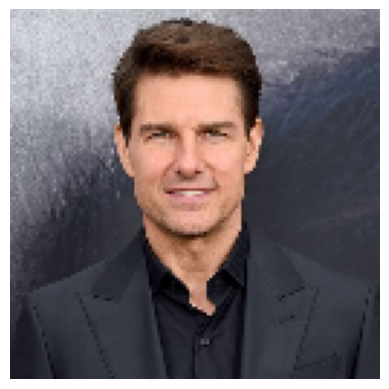

In [3]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained generator model
generator_model = load_model('saved_model/generator_model.h5')

# Compile the model manually
generator_model.compile(optimizer='adam', loss='mean_squared_error')

def reconstruct_image(inpainted_image_path):
    # Load the inpainted image
    inpainted_img = cv2.imread(inpainted_image_path)
    inpainted_img_rgb = cv2.cvtColor(inpainted_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    inpainted_img_resized = cv2.resize(inpainted_img_rgb, (128, 128))  # Resize to match model input size

    # Preprocess the image
    inpainted_img_normalized = inpainted_img_resized / 255.0  # Normalize pixel values to [0, 1]

    # Predict the missing parts
    predicted_missing_parts = generator_model.predict(np.expand_dims(inpainted_img_normalized, axis=0))[0]

    # De-normalize the predicted missing parts
    predicted_missing_parts = np.clip(predicted_missing_parts * 255.0, 0, 255).astype(np.uint8)

    # Resize predicted_missing_parts to match inpainted_img
    predicted_missing_parts_resized = cv2.resize(predicted_missing_parts, (inpainted_img_resized.shape[1], inpainted_img_resized.shape[0]))

    # Inpaint the gray areas using OpenCV's inpaint function
    mask = np.all(inpainted_img_resized == [128, 128, 128], axis=-1)
    mask = np.uint8(mask)
    restored_img = cv2.inpaint(inpainted_img_resized, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Combine the inpainted parts with the restored parts
    reconstructed_img = np.where(mask[..., None], predicted_missing_parts_resized, restored_img)

    # Display the reconstructed image
    plt.imshow(reconstructed_img)
    plt.axis('off')
    plt.show()

# Test the model with an inpainted image

reconstruct_image(r"C:\Users\Aman Joharapurkar\OneDrive\Desktop\006_46519378.jpg")

1/1 [==============================] - 1s 1s/step


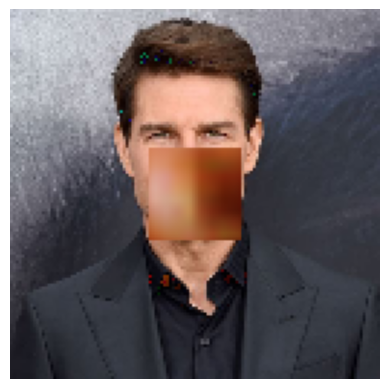

1/1 [==============================] - 1s 708ms/step


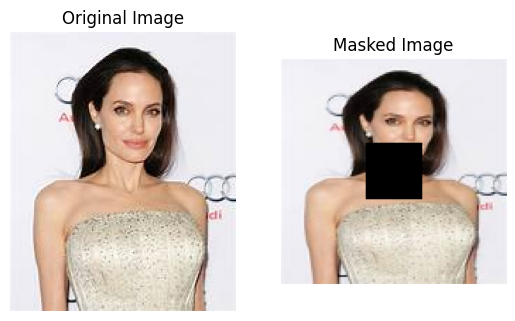

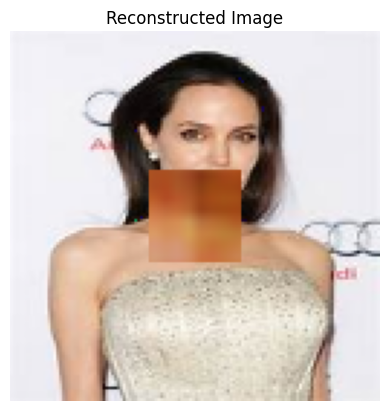

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained generator model
generator_model = load_model('saved_model/generator_model.h5')

# Compile the model manually
generator_model.compile(optimizer='adam', loss='mean_squared_error')

def mask_center(imgs, img_rows=128, img_cols=128, mask_height=32, mask_width=32, channels=3):
    center_y = img_rows // 2
    center_x = img_cols // 2
    half_height = mask_height // 2
    half_width = mask_width // 2

    y1 = np.full(imgs.shape[0], center_y - half_height)
    y2 = np.full(imgs.shape[0], center_y + half_height)
    x1 = np.full(imgs.shape[0], center_x - half_width)
    x2 = np.full(imgs.shape[0], center_x + half_width)

    masked_imgs = np.empty_like(imgs)
    missing_parts = np.empty((imgs.shape[0], mask_height, mask_width, channels))
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        missing_parts[i] = masked_img[y1[i]:y2[i], x1[i]:x2[i], :].copy()
        masked_img[y1[i]:y2[i], x1[i]:x2[i], :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts

def reconstruct_image(input_image_path):
    # Load the input image
    input_img = cv2.imread(input_image_path)
    input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    input_img_resized = cv2.resize(input_img_rgb, (128, 128))  # Resize to match model input size

    # Preprocess the image
    input_img_normalized = input_img_resized / 255.0  # Normalize pixel values to [0, 1]

    # Generate masked image and missing parts
    masked_img, missing_parts = mask_center(np.expand_dims(input_img_normalized, axis=0))

    # Predict the missing parts
    predicted_missing_parts = generator_model.predict(masked_img)[0]

    # De-normalize the predicted missing parts
    predicted_missing_parts = np.clip(predicted_missing_parts * 255.0, 0, 255).astype(np.uint8)

    # Resize the predicted missing parts to match the size of the original image
    predicted_missing_parts_resized = cv2.resize(predicted_missing_parts, (128, 128))

    # Combine the predicted missing parts with the original image
    reconstructed_img = np.where(masked_img[0] == 0, predicted_missing_parts_resized, input_img_resized)

    # Display the reconstructed image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(input_img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Masked Image')
    plt.imshow(masked_img[0])
    plt.axis('off')
    plt.show()

    plt.imshow(reconstructed_img)
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()

# Test the model with an input image
reconstruct_image(r"C:\Users\Aman Joharapurkar\OneDrive\Desktop\004_f61e7d0c.jpg")


1/1 [==============================] - 0s 310ms/step


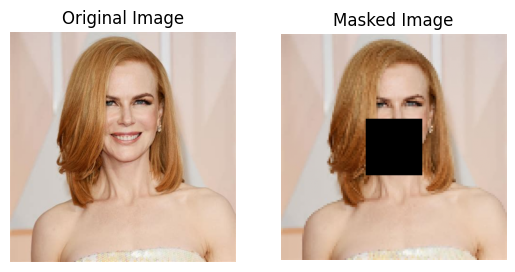

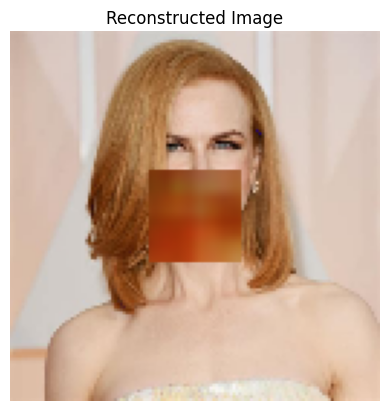

PSNR: 21.926629543304443


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained generator model
generator_model = load_model('saved_model/generator_model.h5')

# Compile the model manually
generator_model.compile(optimizer='adam', loss='mean_squared_error')

def mask_center(imgs, img_rows=128, img_cols=128, mask_height=32, mask_width=32, channels=3):
    center_y = img_rows // 2
    center_x = img_cols // 2
    half_height = mask_height // 2
    half_width = mask_width // 2

    y1 = np.full(imgs.shape[0], center_y - half_height)
    y2 = np.full(imgs.shape[0], center_y + half_height)
    x1 = np.full(imgs.shape[0], center_x - half_width)
    x2 = np.full(imgs.shape[0], center_x + half_width)

    masked_imgs = np.empty_like(imgs)
    missing_parts = np.empty((imgs.shape[0], mask_height, mask_width, channels))
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        missing_parts[i] = masked_img[y1[i]:y2[i], x1[i]:x2[i], :].copy()
        masked_img[y1[i]:y2[i], x1[i]:x2[i], :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts

def calculate_psnr(original_img, reconstructed_img):
    # Convert images to float32
    original_img = original_img.astype(np.float32)
    reconstructed_img = reconstructed_img.astype(np.float32)
    # Calculate MSE
    mse = np.mean((original_img - reconstructed_img) ** 2)
    # Calculate maximum pixel value
    max_pixel = np.amax(original_img)
    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
    return psnr

def reconstruct_image(input_image_path):
    # Load the input image
    input_img = cv2.imread(input_image_path)
    input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    input_img_resized = cv2.resize(input_img_rgb, (128, 128))  # Resize to match model input size

    # Preprocess the image
    input_img_normalized = input_img_resized / 255.0  # Normalize pixel values to [0, 1]

    # Generate masked image and missing parts
    masked_img, missing_parts = mask_center(np.expand_dims(input_img_normalized, axis=0))

    # Predict the missing parts
    predicted_missing_parts = generator_model.predict(masked_img)[0]

    # De-normalize the predicted missing parts
    predicted_missing_parts = np.clip(predicted_missing_parts * 255.0, 0, 255).astype(np.uint8)

    # Resize the predicted missing parts to match the size of the original image
    predicted_missing_parts_resized = cv2.resize(predicted_missing_parts, (128, 128))

    # Combine the predicted missing parts with the original image
    reconstructed_img = np.where(masked_img[0] == 0, predicted_missing_parts_resized, input_img_resized)

    # Display the reconstructed image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(input_img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Masked Image')
    plt.imshow(masked_img[0])
    plt.axis('off')
    plt.show()

    plt.imshow(reconstructed_img)
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()

    # Calculate PSNR
    psnr = calculate_psnr(input_img_resized, reconstructed_img)
    print("PSNR:", psnr)

# Test the model with an input image
reconstruct_image(r"C:\Users\Aman Joharapurkar\OneDrive\Desktop\007_76dc423a.jpg")

In [28]:
!pip install scikit-image